# 0.0. IMPORTS

In [3]:
# Biblioteca para manipulação dos dataframes
import pandas as pd

# Biblioteca para coleta de dados
import psycopg2
import pandas.io.sql as psql
import sqlalchemy as db
from sqlalchemy import create_engine

# Bibliotecas para trabalhar com Gráficos
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

# Biblioteca para configurar layout tela Jupyter
from IPython.core.display import HTML

# Biblioteca para inserir imagem (upload) externa
from IPython.display import Image 

# Bilioteca para criar tabelas manuais
from tabulate import tabulate

# Biblioteca de Machine Learning 
from sklearn.model_selection import train_test_split

# Biblioteca para cálculos estatísticos e matemáticos
from scipy import stats

## 0.1. Helper Functions

Seção para construção de funções auxiliares para o projeto

In [4]:
def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['font.size'] = 10
    display( HTML( '<style>.container { width:97% !important; }</style>') )
    pd.options.display.max_columns = 50
    pd.options.display.max_rows = 50
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    
    return None


def cramer_v( x, y ):
    
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )


# Função para criar conexão no banco onde estão os dados do projeto com a biblioteca psycopg2
def conecta_db():
    con = psycopg2.connect(host='comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com', 
                           port = 5432,
                           database='comunidadedsdb',
                           user='member', 
                           password='cdspa')
    return con



# Função para criar conexão no banco onde estão os dados do projeto com a biblioteca sqlalchemy
def conecta_db_alchemy(host, port, database, username, password):
    
    string_connect = 'postgresql://' + username + ':' + password + '@' + host + ':' + str(port) + '/' + database
    engine = db.create_engine(url = string_connect)
    conn1 = engine.connect()
    
    return conn1



# Função para consultar colunas e valores de uma tabela no banco com a biblioteca psycopg2
def consulta_db(sql):
    con = conecta_db() # conectar ao banco com nossa função conecta_db
    cur = con.cursor() # abrir uma sessão com o cursor (como se fosse o mouse mesmo)
    cur.execute(sql) #aplicar o execute para rodar o SQL 
    
    column_names = [desc[0] for desc in cur.description] # descobrir as colunas da tabela
    
    # Colocar as colunas da tabela em uma lista
    cols = []
    for i in column_names:
        cols.append(i)
        
    recset = cur.fetchall() #fetchall retorna/puxa os dados da tabela
    
    # Colocar os valores da tabela em uma lista 
    registros = []
    for rec in recset:        
        registros.append(rec)
    cur.close() # Para encerrar a conexão do cursor
    con.close() # Para encerrar a conexão do banco de dados - INTERESSANTE FAZER ISSO para não indisponibilizar para outras pessoas
    
    return cols, registros

In [5]:
jupyter_settings()

## 0.2. Collect Data using psycopg2

Carregamento dos dados - Extração

### 0.2.1. Descobrindo as tabelas que existem no BD

In [11]:
con = conecta_db() # conectar ao banco com nossa função conecta_db
cur = con.cursor() # abrir uma sessão com o cursor
cur.execute('SELECT table_catalog, table_schema, table_name, table_type FROM information_schema.tables;') #aplicar o execute para rodar o SQL 
recset = cur.fetchall() #fetchall retorna os dados
recset


[('comunidadedsdb', 'public', 'auth_permission', 'BASE TABLE'),
 ('comunidadedsdb', 'pa004', 'users', 'BASE TABLE'),
 ('comunidadedsdb', 'pa004', 'vehicle', 'BASE TABLE'),
 ('comunidadedsdb', 'pa004', 'insurance', 'BASE TABLE'),
 ('comunidadedsdb', 'public', 'django_migrations', 'BASE TABLE'),
 ('comunidadedsdb', 'public', 'django_content_type', 'BASE TABLE'),
 ('comunidadedsdb', 'public', 'auth_group', 'BASE TABLE'),
 ('comunidadedsdb', 'public', 'auth_group_permissions', 'BASE TABLE'),
 ('comunidadedsdb', 'pg_catalog', 'pg_type', 'BASE TABLE'),
 ('comunidadedsdb', 'pg_catalog', 'pg_foreign_server', 'BASE TABLE'),
 ('comunidadedsdb', 'public', 'htx_user', 'BASE TABLE'),
 ('comunidadedsdb', 'public', 'htx_user_groups', 'BASE TABLE'),
 ('comunidadedsdb', 'public', 'htx_user_user_permissions', 'BASE TABLE'),
 ('comunidadedsdb', 'public', 'data_export_export', 'BASE TABLE'),
 ('comunidadedsdb', 'public', 'data_import_fileupload', 'BASE TABLE'),
 ('comunidadedsdb', 'public', 'django_admin_

### 0.2.2. Coleta da Base de dados Users

In [82]:
col, reg = consulta_db('select * from pa004.users')

df_users = pd.DataFrame(reg, columns = col)

df_users.head()

,id,gender,age,region_code,policy_sales_channel
0,1,Male,44,28.00,26.00
1,2,Male,76,3.00,26.00
2,3,Male,47,28.00,26.00
3,4,Male,21,11.00,152.00
4,5,Female,29,41.00,152.00


In [31]:
df_users.shape

(381109, 5)

### 0.2.3. Coleta da Base de dados Vehicle

In [83]:
col, reg = consulta_db('select * from pa004.vehicle')

df_ve = pd.DataFrame(reg, columns = col)

df_ve.head()

,id,driving_license,vehicle_age,vehicle_damage
0,1,1,> 2 Years,Yes
1,2,1,1-2 Year,No
2,3,1,> 2 Years,Yes
3,4,1,< 1 Year,No
4,5,1,< 1 Year,No


In [35]:
df_ve.shape

(381109, 4)

### 0.2.4. Coleta da Base de dados Insurance

In [84]:
col, reg = consulta_db('select * from pa004.insurance')

df_insu = pd.DataFrame(reg, columns = col)

df_insu.head()

,id,previously_insured,annual_premium,vintage,response
0,1,0,40454.00,217,1
1,2,0,33536.00,183,0
2,3,0,38294.00,27,1
3,4,1,28619.00,203,0
4,5,1,27496.00,39,0


In [36]:
df_insu.shape

(381109, 5)

**Análise:** Como cada uma das bases da problemática não possuem colunas em comum e a quantidade de linhas em cada uma delas é a mesma, para juntar os dados, deve-se unir as tabelas lateralmente

### 0.2.5. Base de Dados Final

In [85]:
df_half = pd.merge(df_users, df_ve, how = 'inner', on = 'id')
df_full = pd.merge(df_half, df_insu, how = 'inner', on = 'id')

In [9]:
df_full.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,1,Male,44,28.00,26.00,1,> 2 Years,Yes,0,40454.00,217,1
1,2,Male,76,3.00,26.00,1,1-2 Year,No,0,33536.00,183,0
2,3,Male,47,28.00,26.00,1,> 2 Years,Yes,0,38294.00,27,1
3,4,Male,21,11.00,152.00,1,< 1 Year,No,1,28619.00,203,0
4,5,Female,29,41.00,152.00,1,< 1 Year,No,1,27496.00,39,0


## 0.3. Option of Collect Data using Pandas

In [55]:
## Credenciais

host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
port = 5432
database = 'comunidadedsdb'
username = 'member'
password = 'cdspa'

In [61]:
## DUAS FORMAS:

## 1

query_tables = """ SELECT * 
                   FROM pa004.users u INNER JOIN pa004.vehicle v ON (u.id = v.id)
                                      INNER JOIN pa004.insurance i ON (u.id = i.id)
                """

df = psql.read_sql( query_tables, conecta_db_alchemy(host, port, database, username, password ) )

df.head()

,id,gender,age,region_code,policy_sales_channel,id,driving_license,vehicle_age,vehicle_damage,id,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,7,1,< 1 Year,Yes,7,0,23367.0,249,0
1,13,Female,41,15.0,14.0,13,1,1-2 Year,No,13,1,31409.0,221,0
2,18,Female,25,35.0,152.0,18,1,< 1 Year,No,18,1,46622.0,299,0
3,31,Female,26,8.0,160.0,31,1,< 1 Year,No,31,0,2630.0,136,0
4,39,Male,45,8.0,124.0,39,1,1-2 Year,Yes,39,0,42297.0,264,0


In [62]:
## 2

query_tables = """ SELECT * 
                   FROM pa004.users u INNER JOIN pa004.vehicle v ON (u.id = v.id)
                                      INNER JOIN pa004.insurance i ON (u.id = i.id)
                """

df = pd.read_sql( query_tables, conecta_db_alchemy(host, port, database, username, password) )

df.head()

,id,gender,age,region_code,policy_sales_channel,id,driving_license,vehicle_age,vehicle_damage,id,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,7,1,< 1 Year,Yes,7,0,23367.0,249,0
1,13,Female,41,15.0,14.0,13,1,1-2 Year,No,13,1,31409.0,221,0
2,18,Female,25,35.0,152.0,18,1,< 1 Year,No,18,1,46622.0,299,0
3,31,Female,26,8.0,160.0,31,1,< 1 Year,No,31,0,2630.0,136,0
4,39,Male,45,8.0,124.0,39,1,1-2 Year,Yes,39,0,42297.0,264,0


# 1.0. DESCRIÇÃO DOS DADOS

In [86]:
### Cópia do dataframe em início de sessão 
### OBJETIVO: Caso seja realizado alguma instrução errada sob os dados trabalhados, poder ter um ponto de backup.

df1 = df_full.copy()

## 1.1. Rename Columns

Ter o nome das colunas de maneira mais intuitiva para trabalhar com ciência de dados

In [21]:
df1.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

Caso o estilo do nome dado para as colunas estivesse em Kamel Case, poderia aqui fazer uma alteração para trabalhar com Snake Case.

In [87]:
#renomeando nome das colunas para façam mais sentido durante análise, evitando interpretações erradas e levando em conta tamanho do nome

# policy_sales_channel -> sales_channel
# previously_insured -> vehicle_insured
# vintage -> days_client_associate
# response -> interested 


df1.rename(columns = {'policy_sales_channel':'sales_channel', 'previously_insured' : 'vehicle_insured', 'vintage': 'days_client_associate',
                      'response':'interested'}, inplace = True)

Caso a ordenação das colunas do dataset estivesse de uma forma desorganizada, poderia aqui organizar a ordem das colunas.

In [12]:
df1.columns

Index(['id', 'gender', 'age', 'region_code', 'sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage', 'vehicle_insured',
       'annual_premium', 'days_client_associate', 'interested'],
      dtype='object')

## 1.2 Columns Meanings

Objetivo é compreender o significado de cada coluna  


- **id:** uma identificação única para cada cliente;


- **gender:** gênero do cliente;


- **age:** idade do cliente;


- **region_code:** uma identificação única que indica a região de cada cliente;	


- **sales_channel:** código anônimo que representa o canal de contato/divulgação que o cliente utilizou com a empresa no momento da venda;


- **driving_license:** indica se o cliente possui ou não permissão (documento) para dirigir (0 = não possui, 1 = possui);


- **vehicle_age:** idade do veículo;	


- **vehicle_damage:** indica se o cliente já danificou o veículo no passado (0 = não danificou, 1 = danificou);


- **vehicle_insured:** indica se o cliente já possui seguro para o veículo (0 = não possui, 1 = possui);


- **annual_premium:** montante que o cliente necessita pagar como prêmio anualmente;

OBS: Não ficou explícito se esse prêmio se refere ao novo produto de seguro veicular ou se seria o de saúde que o cliente já paga, na minha interpretação ele representa o prêmio pago anualmente pelo cliente pelo serviço de seguro de saúde que já possui.


- **days_client_associate:** número de dias em que a pessoa é cliente da empresa;	


- **interested:** indica se o cliente está interessado no serviço de seguro veicular (0 = não está interessado, 1 = está interessado).


## 1.3. Data Dimensions

In [32]:
print(f'Quantidade de Linhas: {df1.shape[0]}')
print(f'Quantidade de Colunas: {df1.shape[1]}')

#print('Quantidade de Linhas: {}'.format(df1.shape[0]))
#print('Quantidade de Colunas: {}'.format(df1.shape[1]))

Quantidade de Linhas: 381109
Quantidade de Colunas: 12


## 1.4. Data Types

In [36]:
## INSPECIONANDO


df1.dtypes

id                         int64
gender                    object
age                        int64
region_code              float64
sales_channel            float64
driving_license            int64
vehicle_age               object
vehicle_damage            object
vehicle_insured            int64
annual_premium           float64
days_client_associate      int64
interested                 int64
dtype: object

In [44]:
# 'region_code'

df1['region_code'].sort_values().unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52.])

In [48]:
# 'sales_channel'

df1['sales_channel'].sort_values().unique()

array([  1.,   2.,   3.,   4.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,
        13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
        24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,
        35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,
        46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,
        57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,
        68.,  69.,  70.,  71.,  73.,  74.,  75.,  76.,  78.,  79.,  80.,
        81.,  82.,  83.,  84.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,
        93.,  94.,  95.,  96.,  97.,  98.,  99., 100., 101., 102., 103.,
       104., 105., 106., 107., 108., 109., 110., 111., 112., 113., 114.,
       115., 116., 117., 118., 119., 120., 121., 122., 123., 124., 125.,
       126., 127., 128., 129., 130., 131., 132., 133., 134., 135., 136.,
       137., 138., 139., 140., 143., 144., 145., 146., 147., 148., 149.,
       150., 151., 152., 153., 154., 155., 156., 15

In [49]:
# 'vehicle_age'
# por enquanto não irei alterar pois o dado condiz com o tipo, mas depois na etapa de feature eng. posso mexer nela

df1['vehicle_age'].sort_values().unique()

array(['1-2 Year', '< 1 Year', '> 2 Years'], dtype=object)

In [50]:
# 'vehicle_damage'
# por enquanto não irei alterar pois o dado condiz com o tipo, mas depois na etapa de feature eng. posso mexer nela

df1['vehicle_damage'].sort_values().unique()

array(['No', 'Yes'], dtype=object)

**Análise:**

- region_code é uma identificação única que indica a região de cada cliente e vai de 0 a 52

***Ação:*** Trocar de float para int, pois não há número com vírgula;

- sales_channel é o código anônimo que representa o canal de contato/divulgação que o cliente utiliza com a empresa e está distribuído entre 1 e 163

***Ação:*** Trocar de float para int, pois não há número com vírgula.

In [88]:
df1['region_code'] = df1['region_code'].astype('int64')
df1['sales_channel'] = df1['sales_channel'].astype('int64')

## 1.5. Check Duplicates

In [38]:
## Checando ID´s duplicados

dup = df1['id'].duplicated()

df1[dup]

,id,gender,age,region_code,sales_channel,driving_license,vehicle_age,vehicle_damage,vehicle_insured,annual_premium,days_client_associate,interested


In [39]:
df1['id'].duplicated().sum()

0

**Análise:**

- Não existem clientes com registro duplicado no conjunto de dados. Sendo assim, não é necessário tratá-lo.

## 1.6. Check NA

In [60]:
# MÉTODO .isna() vai varrer o dataset indicando para cada valor de linha e coluna se está NA (True) ou possui valor (False)   
# .sum() para somar os valores True nas colunas e dar dimensão de dados faltantes por coluna

df1.isna().sum()

id                       0
gender                   0
age                      0
region_code              0
sales_channel            0
driving_license          0
vehicle_age              0
vehicle_damage           0
vehicle_insured          0
annual_premium           0
days_client_associate    0
interested               0
dtype: int64

**Análise:**

- Não existem valores nulos em nenhum atributo do conjunto de dados. Sendo assim, não é necessário tratá-lo.

## 1.7. Descriptive Statistical

In [62]:
df1.dtypes

id                         int64
gender                    object
age                        int64
region_code                int64
sales_channel              int64
driving_license            int64
vehicle_age               object
vehicle_damage            object
vehicle_insured            int64
annual_premium           float64
days_client_associate      int64
interested                 int64
dtype: object

In [94]:
## Separar atributos/colunas em numéricas e categóricas

num_attributes = df1[['age', 'annual_premium', 'days_client_associate']]
cat_attributes = df1[['gender', 'region_code', 'sales_channel','driving_license', 'vehicle_age','vehicle_damage', 'vehicle_insured','interested']]

**OBS:** se possui-se atributos com data buscaria analisar o range das datas.

### 1.7.1. Numerical Attributes

In [90]:
# OPTION 1

# Central Tendency - mean, median

# ct1 = pd.DataFrame( num_attributes.apply( np.mean ) )
# ct2 = pd.DataFrame( num_attributes.apply( np.median ) )
# 
# # Dispersion - std, min, max, range, skew, kurtosis
# d1 = pd.DataFrame( num_attributes.apply( np.std ) )
# d2 = pd.DataFrame( num_attributes.apply( min ) )
# d3 = pd.DataFrame( num_attributes.apply( max ) )
# d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) )
# d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) )
# d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) )
# 
# m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6], axis = 1 ).reset_index()
# 
# m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis']

# OPTION  2

## Min, Max, Range, Mean, Median, Std, Skew, Kurtosis
num_attributes.agg(['min', 'max', 'ptp', 'mean', 'median', 'std', 'skew', 'kurtosis']).T.reset_index().rename(columns={'index': 'attributes', 'ptp': 'range'})



,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,20.00,85.00,65.00,38.82,36.00,15.51,0.67,-0.57
1,annual_premium,2630.00,540165.00,537535.00,30564.39,31669.00,17213.16,1.77,34.00
2,days_client_associate,10.00,299.00,289.00,154.35,154.00,83.67,0.00,-1.20


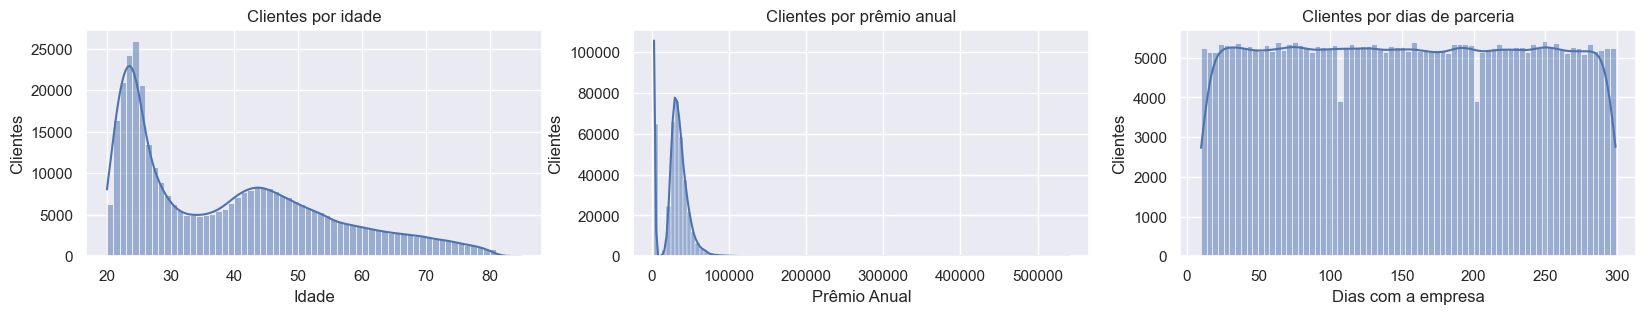

In [91]:
#Num Attributes plot

plt.subplot (3,3,1)
age = sns.histplot(df1['age'], binwidth=1, kde=True);
age.set_ylabel('Clientes')
age.set_xlabel('Idade')
age.set_title('Clientes por idade');

plt.subplot (3,3,2)
ap = sns.histplot(data = df1 , x = 'annual_premium', bins = 100, kde = True);
ap.set_ylabel('Clientes')
ap.set_xlabel('Prêmio Anual')
ap.set_title('Clientes por prêmio anual');

plt.subplot (3,3,3)
da_hist = sns.histplot(df1['days_client_associate'], kde=True);
da_hist.set_ylabel('Clientes')
da_hist.set_xlabel('Dias com a empresa')
da_hist.set_title('Clientes por dias de parceria');

**Análises:**

*age:*

- A base de clientes possui idade entre 20 a 85 anos;
- Não possui range elevado; 
- Skew positiva indica que a distribuição dos valores está mais para a esquerda em relação a normal, ou seja, mais pessoas de 20 a 50 anos;
- Kurtosis negativa indica que a distribuição não possui uma alta concentração de valores em um determinado ponto, o que significa que está bem espalhado a distribuição dos dados entre as idades.

*days_client_associate:*

- A base de clientes está junto a empresa variando entre 10 a 299 dias;
- Skew muito próxima de zero indica distribuição próxima da normal, ou seja, indica que a distribuição dos dados é simétrica;
- Kurtosis negativa indica que a distribuição não possui uma alta concentração de valores em um determinado ponto, o que significa que está bem espalhado a distribuição dos valores entre os clientes.

*annual_premium:*

- A base de clientes paga um prêmio de seguro atualmente que varia entre 2.630,00 a 540.165,00 reais;
- Range muito elevado;
- Desvio Padrão alto;
- Skew positiva indica que a distribuição dos valores está mais para a esquerda em relação a normal, ou seja, mais clientes pagam prêmio entre 2.630,00 a 100.000,00 reais;
- Kurtosis bastante positiva indica que há deformação vertical devido a concentração dos dados sob um ponto.

<AxesSubplot: xlabel='interested', ylabel='days_client_associate'>

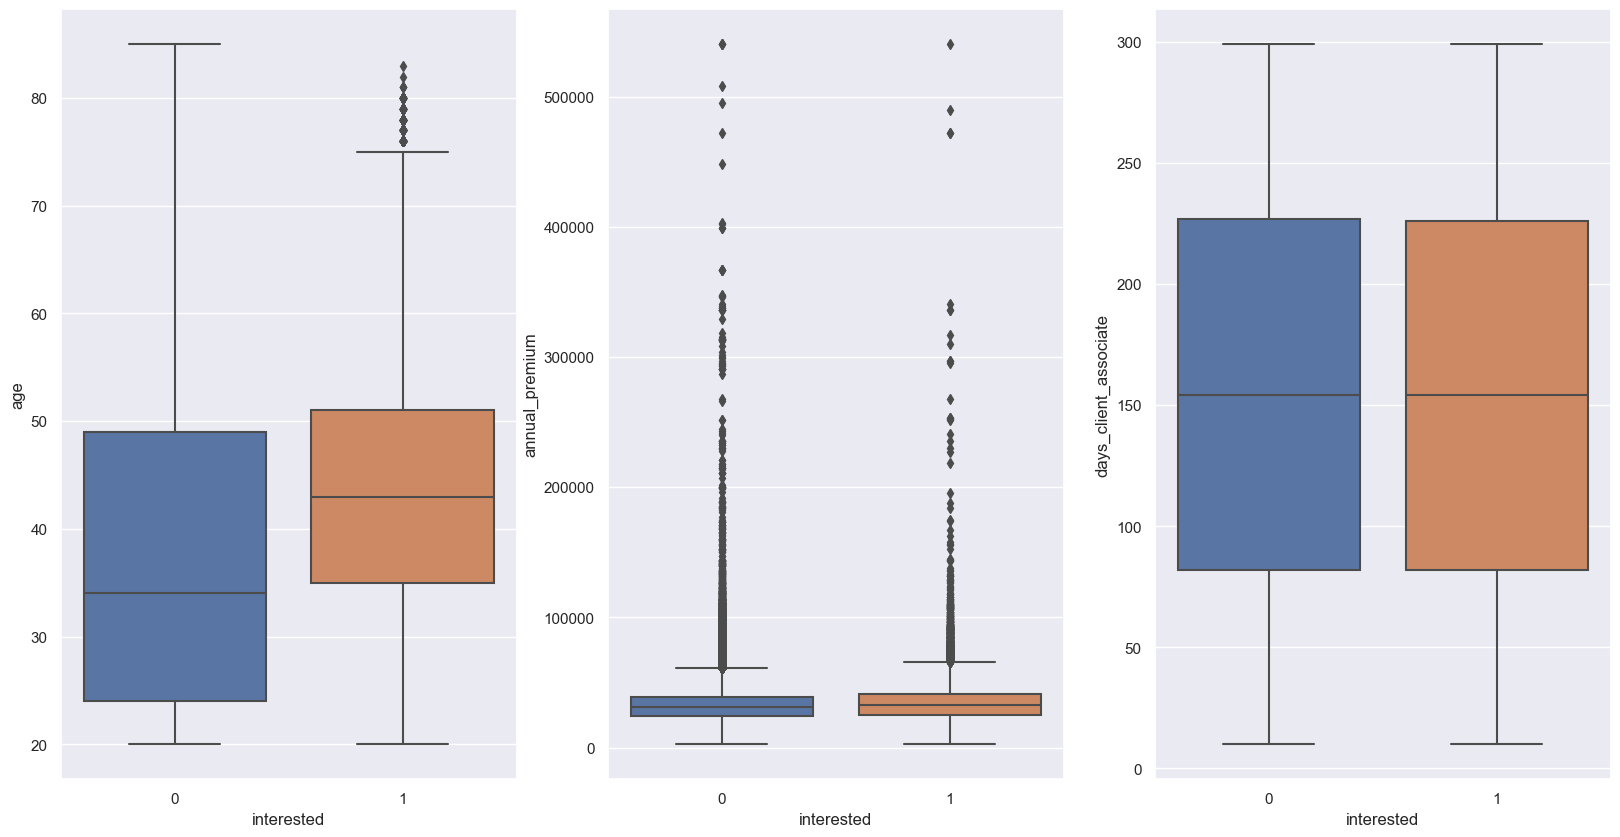

In [81]:
# Idade do cliente segmentado por interesse
plt.subplot( 1, 3, 1)
sns.boxplot(x = 'interested', y = 'age', data = df1 )

# Prêmio pago segmentado por interesse
plt.subplot( 1, 3, 2)
sns.boxplot(x = 'interested', y = 'annual_premium', data = df1 )

# Dias em que a pessoa é cliente segmentado por interesse
plt.subplot( 1, 3, 3)
sns.boxplot(x = 'interested', y = 'days_client_associate', data = df1 )

In [92]:
## Ampliar o box-plot do premio annual para valores mais concentrados, retirando outliers

Q1 = df1['annual_premium'].quantile(0.25)
Q3 = df1['annual_premium'].quantile(0.75)

IQR = Q3 - Q1 

val_max = Q3 + 1.5*IQR

val_max

61892.5

<AxesSubplot: xlabel='interested', ylabel='annual_premium'>

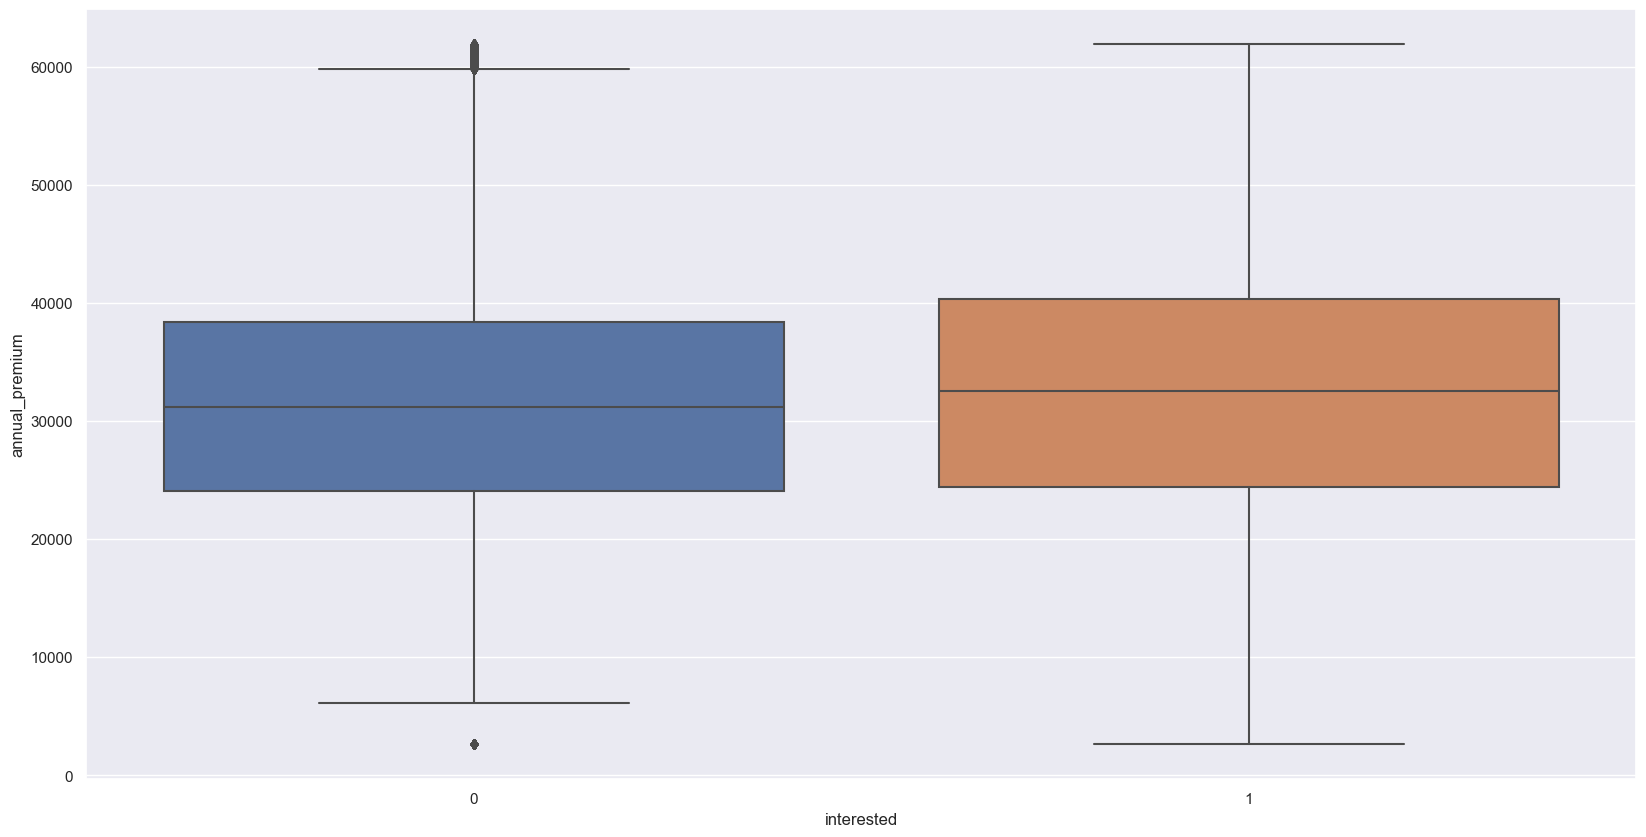

In [93]:
aux2 = df1.loc[ df1['annual_premium'] < 61892.5 , ['annual_premium','interested'] ] 

sns.boxplot(x = 'interested', y = 'annual_premium', data = aux2 )

**Análises:**

*age:*

- Analisando a idade sobre o interesse na compra é notável que quem possui interesse possui uma idade no intervalo quartílico maior dos que indicaram que não possuem interesse. 

*days_client_associate:*

- Muito similar a distribuição por dias em que a pessoa é cliente da empresa levando-se em consideração seu interesse.

*annual_premium:*

- Levando-se em consideração a variável interesse, não há muita diferença na distribuição entre o atributo annual_premium.

### 1.7.2. Categorical Attributes

In [22]:
# Quantidade Valores únicos de cada uma das categorias 

print(f"Quantidade de valores únicos em cada atributo: \n { cat_attributes.apply( lambda x: x.nunique() ) } \n")
print(f"Valores únicos em cada atributo: \n { cat_attributes.apply( lambda x: x.unique() ) } \n")

Quantidade de valores únicos em cada atributo: 
 gender               2
region_code         53
sales_channel      155
driving_license      2
vehicle_age          3
vehicle_damage       2
vehicle_insured      2
interested           2
dtype: int64 

Valores únicos em cada atributo: 
 gender                                                [Male, Female]
region_code        [28, 3, 11, 41, 33, 6, 35, 50, 15, 45, 8, 36, ...
sales_channel      [26, 152, 160, 124, 14, 13, 30, 156, 163, 157,...
driving_license                                               [1, 0]
vehicle_age                          [> 2 Years, 1-2 Year, < 1 Year]
vehicle_damage                                             [Yes, No]
vehicle_insured                                               [0, 1]
interested                                                    [1, 0]
dtype: object 



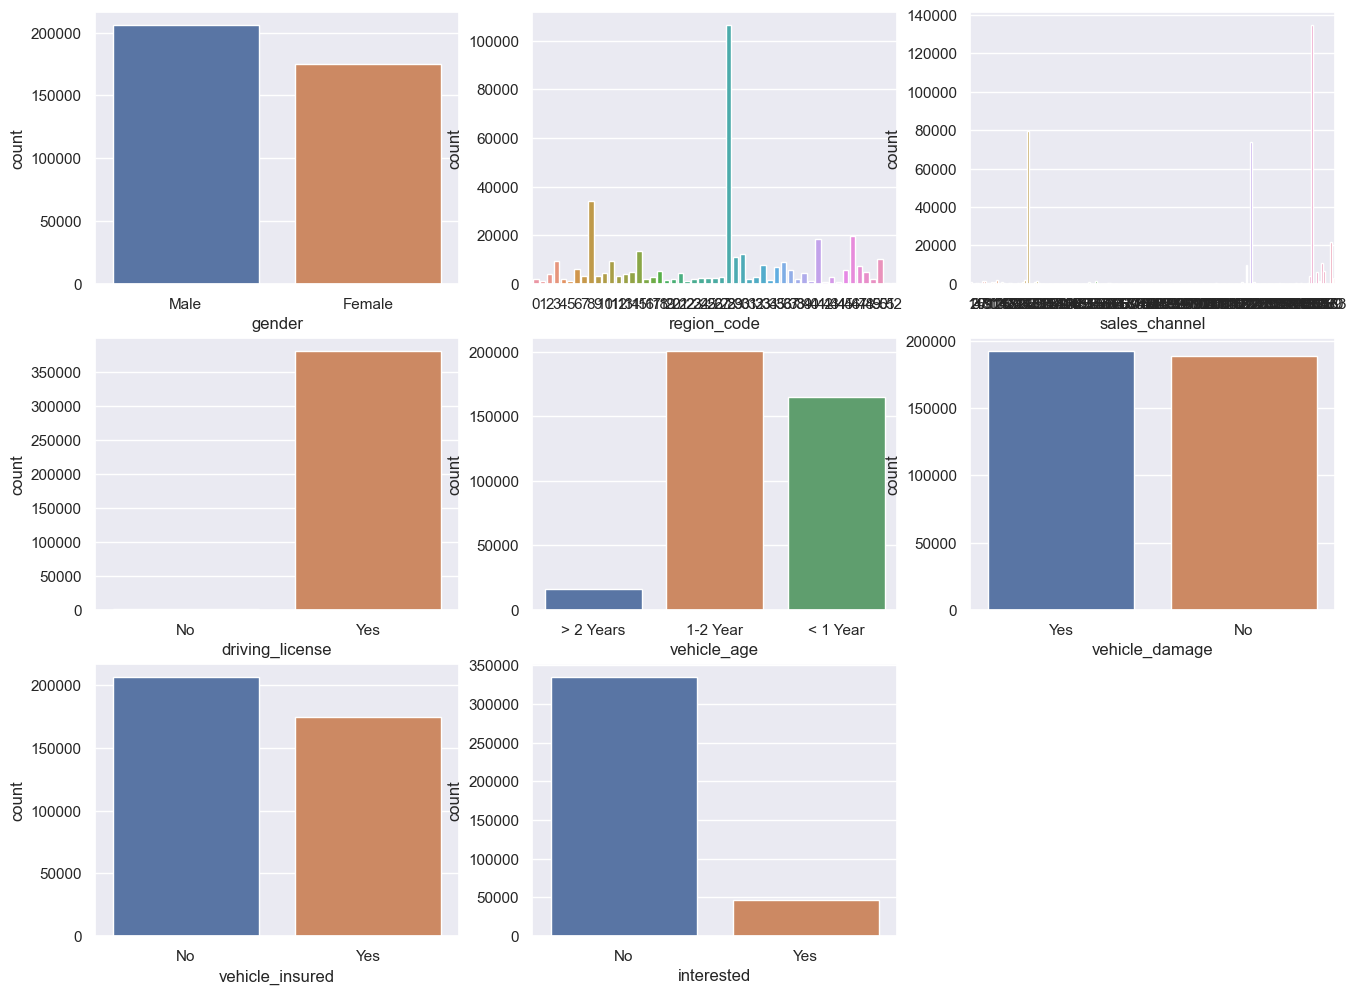

In [28]:
# Plot

plt.figure(figsize=(16,12))

plt.subplot (3,3,1)
sns.countplot (x = cat_attributes['gender']);


plt.subplot (3,3,2)
sns.countplot (x = cat_attributes['region_code']);


plt.subplot (3,3,3)
sns.countplot (x = cat_attributes['sales_channel']);


plt.subplot (3,3,4)
sns.countplot (x = cat_attributes['driving_license']);
plt.xticks([0,1],['No','Yes']);


plt.subplot (3,3,5)
sns.countplot (x = cat_attributes['vehicle_age']);


plt.subplot (3,3,6)
sns.countplot (x = cat_attributes['vehicle_damage']);


plt.subplot (3,3,7)
sns.countplot (x = cat_attributes['vehicle_insured']);
plt.xticks([0,1],['No','Yes']);


plt.subplot (3,3,8)
sns.countplot (x = cat_attributes['interested']);
plt.xticks([0,1],['No','Yes']);

In [96]:
# gender

df1[['gender','id']].groupby('gender').count()

,id
gender,
Female,175020
Male,206089


In [97]:
# driving_license

df1[['driving_license','id']].groupby('driving_license').count()

,id
driving_license,
0,812
1,380297


In [98]:
# vehicle_age

df1[['vehicle_age','id']].groupby('vehicle_age').count()

,id
vehicle_age,
1-2 Year,200316
< 1 Year,164786
> 2 Years,16007


In [99]:
# vehicle_damage

df1[['vehicle_damage','id']].groupby('vehicle_damage').count()



,id
vehicle_damage,
No,188696
Yes,192413


In [100]:
# vehicle_insured

df1[['vehicle_insured','id']].groupby('vehicle_insured').count()

,id
vehicle_insured,
0,206481
1,174628


In [101]:
## Variável Resposta 

# interested

df1[['interested','id']].groupby('interested').count()

,id
interested,
0,334399
1,46710


**Análises:**


*gender:*
    
- Possuem mais homens do que mulheres na base de clientes, mas existe um equilíbrio(balanceamento) entre os valores.
    

*driving_license:*
    
- Alto desbalanceamento, muito mais pessoas que possuem permissão para dirigir do que as que não possuem.

    
*vehicle_age:*

- A base de clientes possui veículos em sua grande maioria com idade menor que 2 anos.


*vehicle_damage:*

- Possuem mais clientes que já danificaram o veículo do que os que não, mas existe um equilíbrio(balanceamento) entre os valores.

*vehicle_insured:*

- Possuem mais clientes que não possuem seguro em seus automóveis, mas existe um equilíbrio(balanceamento) entre os valores.

*interested:*

- Alto desbalanceamento, muito mais clientes não interessados do que clientes interessados em serviço de seguro veicular.


## 1.8. Split in train and test

In [12]:
X = df1.drop('interested', axis = 1).copy()
Y = df1['interested'].copy() # var. resposta


X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.2,
                                                    random_state= 42,
                                                    stratify=Y)

In [55]:
X_train.head()

,id,gender,age,region_code,sales_channel,driving_license,vehicle_age,vehicle_damage,vehicle_insured,annual_premium,days_client_associate
274710,274711,Male,22,40,152,1,< 1 Year,Yes,0,25455.00,203
216539,216540,Female,26,8,26,1,< 1 Year,No,1,38393.00,45
78983,78984,Female,32,28,122,1,< 1 Year,Yes,0,32118.00,35
218368,218369,Male,32,37,152,1,< 1 Year,Yes,0,37711.00,215
307215,307216,Female,24,28,156,1,< 1 Year,Yes,0,48706.00,222


In [13]:
## Porcentagem de valores da variável target em cada separação de dados

print(f"Treino: \n {Y_train.value_counts(normalize = True)} \n")
print(f"Total: {Y_train.count()} \n")
print(f"Teste: \n {Y_test.value_counts(normalize = True)} \n")
print(f"Total: {Y_test.count()}")

Treino: 
 0   0.88
1   0.12
Name: interested, dtype: float64 

Total: 304887 

Teste: 
 0   0.88
1   0.12
Name: interested, dtype: float64 

Total: 76222


In [ ]:
# 304887 -> 80% (Dados de Treino) e 76222 -> 20% (Dados de Teste)

In [69]:
## Conjunto de dados de treino o qual treinará o modelo e uma parte será destinada a avaliar a capacidade de aprendizado do modelo com dados de
## validação

df_train = pd.concat([X_train,Y_train], axis = 1).reset_index(drop = True)

## Conjunto de dados de teste o qual irá simular o comportamento (desempenho) do modelo em produção, ou seja, irá avaliar a capacidade de 
# generalização do modelo

df_test = pd.concat([X_test,Y_test], axis = 1).reset_index(drop = True)

In [74]:
# Export/save dataframes into .csv

#df_train.to_csv('data/train.csv', index = False)
#df_test.to_csv('data/test.csv', index = False)

# 2.0. FEATURE ENGINEERING

In [6]:
## Import train data 

train = pd.read_csv('../data/train.csv')

In [7]:
### Cópia do dataframe em início de sessão 
### OBJETIVO: Caso seja realizado alguma instrução errada sob os dados trabalhados, poder ter um ponto de backup.

df2 = train.copy()

## 2.1. Mapa Mental de Hipóteses

Objetivo dele é gerar uma lista de hipóteses.         

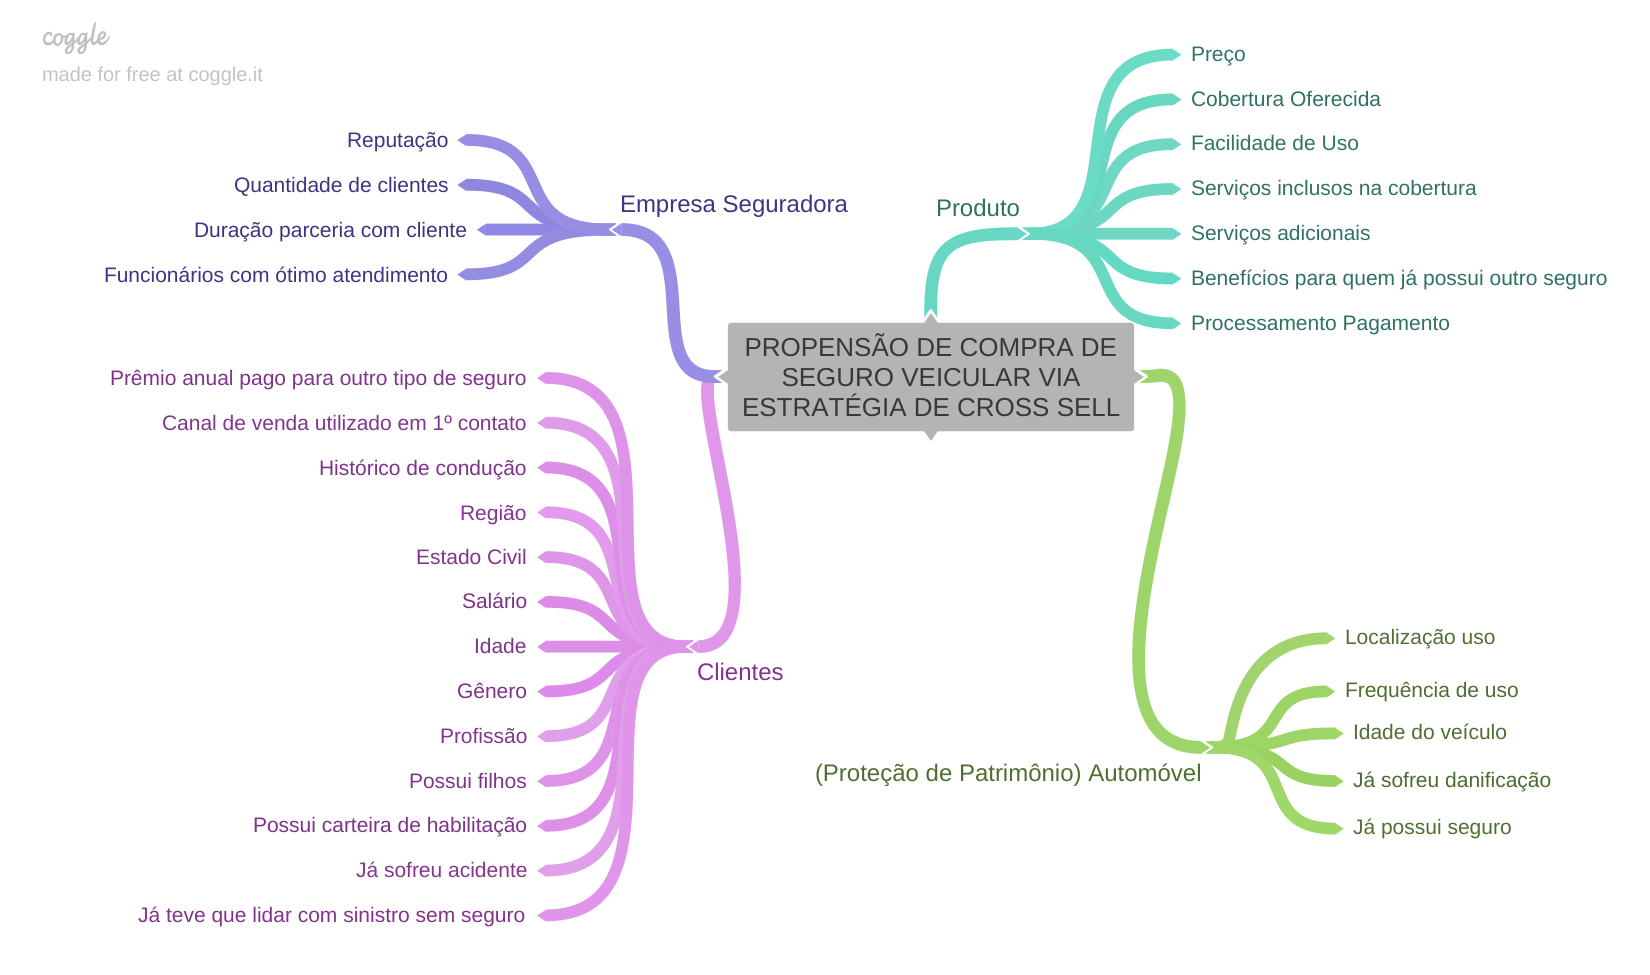

In [2]:
Image('../img/mapa_mental.png')

## 2.2. Criação de Hipóteses

Relacionar os atributos de cada agente do mapa mental com o fenômeno de interesse para criar as hipóteses.

### 2.2.1. Hipóteses Clientes

**1.** Clientes com filhos deveriam ter maior interesse de compra de seguro veicular.

**2.** Clientes com mais idade deveriam ter maior interesse na compra de seguro veicular.

**3.** Cliente com maiores salários deveriam ter maior interesse na compra de seguro veicular.

**4.** Clientes do gênero Masculino deveriam ter maior interesse na compra de seguro veicular.

**5.** Clientes da região 30 a 40 deveriam ter maior interesse na compra de seguro veicular.

**6.** Clientes com carteira de habilitação deveriam ter maior interesse na compra de seguro veicular.

**7.** Clientes com canal de vendas utilizado sendo de 130 a 140 deveriam ter maior interesse na compra de seguro veicular.

**8.** Clientes com histórico de condução péssimo deveriam ter maior interesse na compra de seguro veicular.

**9.** Clientes que já sofreram acidentes deveriam ter maior interesse na compra de seguro veicular.

**10.** Clientes com estado civil casado e divorciado deveriam ter maior interesse na compra de seguro veicular.

**11.** Clientes com profissão de Engenheiro deveriam ter maior interesse na compra de seguro veicular.

**12.** Clientes que pagam prêmio por seguro de saúde entre 2.630,00 e 20.000 reais deveriam ter maior interesse na compra de seguro veicular.

**13.** Clientes que já sofreram com sinistros em seu veículo sem ter seguro deveriam ter maior interesse na compra de seguro veicular.

### 2.2.2. Hipóteses Automóvel

**1.** Clientes que possuem veículo para uso em grandes centros e vias engarrafadas deveriam ter maior interesse na compra de seguro veicular.

**2.** Clientes que utilizam mais frequentemente seu veículo deveriam ter maior interesse na compra de seguro veicular.

**3.** Clientes com automóvel mais novo deveriam ter maior interesse na compra de seguro veicular.

**4.** Clientes com automóvel já danificado deveriam ter menor interesse na compra de seguro veicular.

**5.** Clientes com automóvel que já possui seguro deveriam ter menor interesse na compra de seguro veicular.

### 2.2.3. Hipóteses Empresa Seguradora

**1.** Clientes que veêm a empresa com boa reputação deveriam ter maior interesse na compra de seguro veicular.


**2.** Clientes que notam que a empresa atende uma grande quantidade de cliente deveriam ter maior interesse na compra de seguro veicular.


**3.** Clientes que estão a mais tempo com a empresa recebendo seguro de saúde deveriam ter maior interesse na compra de seguro veicular.


**4.** Clientes que consideram que a empresa possui funcionários com ótimo atendimento deveriam ter maior interesse na compra de seguro veicular.


## 2.3. Lista Final de Hipóteses

Priorizar as hipóteses a serem validadas nesse primeiro ciclo que contenham informações já coletadas.

**1.** Clientes com mais idade deveriam ter maior interesse na compra de seguro veicular.


**2.** Clientes do gênero Masculino deveriam ter maior interesse na compra de seguro veicular.


**3.** Clientes da região 30 a 40 deveriam ter maior interesse na compra de seguro veicular.


**4.** Clientes com carteira de habilitação deveriam ter maior interesse na compra de seguro veicular.


**5.** Clientes com canal de vendas utilizado sendo de 130 a 140 deveriam ter maior interesse na compra de seguro veicular.


**6.** Clientes que pagam prêmio por seguro de saúde entre 2.630,00 e 20.000,00 reais deveriam ter maior interesse na compra de seguro veicular.


**7.** Clientes com automóvel mais novo deveriam ter maior interesse na compra de seguro veicular.


**8.** Clientes com automóvel já danificado deveriam ter menor interesse na compra de seguro veicular.


**9.** Clientes com automóvel que já possui seguro deveriam ter menor interesse na compra de seguro veicular.


**10.** Clientes que estão a mais tempo com a empresa recebendo seguro de saúde deveriam ter maior interesse na compra de seguro veicular.


## 2.4. Feature Engineering

Criação de features ou ajuste de valores features já existentes.

**Questionamento:** Quais variáveis/atributos/carac. preciso ajustar ou criar para validar as hipóteses de negócio levantadas?

In [8]:
### Das variáveis -> COLOCAR SIGNIFICADO E EM PORTUGUÊS 

# gender   [Male, Female] -> [ Masculino, Feminino ]

df2.replace( {'gender': {'Male':'Masculino', 'Female': 'Feminino'}}, inplace = True )

# driving_license                                               [1, 0]

df2['driving_license'] = df2['driving_license'].apply(lambda x: 'Possui carteira' if x == 1 else 'Sem carteira')

# vehicle_age                          [> 2 Years, 1-2 Year, < 1 Year]

df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'Menos de 1 ano' if x == '< 1 Year' else 'Entre 1 e 2 anos' if x == '1-2 Year' else 
                                            'Mais de 2 anos') 

# vehicle_damage                                             [Yes, No]


df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 'Foi danificado' if x == 'Yes' else 'Não foi danificado') 


# vehicle_insured                                               [0, 1]

df2['vehicle_insured'] = df2['vehicle_insured'].apply(lambda x: 'Já possui seguro' if x == 1 else 'Não possui seguro') 

# interested  

df2.replace( {'interested': {1:'Interessado',0:'Não interessado'} }, inplace = True )  

### Das variáveis -> SEPARAR EM VARIÁVEIS CATEGÓRICAS QUANTITATIVAS 

# age -> [20-30 | 31-50 | 51 - 80]
df2['age_level'] = df2['age'].apply(lambda x: '20-30' if (x >= 20) & (x <= 30) else '31-40' if (x > 30) & (x <= 40) else '41-50'
                                                      if (x > 40) & (x <= 50) else '51-85')


# days_client_associate -> [ 10-100 | 101-200 | 201-299 ]

df2['days_client_associate_level'] = df2['days_client_associate'].apply(lambda x: '10-100' if (x >= 10) & (x <= 100) else '101-200' if (x > 100) & (x <= 200) else '201-299' )


# annual_premium -> Range grande que vai de 2.630,00 a 540.165,00

df2["annual_premium_level"] = df2["annual_premium"].apply(lambda x: '0-20000' if (x >= 0) & (x <= 20000) else '20001-25000' 
                                                                              if (x > 20000) & (x <= 25000) else '25001-30000' 
                                                                              if (x > 25000) & (x <= 30000) else '30001-35000'
                                                                              if (x > 30000) & (x <= 35000) else '35001-40000'
                                                                              if (x > 35000) & (x <= 40000) else '40001-60000'
                                                                              if (x > 40000) & (x <= 60000) else '60001-540165')

**OBS:** Sobre os atributos sales_channel e region_code:  

Como não sei se os valores dos códigos que representam o contato de vendas feito com o cliente, bem como, a região de cada cliente segue uma ordem de valores semelhantes que façam sentido em termos de negócio junta-los, não irei juntar os códigos. 

# 3.0. FILTRAGEM DE VARIÁVEIS

O objetivo é restringir variáveis/features/atributos considerando cenário real e de interesse da análise do fenômeno de negócio.

In [9]:
### Cópia do dataframe em início de sessão 
### OBJETIVO: Caso seja realizado alguma instrução errada sob os dados trabalhados, poder ter um ponto de backup.

df3 = df2.copy()

- **PENSAR EM FILTRAR:** 

- *driving_license:* levantei a hipótese de que não poderia se contratar seguro sem possuir CNH.
- *vehicle_insured:* levantei a hipótese de que se a pessoa já possui seguro para o seu carro, dificilmente iria trocar.

Porém, tomei a decisão de não filtrar nenhuma, pois:

- *driving_license:* Por meio de pesquisas em canais especializados, certifiquei que pode contratar seguro quem não possui CNH, pois existe 
posteriormente a indicação de condutor principal. (Ex: Mãe não quer dirigir mas compra carro e filho possui CNH.)
    
**Fonte:** https://ambitojuridico.com.br/direito-de-transito/posso-contratar-um-seguro-auto-sem-ter-cnh/   
    
- *vehicle_insured:* mesmo que o carro de um cliente já possua seguro, pode haver a insatisfação com a empresa atual e o interesse em trocar.

**Conclusão:** entendo que todas as variáveis que possuo estarão disponíveis no momento de interesse (predizer) da análise do fenômeno (produção) e de acordo com a demanda solicitada não se faz necessário restringir limites de interesse (através dos atributos) para análise do fenômeno.

# 4.0. ANÁLISE EXPLORATÓRIA DOS DADOS

In [10]:
### Cópia do dataframe em início de sessão 
### OBJETIVO: Caso seja realizado alguma instrução errada sob os dados trabalhados, poder ter um ponto de backup.

df4 = df3.copy()


In [11]:
df4.columns

Index(['id', 'gender', 'age', 'region_code', 'sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage', 'vehicle_insured',
       'annual_premium', 'days_client_associate', 'interested', 'age_level',
       'days_client_associate_level', 'annual_premium_level'],
      dtype='object')

## 4.1. Análise Univariada

In [178]:
## Separar atributos/colunas em numéricas e categóricas

num_attributes_eda = df4[['age', 'annual_premium', 'days_client_associate']]
cat_attributes_eda = df4[['gender', 'region_code', 'sales_channel','driving_license', 'vehicle_age','vehicle_damage', 'vehicle_insured', 'age_level', 'days_client_associate_level', 'annual_premium_level']]

### 4.1.1. Response Variable

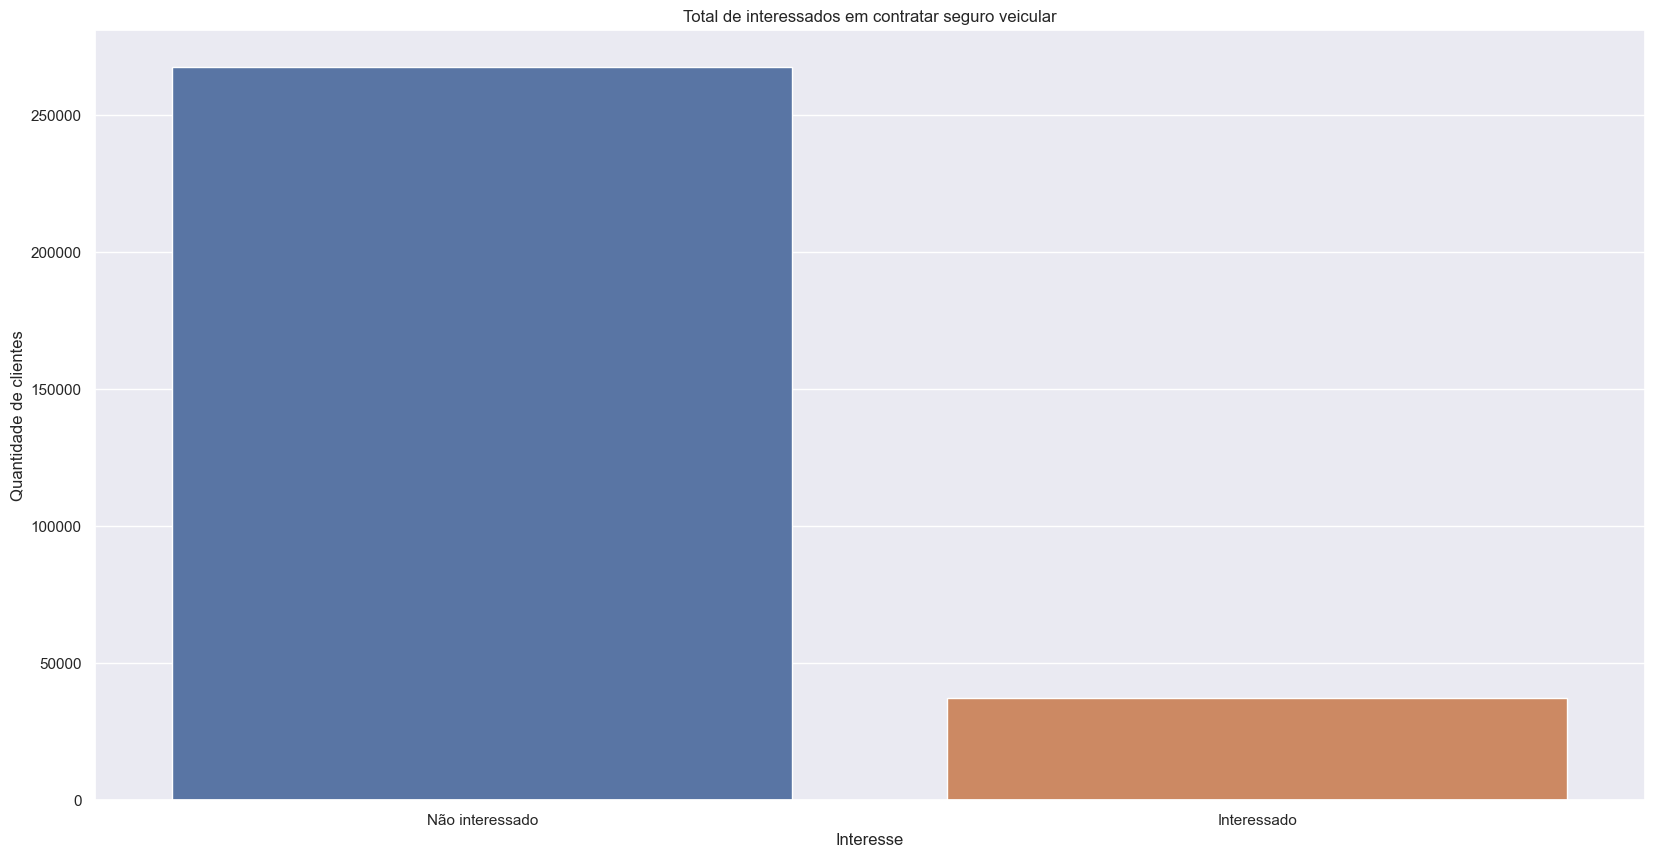

In [75]:
resp = sns.countplot(x = df4['interested'])
resp.set_ylabel('Quantidade de clientes')
resp.set_xlabel('Interesse')
resp.set_title("Total de interessados em contratar seguro veicular");

**OBS:** Alto desbalanceamento nos dados da variável resposta para classificação binária

In [72]:
df4['interested'].value_counts(normalize = True)

Não interessado   0.88
Interessado       0.12
Name: interested, dtype: float64

### 4.1.2. Numerical Variable

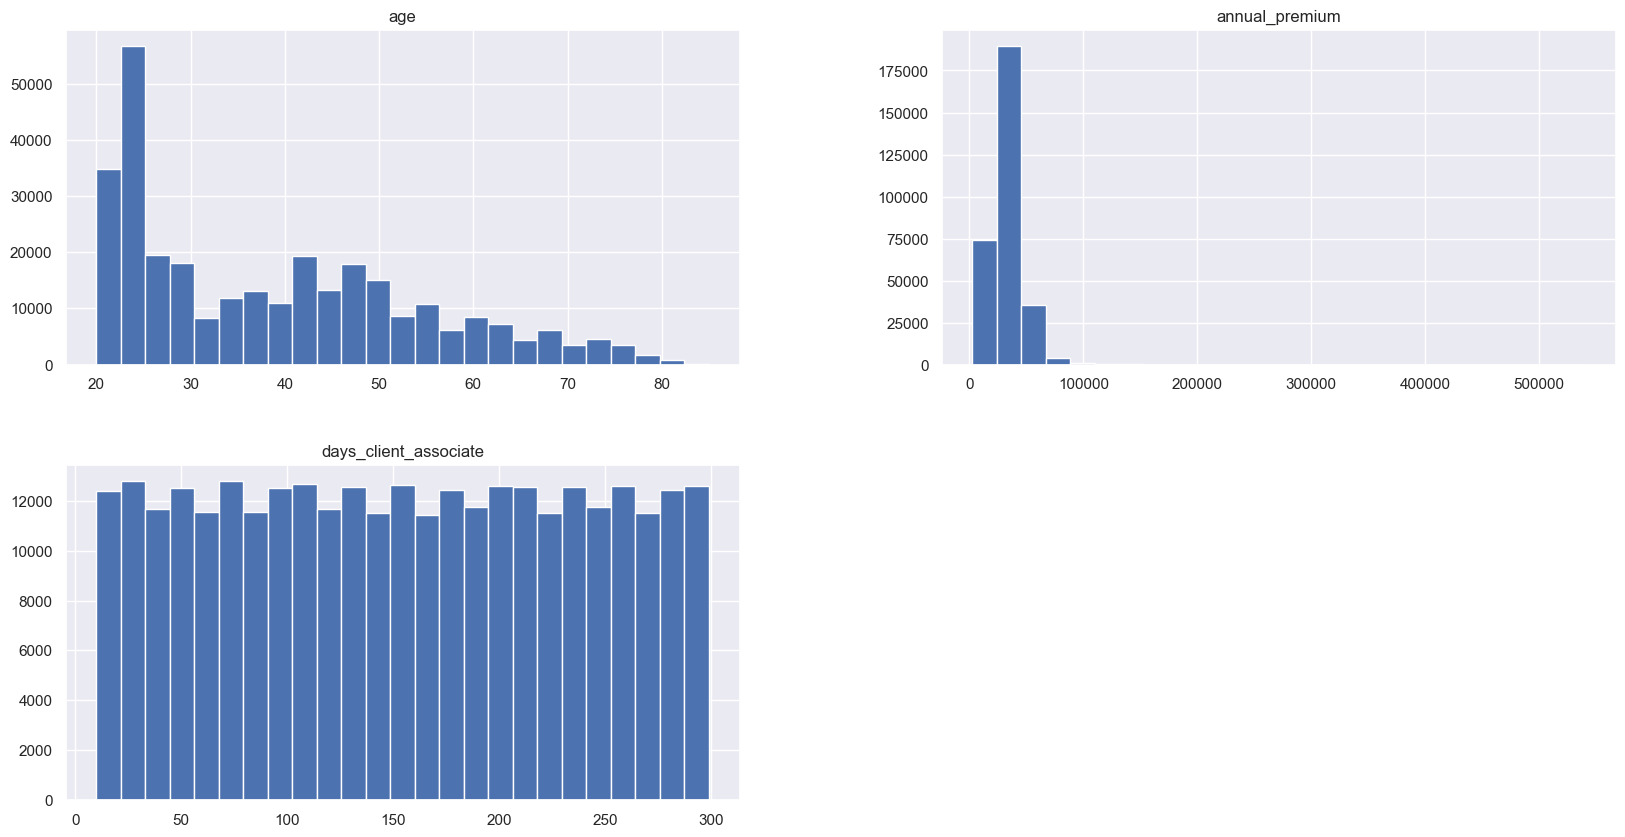

In [77]:
num_attributes_eda.hist( bins = 25 );

**Análises:**

*age:*
 
- Skew positiva indica que a distribuição dos valores está mais para a esquerda em relação a normal, ou seja, mais pessoas de 20 a 50 anos na base de seguro de saúde o que pode ser bastante surpreendente;
- Kurtosis negativa indica que a distribuição não possui uma alta concentração de valores em um determinado ponto, o que significa que está bem espalhado a distribuição dos dados entre as idades.

*days_client_associate:*

- Skew muito próxima de zero indica distribuição próxima da normal, ou seja, indica que a distribuição dos dados é simétrica;
- Kurtosis negativa indica que a distribuição não possui uma alta concentração de valores em um determinado ponto, o que significa que está bem espalhado a distribuição dos valores entre os clientes.

*annual_premium:*

- Skew positiva indica que a distribuição dos valores está mais para a esquerda em relação a normal, ou seja, mais clientes pagam prêmio entre 2.630,00 a 100.000,00 reais;
- Kurtosis bastante positiva indica que há deformação vertical devido a concentração dos dados sob um ponto.

#### 4.1.2.1. age

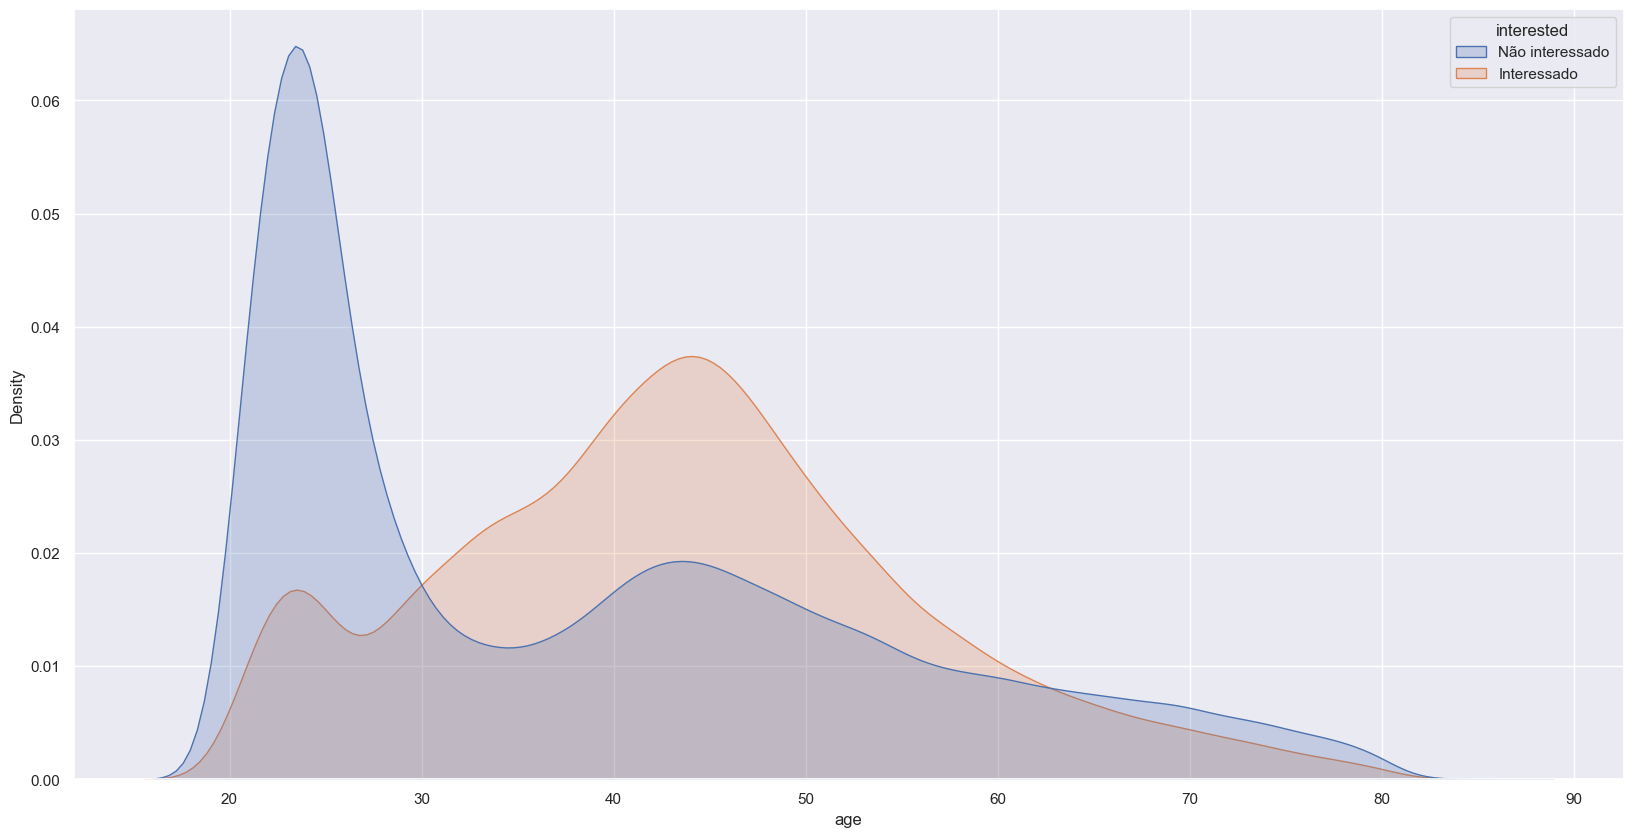

In [103]:
sns.kdeplot(data=df4 , x='age', hue='interested', fill=True, common_norm=False );

**Análise:**

- Mesma análise já feita em gráfico box-plot em 1.7.1. Aqui nota-se mais que existem interessados e não interessados ao longo de todas as idades 


#### 4.1.2.2. annual_premium

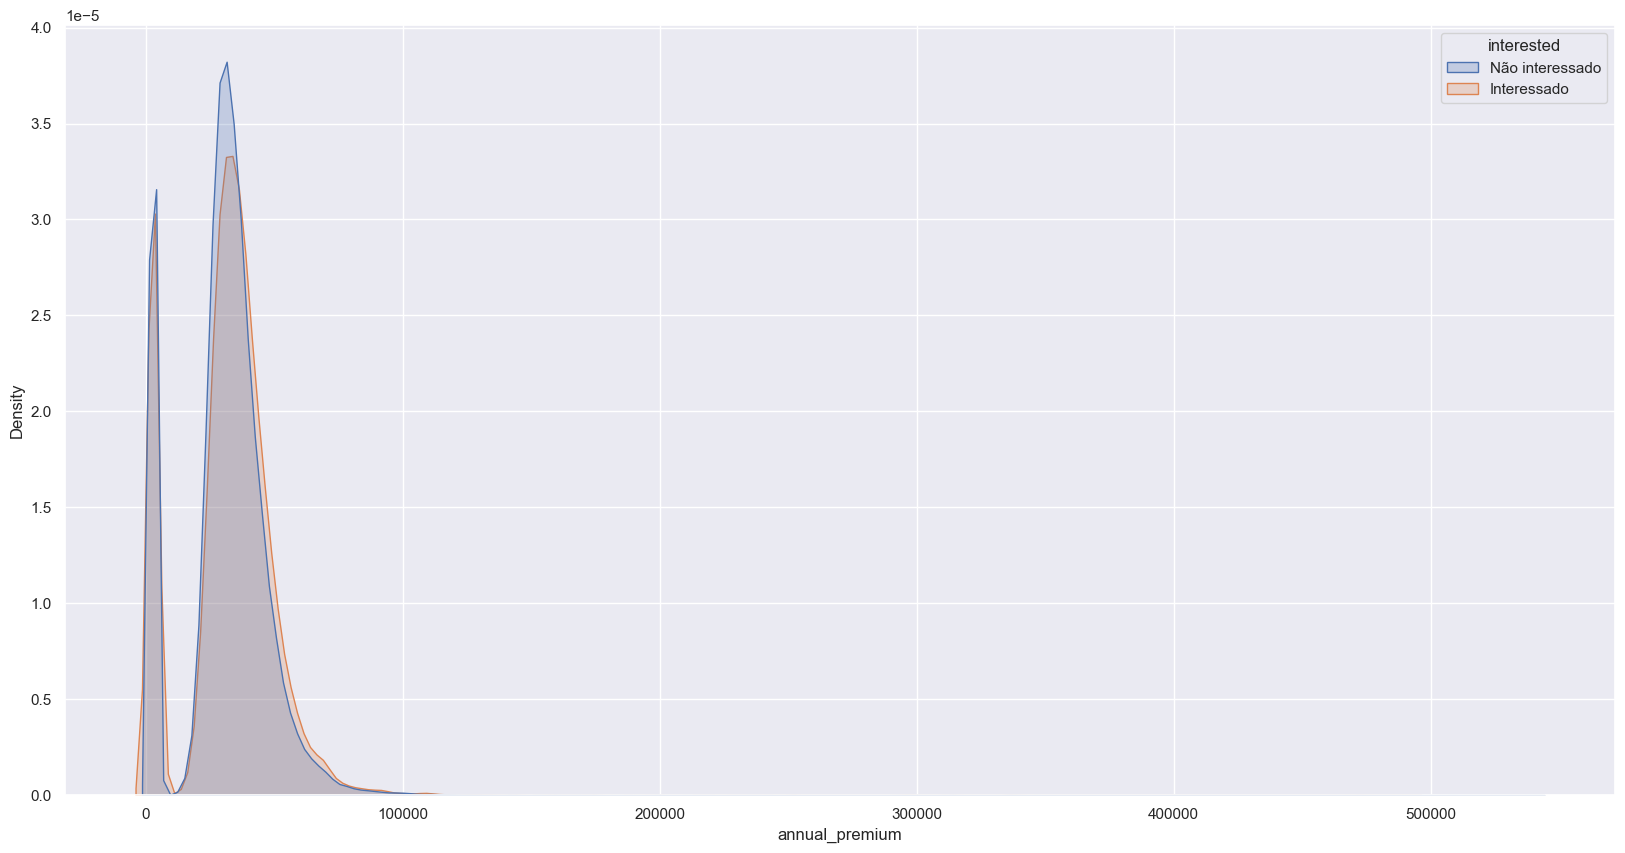

In [104]:
sns.kdeplot(data=df4 , x='annual_premium', hue='interested', fill=True, common_norm=False );

**Análise:**

- Mesma análise já feita em gráfico box-plot em 1.7.1.

#### 4.1.2.3. days_client_associate

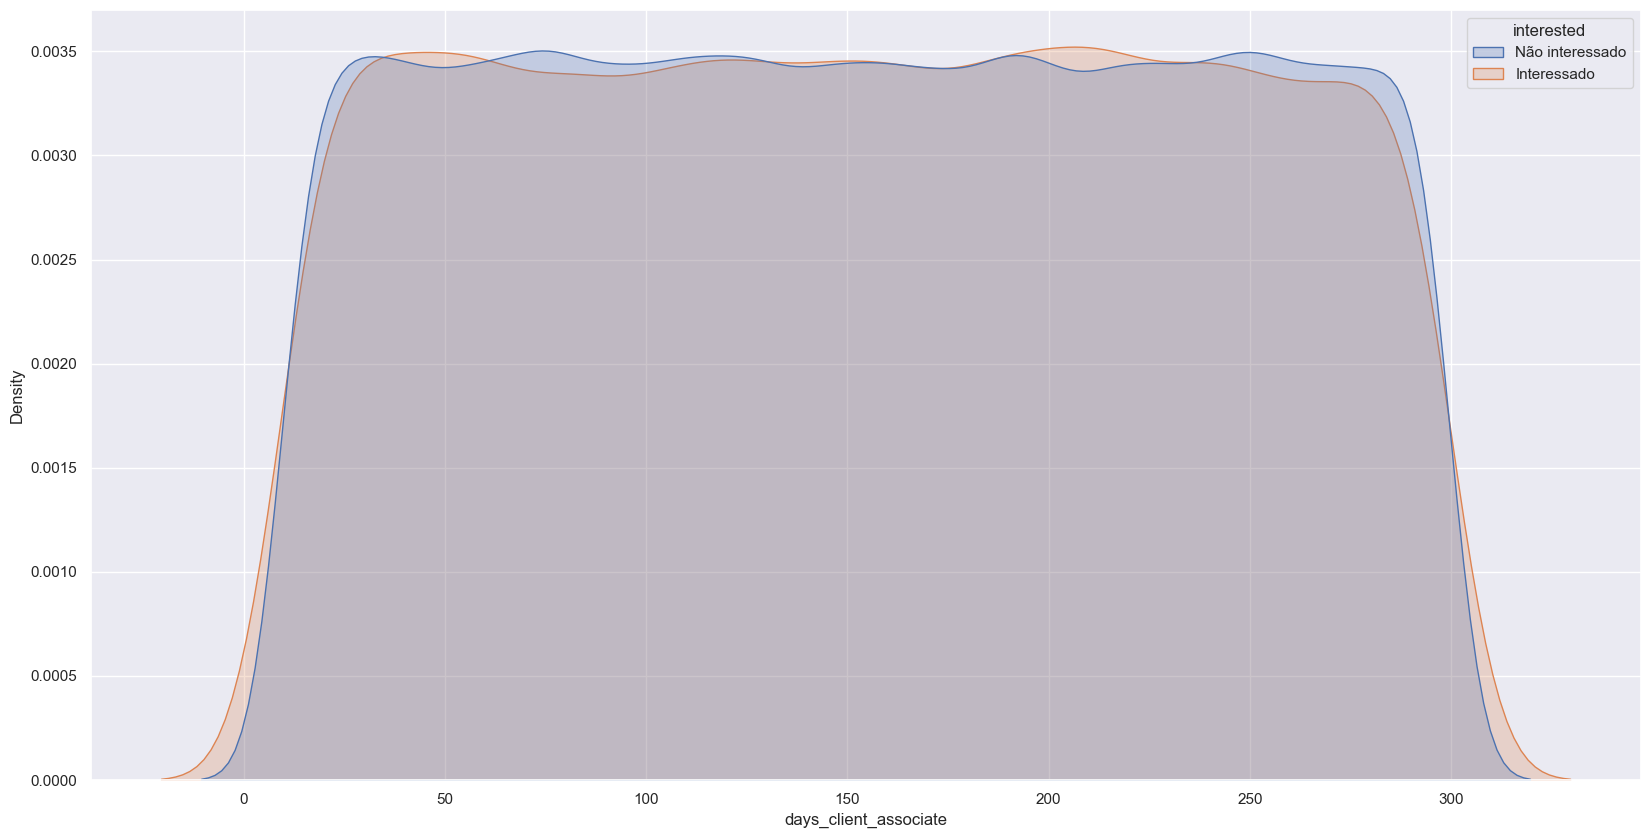

In [105]:
sns.kdeplot(data=df4 , x='days_client_associate', hue='interested', fill=True, common_norm=False );

**Análise:**

- Mesma análise já feita em gráfico box-plot em 1.7.1.

### 4.1.3. Categorical Variable

In [179]:
# Valores Únicos de cada uma das categorias 

print(f"Quantidade de valores únicos em cada atributo: \n \n { cat_attributes_eda.apply( lambda x: x.nunique() ) } \n")
print(f"Valores únicos em cada atributo: \n \n { cat_attributes_eda.apply( lambda x: x.unique() ) } " )

Quantidade de valores únicos em cada atributo: 
 
 gender                           2
region_code                     53
sales_channel                  154
driving_license                  2
vehicle_age                      3
vehicle_damage                   2
vehicle_insured                  2
age_level                        4
days_client_associate_level      3
annual_premium_level             7
dtype: int64 

Valores únicos em cada atributo: 
 
 gender                                                     [Masculino, Feminino]
region_code                    [40, 8, 28, 37, 1, 12, 13, 6, 50, 43, 25, 48, ...
sales_channel                  [152, 26, 122, 156, 13, 151, 160, 124, 8, 15, ...
driving_license                                  [Possui carteira, Sem carteira]
vehicle_age                    [Menos de 1 ano, Entre 1 e 2 anos, Mais de 2 a...
vehicle_damage                              [Foi danificado, Não foi danificado]
vehicle_insured                            [Não possui seguro

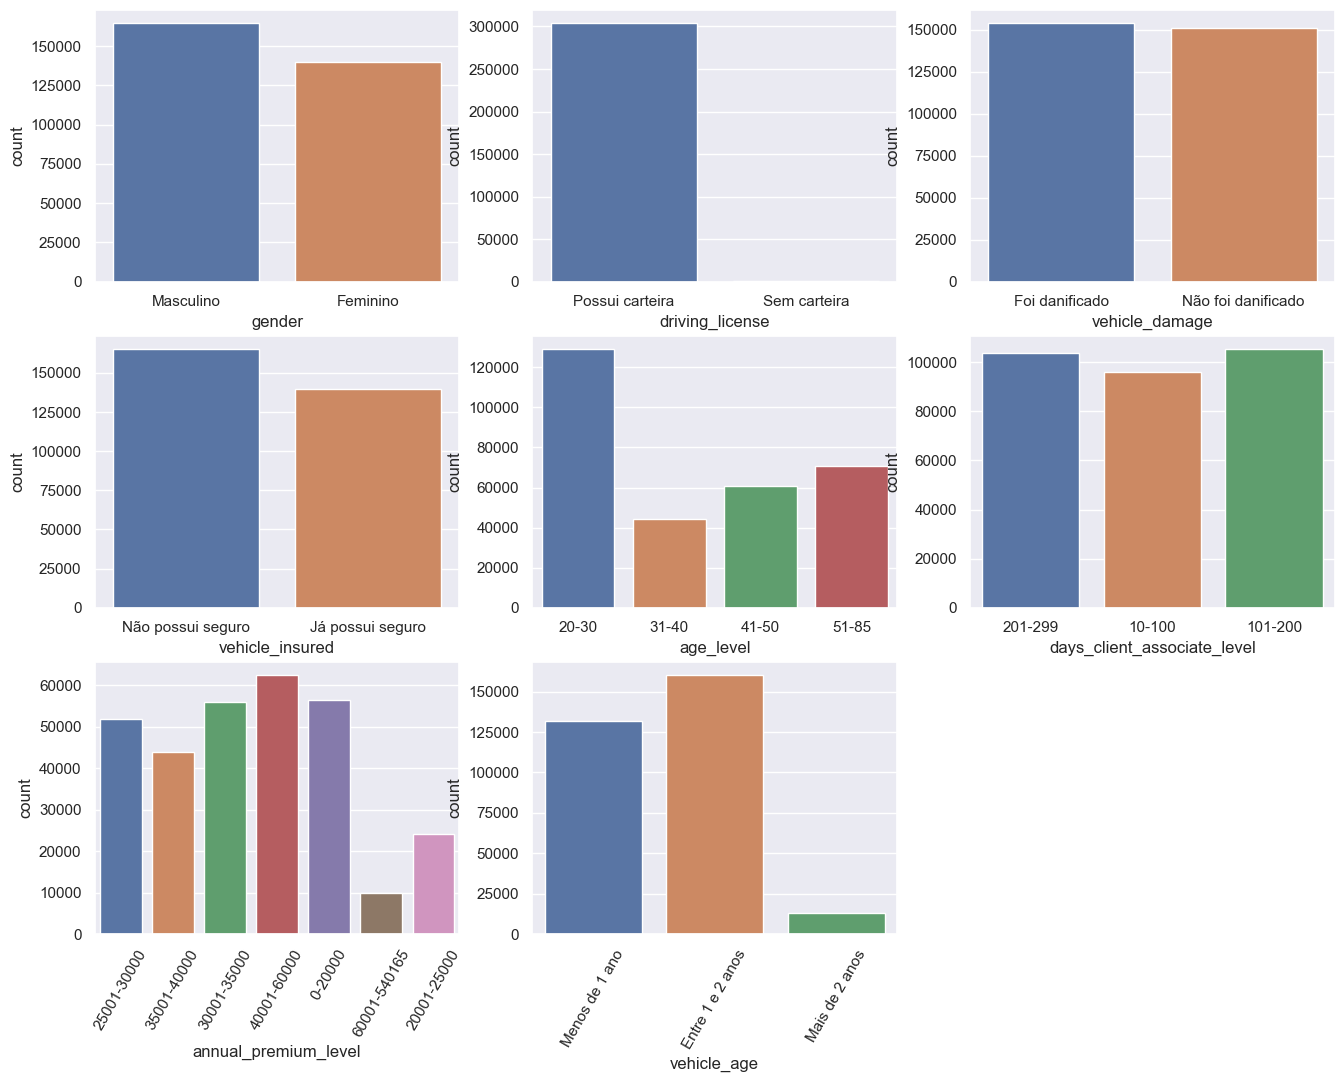

In [180]:
# Plot

plt.figure(figsize=(16,12))

plt.subplot (3,3,1)
sns.countplot (x = cat_attributes_eda['gender']);


plt.subplot (3,3,2)
sns.countplot (x = cat_attributes_eda['driving_license']);


plt.subplot (3,3,3)
sns.countplot (x = cat_attributes_eda['vehicle_damage']);


plt.subplot (3,3,4)
sns.countplot (x = cat_attributes_eda['vehicle_insured']);


plt.subplot (3,3,5)
sns.countplot (x = cat_attributes_eda['age_level']);


plt.subplot (3,3,6)
sns.countplot (x = cat_attributes_eda['days_client_associate_level']);


plt.subplot (3,3,7)
sns.countplot (x = cat_attributes_eda['annual_premium_level']);
plt.xticks(rotation = 60);


plt.subplot (3,3,8)
sns.countplot (x = cat_attributes_eda['vehicle_age']);
plt.xticks(rotation = 60);

**Análises:**


*gender:*
    
- Possuem mais homens do que mulheres na base de clientes, mas existe um equilíbrio(balanceamento) entre os valores.
    

*driving_license:*
    
- Alto desbalanceamento, muito mais pessoas que possuem permissão para dirigir do que as que não possuem.

    
*vehicle_age:*

- A base de clientes possui veículos em sua grande maioria com idade menor que 2 anos.


*vehicle_damage:*

- Possuem mais clientes que já danificaram o veículo do que os que não, mas existe um equilíbrio(balanceamento) entre os valores.

*vehicle_insured:*

- Possuem mais clientes que não possuem seguro em seus automóveis, mas existe um equilíbrio(balanceamento) entre os valores.

*age_level:*

- Mais clientes de 20 a 30 anos.

*days_client_associate_level:*

- 2/3 da base de pessoas são clientes a mais de 100 dias.

*annual_premium_level:*

- Alta concentração de clientes que paga prêmio anual do seguro de saúde entre mais de 25 mil até 60 mil.

In [ ]:
## Analisando separadamente o sales_channel e o region_code

#### 4.1.3.1. sales_channel

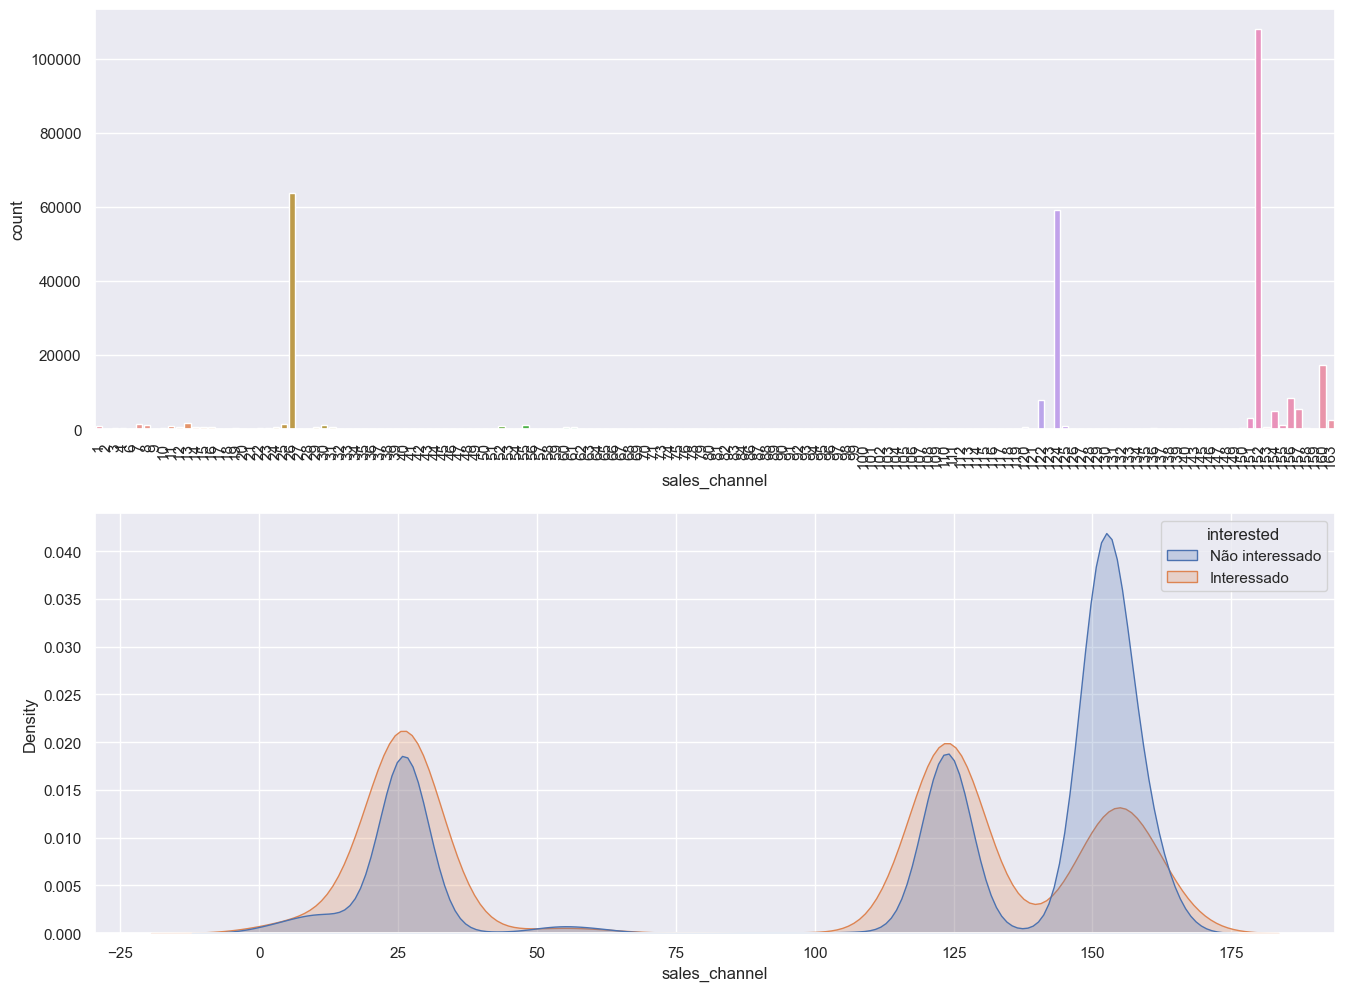

In [114]:
plt.figure(figsize=(16,12))

# Distribuição do canal de vendas
plt.subplot( 2, 1, 1 )
sns.countplot(x = df4['sales_channel']);
plt.xticks(rotation = 90);

# Análise da distribuição de interessados e não interessados por canal de vendas
plt.subplot( 2, 1, 2 )
sns.kdeplot(data= df4 , x='sales_channel', hue='interested', fill=True, common_norm=False );

**Análise:**

- Notavelmente existem 3 códigos de canal de vendas com o cliente que mais as pessoas utilizaram na venda: 26, 124 e 152. Aproximadamente mais de 220 mil clientes utilizaram apenas esses 3 canais de vendas para tratar com a empresa.

- A distribuição de interessados e não interessados por canal de vendas é muito sobreposta uma na outra.

#### 4.1.3.2. region_code

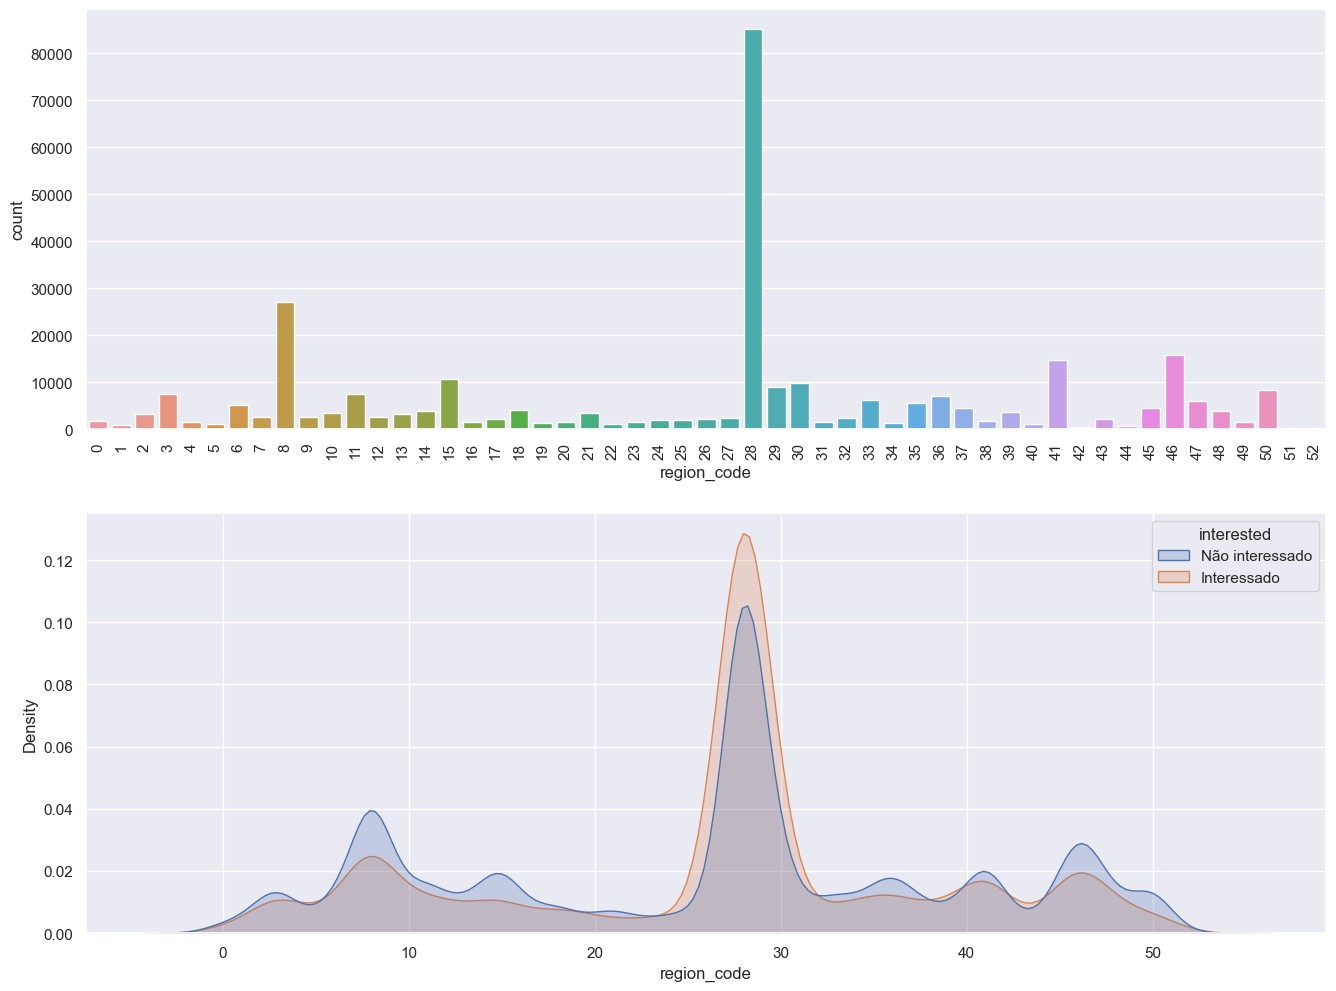

In [115]:
plt.figure(figsize=(16,12))

# Distribuição do código da região
plt.subplot( 2, 1, 1 )
sns.countplot(x = df4['region_code']);
plt.xticks(rotation = 90);

# Análise da distribuição de interessados e não interessados por código da região
plt.subplot( 2, 1, 2 )
sns.kdeplot(data= df4 , x='region_code', hue='interested', fill=True, common_norm=False );

**Análise:**

- O código de região que mais possue clientes é o 28 com mais de 80.000 clientes sendo dessa região. Depois vem a região 8 com quase aproximadamente 30.000 clientes da base. Por fim, existem 3 códigos de região com mais de 10.000 clientes que são: 15, 41, 46.

- Apesar da distribuição de interessados e não interessados por código da região ser muito sobreposta uma na outra, a região 28 concentra mais interessados do que não interessados na compra de seguro veicular.

## 4.2. Análise Bivariada

Validação das Hipóteses

In [12]:
## Voltar para conseguir contar os valores de interessados

df4.replace( {'interested': {'Interessado': 1,'Não interessado':0} }, inplace = True )  

### 4.2.1.  H1. Clientes com mais idade deveriam ter maior interesse, em média, na compra de seguro veicular. FALSO

Apesar de existir uma maior quantidade de clientes na base de seguro de saúde com idade entre 20 e 30 anos, a faixa de 31 a 50 anos possui o maior interesse dado o número proporcional de pessoas (médio), sendo esse superior a 20% nessa faixa.

**Conclusão:**

Gera Insight ? 


Pode ser relevante para o modelo? 

**Analisando quantidade de clientes por idade:**

Como já visto nas análises estatísticas e univariada, a distribuição do atributo idade do cliente é desigual, sendo assim, deve-se usar a média, proporção.  

**Analisando quantidade de clientes por idade e por interesse:**

<AxesSubplot: xlabel='age'>

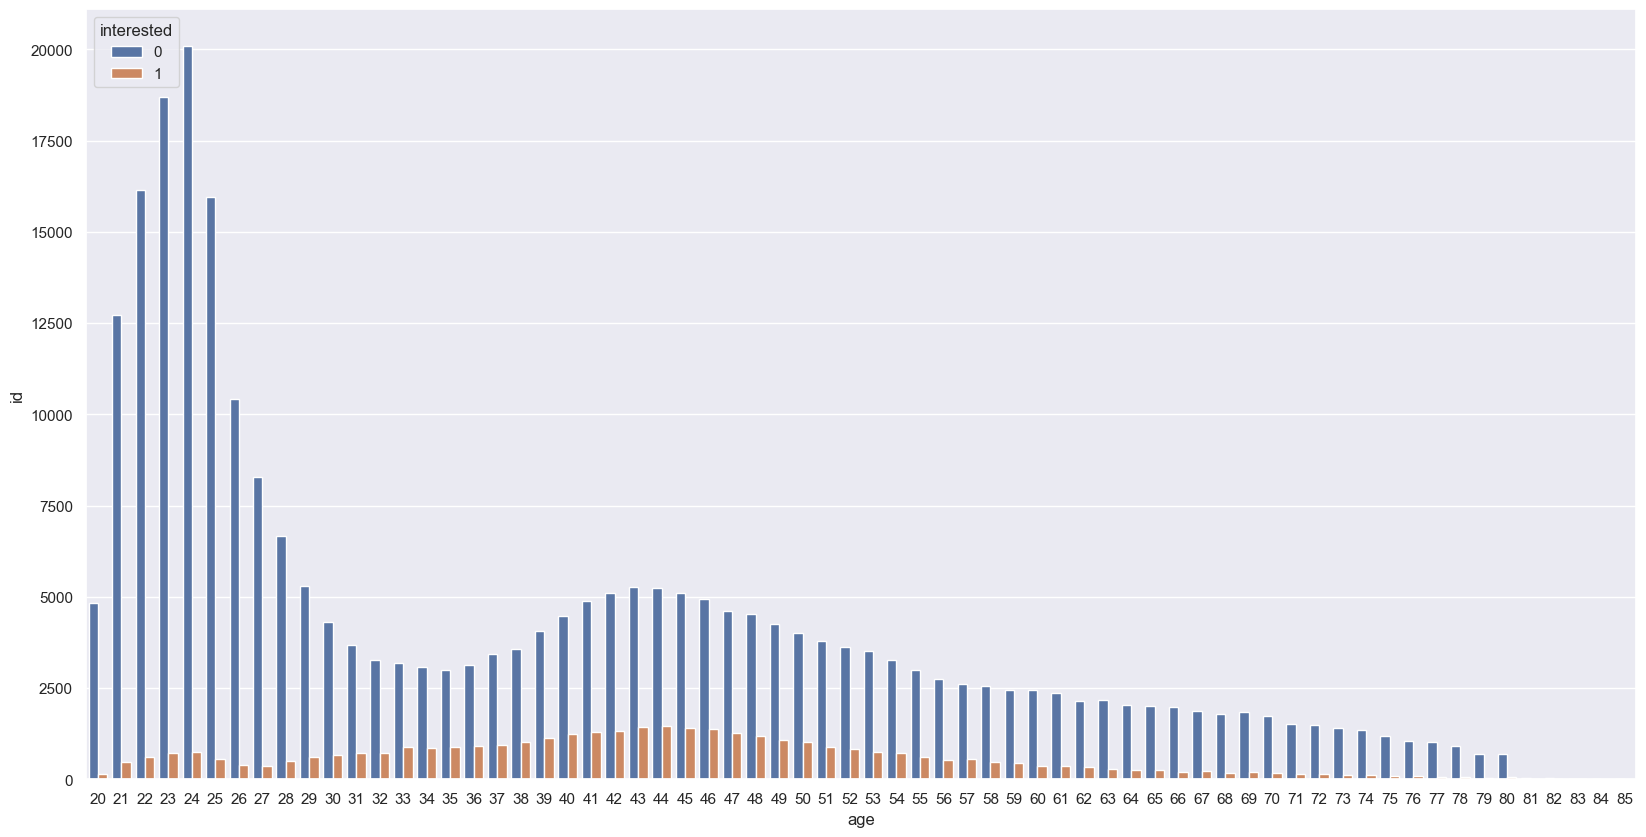

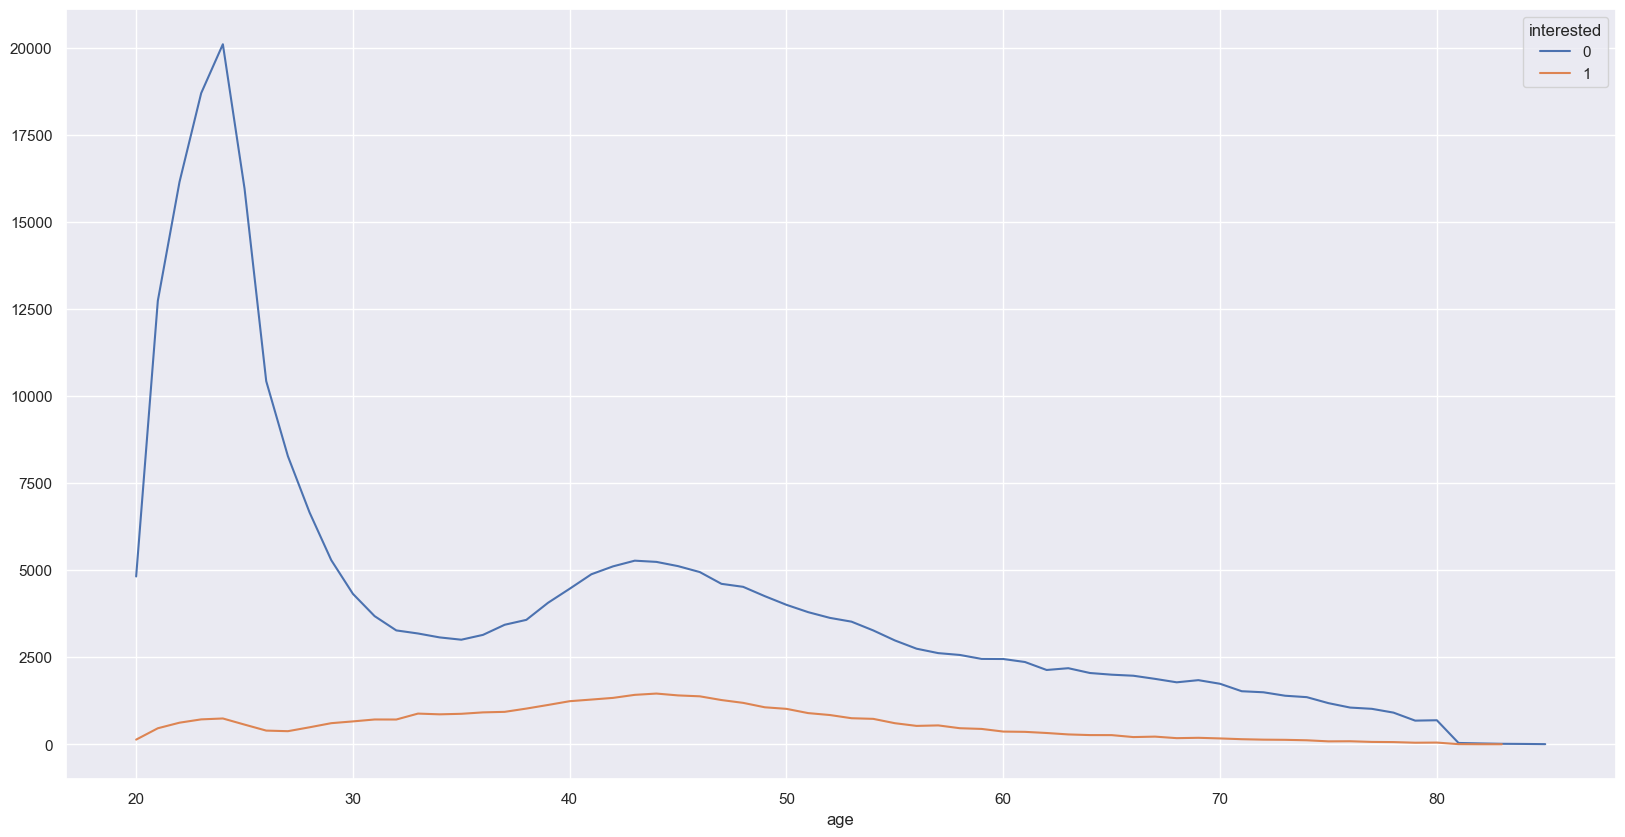

In [166]:
eda3 = df4[['age','id','interested']].groupby(['age','interested']).count().reset_index()

sns.barplot(x = 'age', y = 'id' , data = eda3, hue = 'interested' );


eda3.pivot_table(index = 'age' , columns = 'interested' , values = 'id' ).plot()

**Analisando cada idade e a proporção de interesse:**

<AxesSubplot: xlabel='age'>

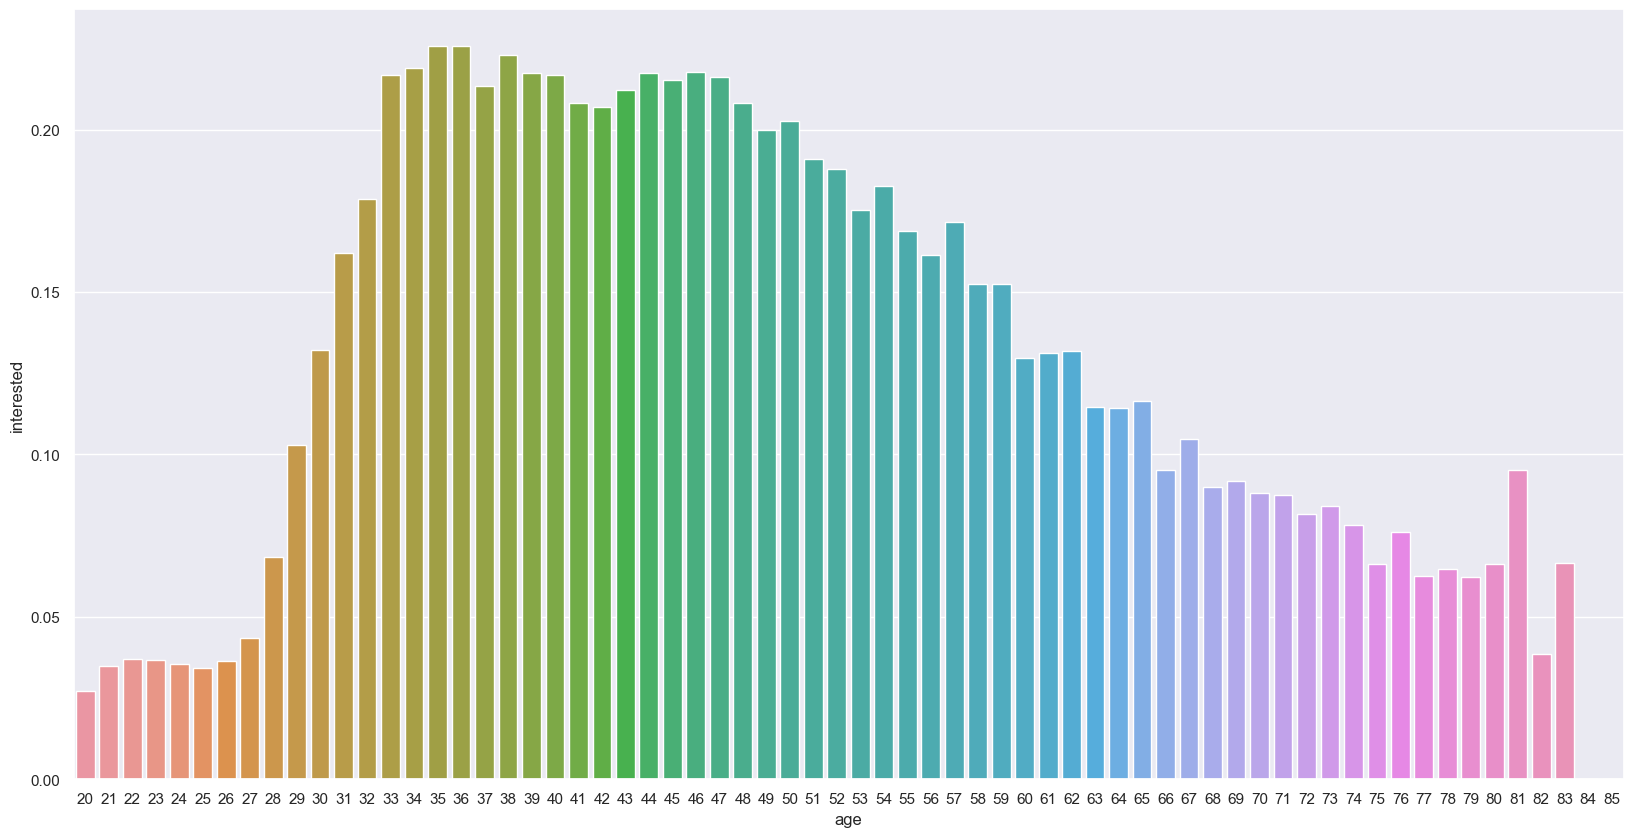

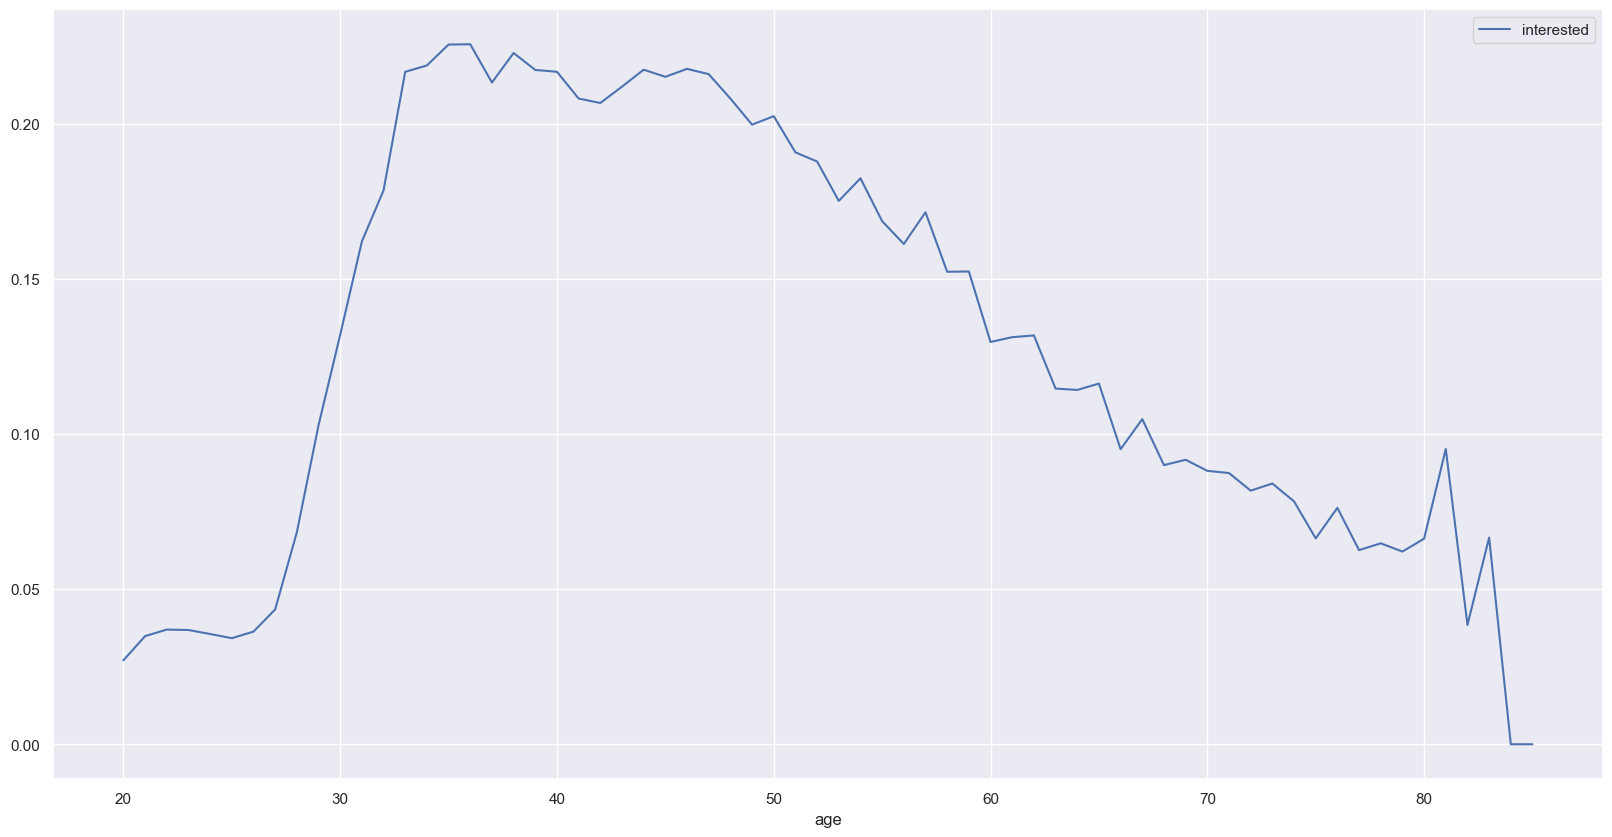

In [129]:
eda1 = df4[['age','interested']].groupby('age').mean().reset_index()

sns.barplot(x = 'age' , y= 'interested' , data = eda1)

df4[['age','interested']].groupby('age').mean().plot()

**Analisando idades agrupadas e os interesses:**

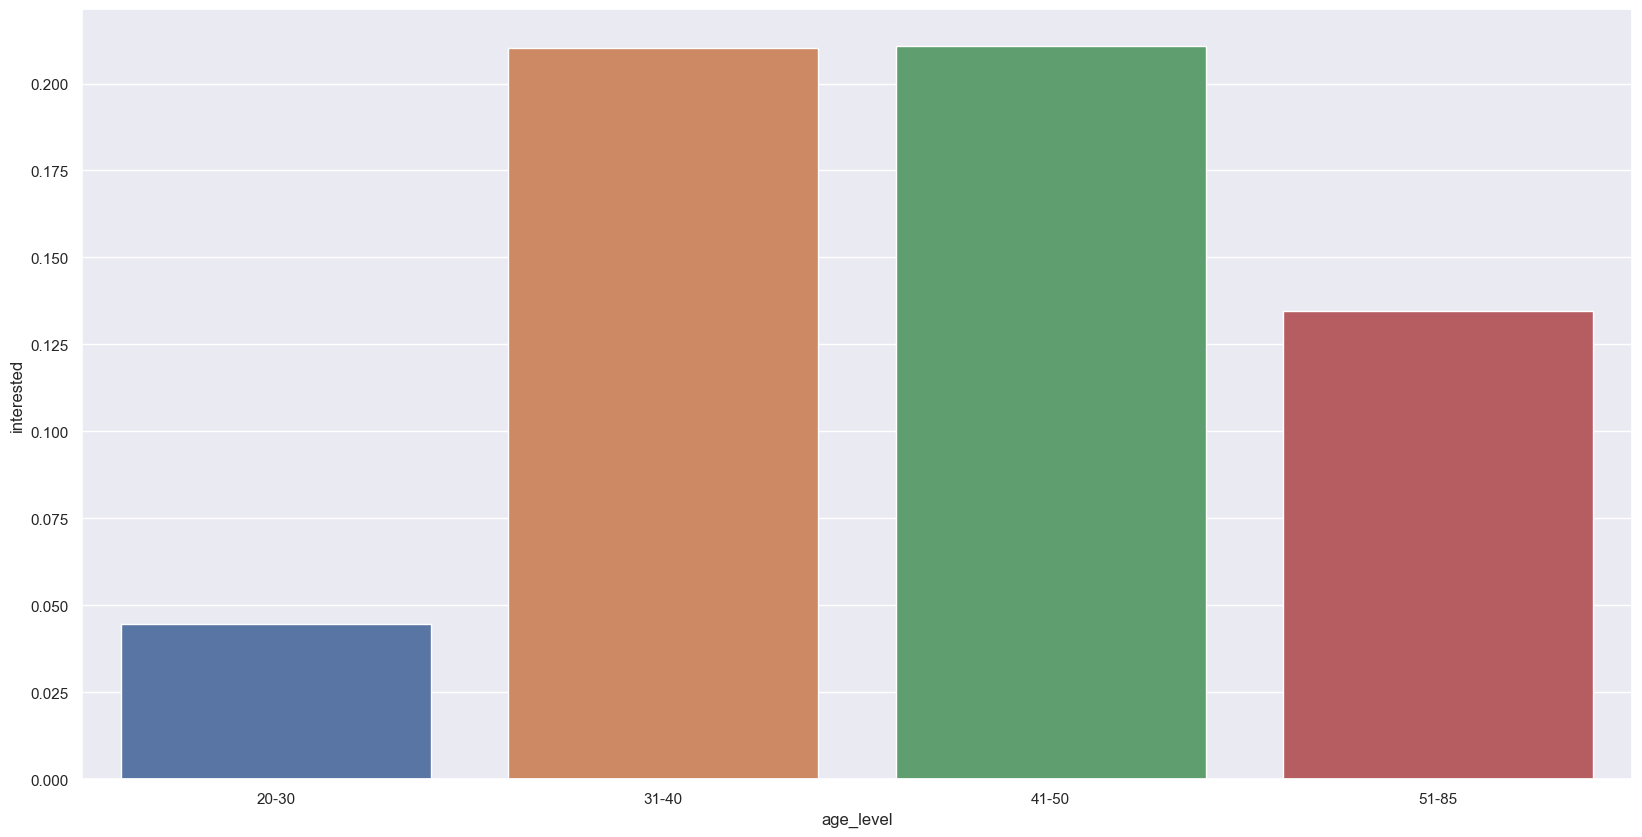

In [183]:
eda2 = df4[['age_level','interested']].groupby('age_level').mean().reset_index()

sns.barplot(x = 'age_level' , y= 'interested' , data = eda2);


### 4.2.2. H2. Clientes do gênero Masculino deveriam ter, em média, maior interesse na compra de seguro veicular. VERDADEIRO

O gênero masculino possui maior proporção de interesse em comprar seguro veicular do que o gênero feminino.



**Conclusão:**

Gera Insight ? 


Pode ser relevante para o modelo? 

**Analisando o interesse médio(proporcional) por genêro:**

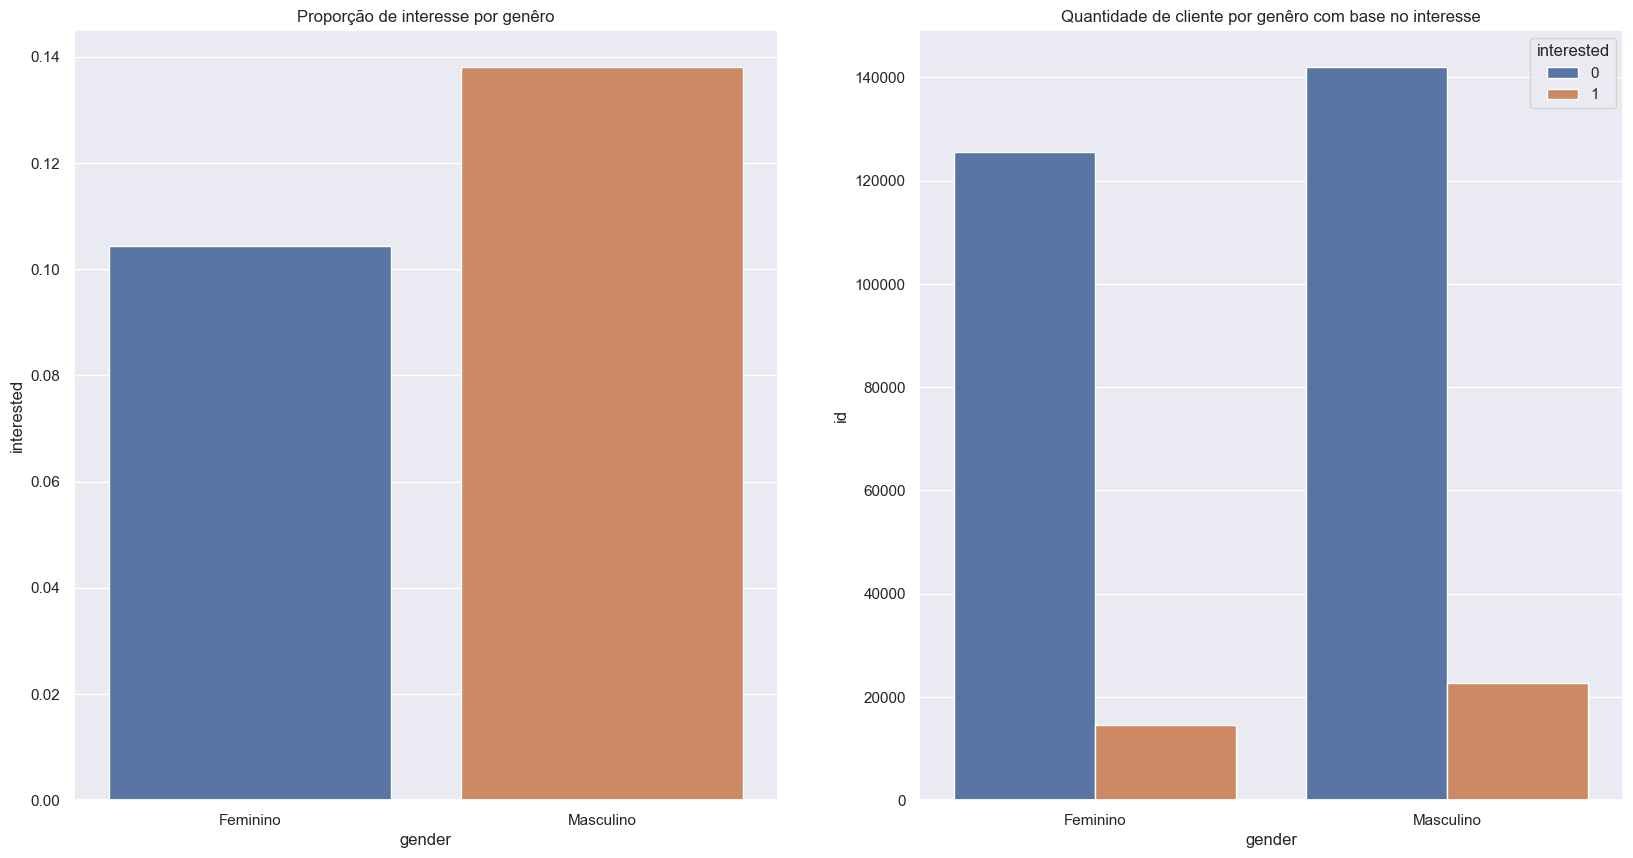

In [187]:
eda4 = df4[['gender', 'interested']].groupby('gender').mean().reset_index()
eda5 = df4[['gender', 'interested', 'id']].groupby(['gender','interested']).count().reset_index()


plt.subplot(1,2,1)
g1 = sns.barplot(x = 'gender' , y = 'interested' , data = eda4  );
g1.set_title('Proporção de interesse por genêro');

plt.subplot(1,2,2)
g2 = sns.barplot(x = 'gender' , y = 'id' , data = eda5, hue = 'interested'  );
g2.set_title('Quantidade de cliente por genêro com base no interesse');


**Análise da correlação através do V-Cramer:**

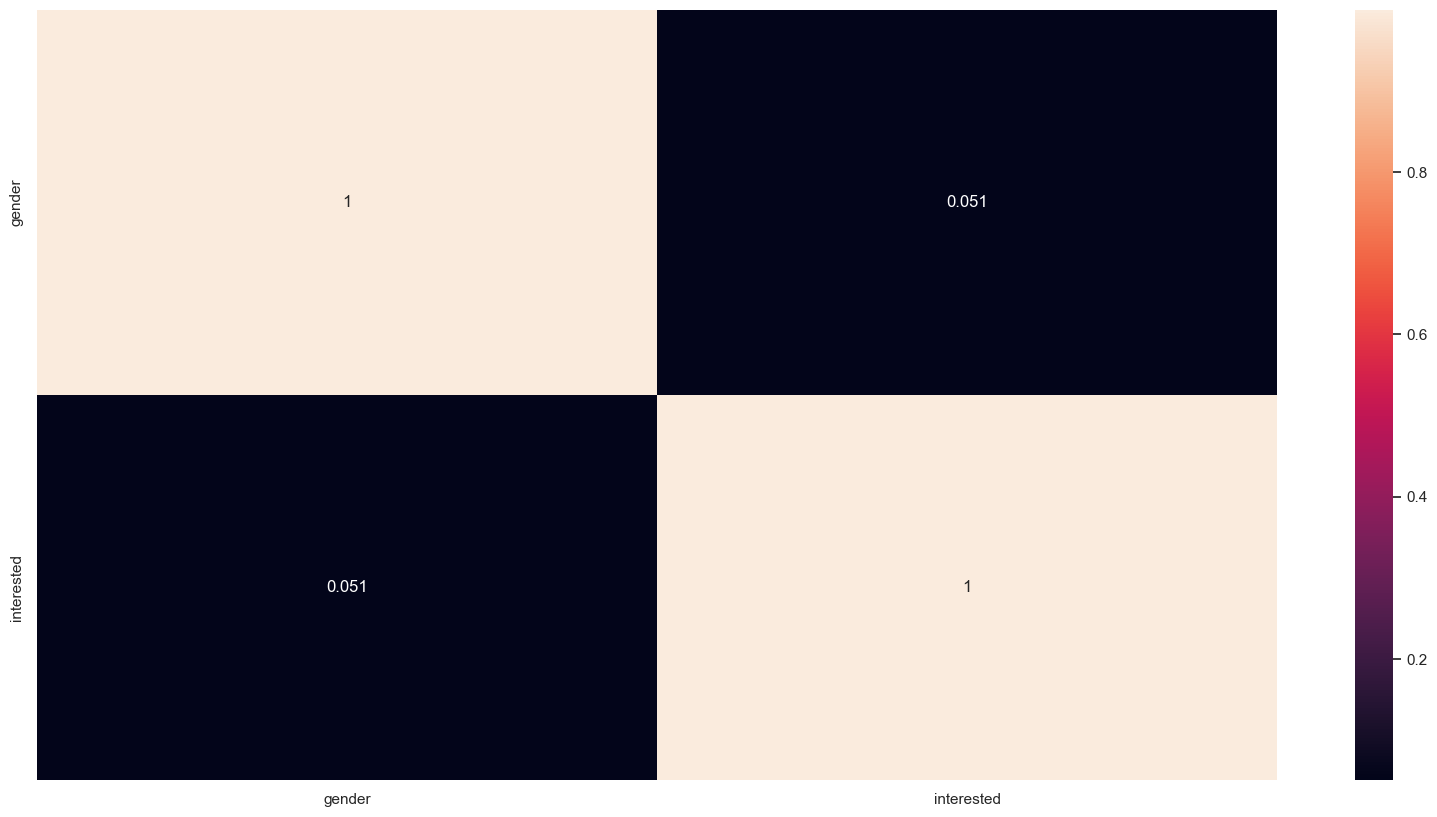

In [144]:
# Calculate cramer V
a1 = cramer_v( df4['gender'], df4['gender'] )
a2 = cramer_v( df4['gender'], df4['interested'] )

a3 = cramer_v( df4['interested'], df4['gender'] )
a4 = cramer_v( df4['interested'], df4['interested'] )


# Final dataset
d = pd.DataFrame( {'gender':     [a1, a2],
                   'interested': [a3, a4] } )
                   

d = d.set_index( d.columns )

sns.heatmap( d, annot=True );

**OBS:** Fraca correlação positiva

### 4.2.3. H3. Clientes da região 28 deveriam ter, proporcionalmente, maior interesse na compra de seguro veicular. FALSO

   
**Conclusão:**

Gera Insight ? 


Pode ser relevante para o modelo? 

**Expectativa:** Mediante análise aprofundada da distribuição de clientes por região e segmentada por interesse feita na Análise Univariada em 4.1.3.2., é esperado que a região com maior proporção de clientes interessados seja a 28.

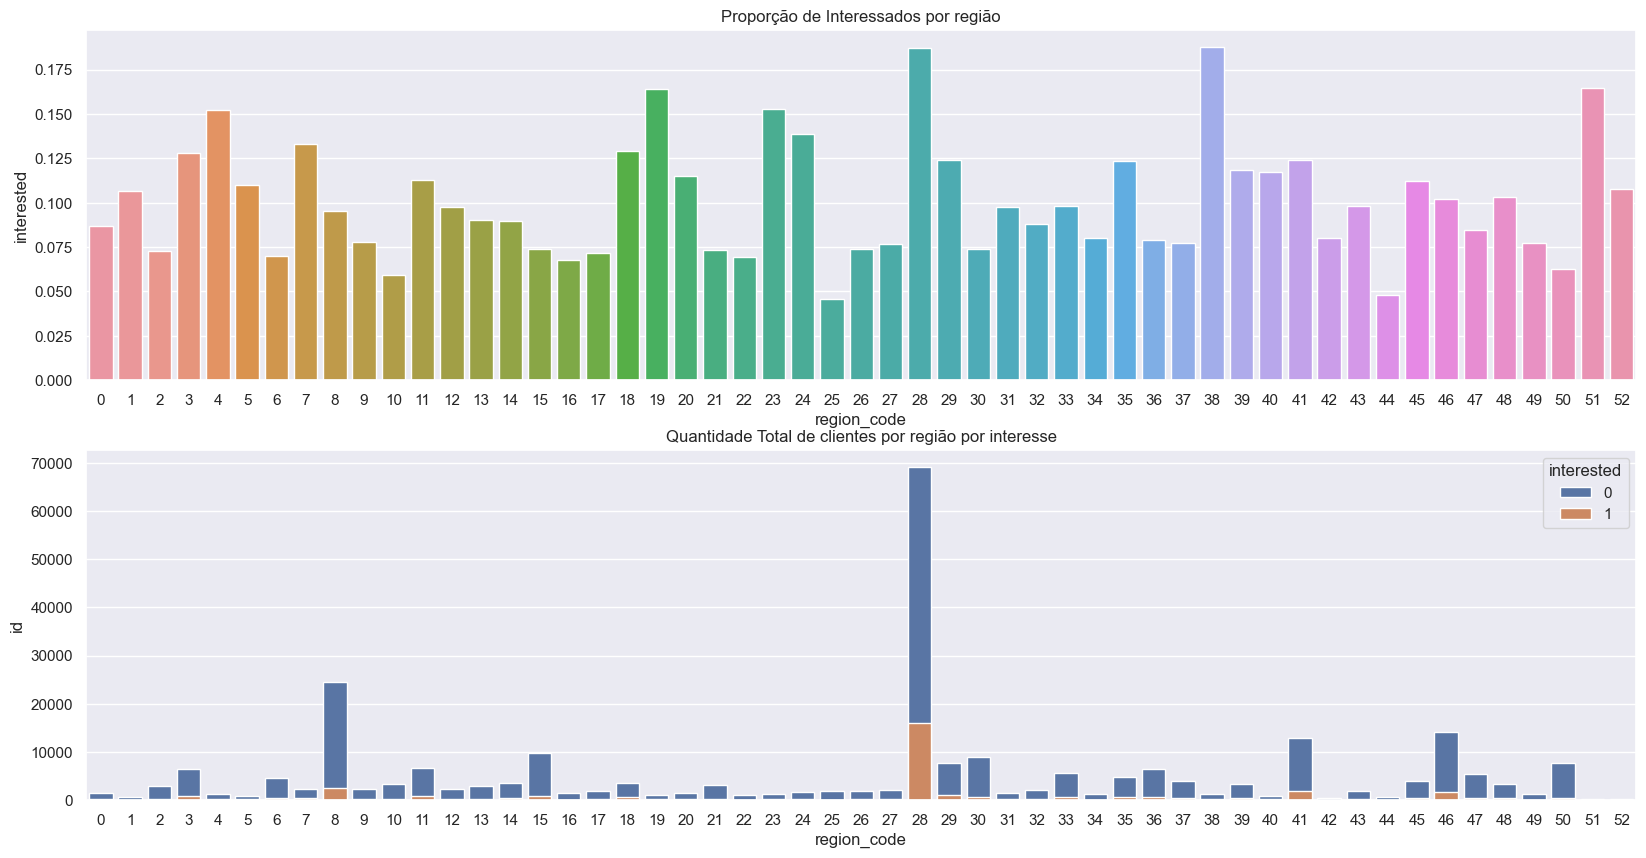

In [195]:
eda6 = df4[['region_code','interested']].groupby('region_code').mean().reset_index()
eda7 = df4[['region_code','interested','id']].groupby(['region_code', 'interested']).count().reset_index()

# Proporção
plt.subplot(2,1,1)
g3 = sns.barplot(x = 'region_code', y = 'interested' , data = eda6);
g3.set_title("Proporção de Interessados por região");

# Quantidade Total 
plt.subplot(2,1,2)
g4 = sns.barplot(x = 'region_code', y = 'id' , hue = 'interested', data = eda7, dodge = False);
g4.set_title("Quantidade Total de clientes por região por interesse");


**Conclusão:**
    
- Não só a região 28 possui a maior proporção de interessados na compra de seguro veicular, mas também a região 38. Contudo, a quantidade de clientes na base de dados dessa região é aproximadamente 41 vezes maior que a 38, impactando na quantidade total de clientes com interesse. Sendo assim, o foco deveria ser na 28 pela proporção x quantidade. 

- As regiões com bastante clientes na base como evidenciado em 4.1.3.2., na análise univariada, como 8, 15, 41 e 46 não tiveram uma proporção alta de interessados. Contudo, por terem bastante clientes na base dessas regiões, as regiões 8, 41 e 46 mesmo assim, se destacam na quantidade total de interessados logo atrás da 28. 

### 4.2.4. H4. Clientes com carteira de habilitação deveriam ter, proporcionalmente, maior interesse na compra de seguro veicular. 

### VERDADEIRO



**Conclusão:**

Gera Insight ? Não


Pode ser relevante para o modelo? Não

**Contexto:** Como já visto na análise univariada, praticamente a totalidade de clientes na base de dados disponível possui carteira, deve-se entender então, se a proporção de interessados é maior entre quem possui a carteira e quem não possui. 

In [149]:
df4['driving_license'].value_counts()

Possui carteira    304233
Sem carteira          654
Name: driving_license, dtype: int64

**Dashboard:**

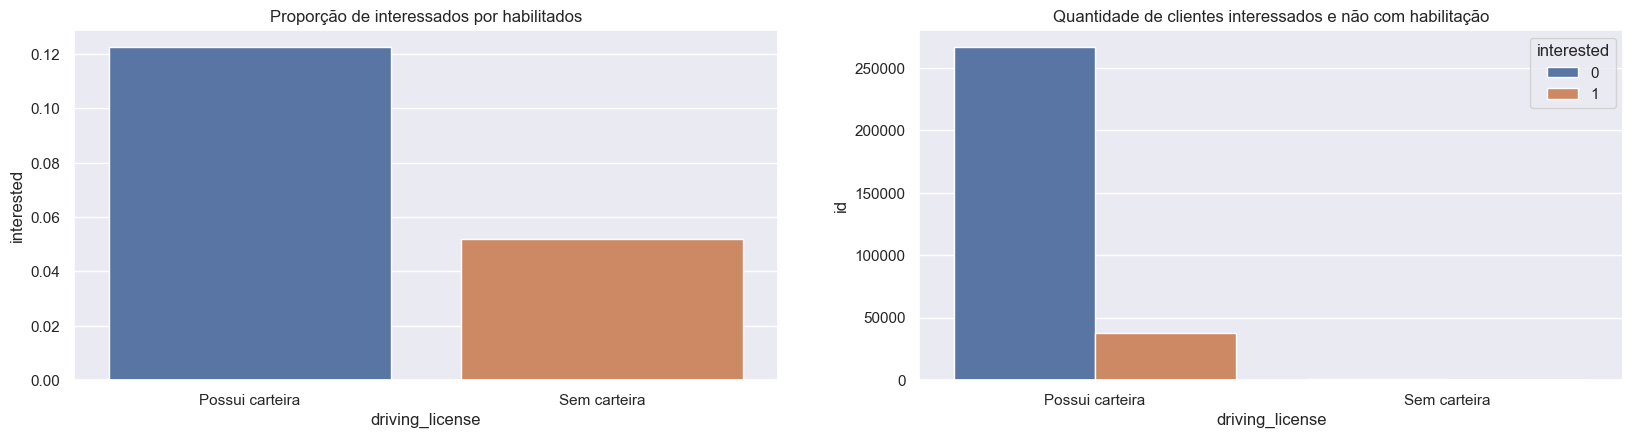

In [194]:
eda8 = df4[['driving_license','interested']].groupby('driving_license').mean().reset_index()
eda9 = df4[['driving_license','interested','id']].groupby( ['driving_license','interested'] ).count().reset_index()

plt.subplot(2,2,1)
g3 = sns.barplot(x = 'driving_license' , y = 'interested', data = eda8);
g3.set_title("Proporção de interessados por habilitados");

plt.subplot(2,2,2)
g4 = sns.barplot(x = 'driving_license' , y = 'id', hue = 'interested', data = eda9);
g4.set_title("Quantidade de clientes interessados e não com habilitação");

**Análise da correlação através do V-Cramer:**

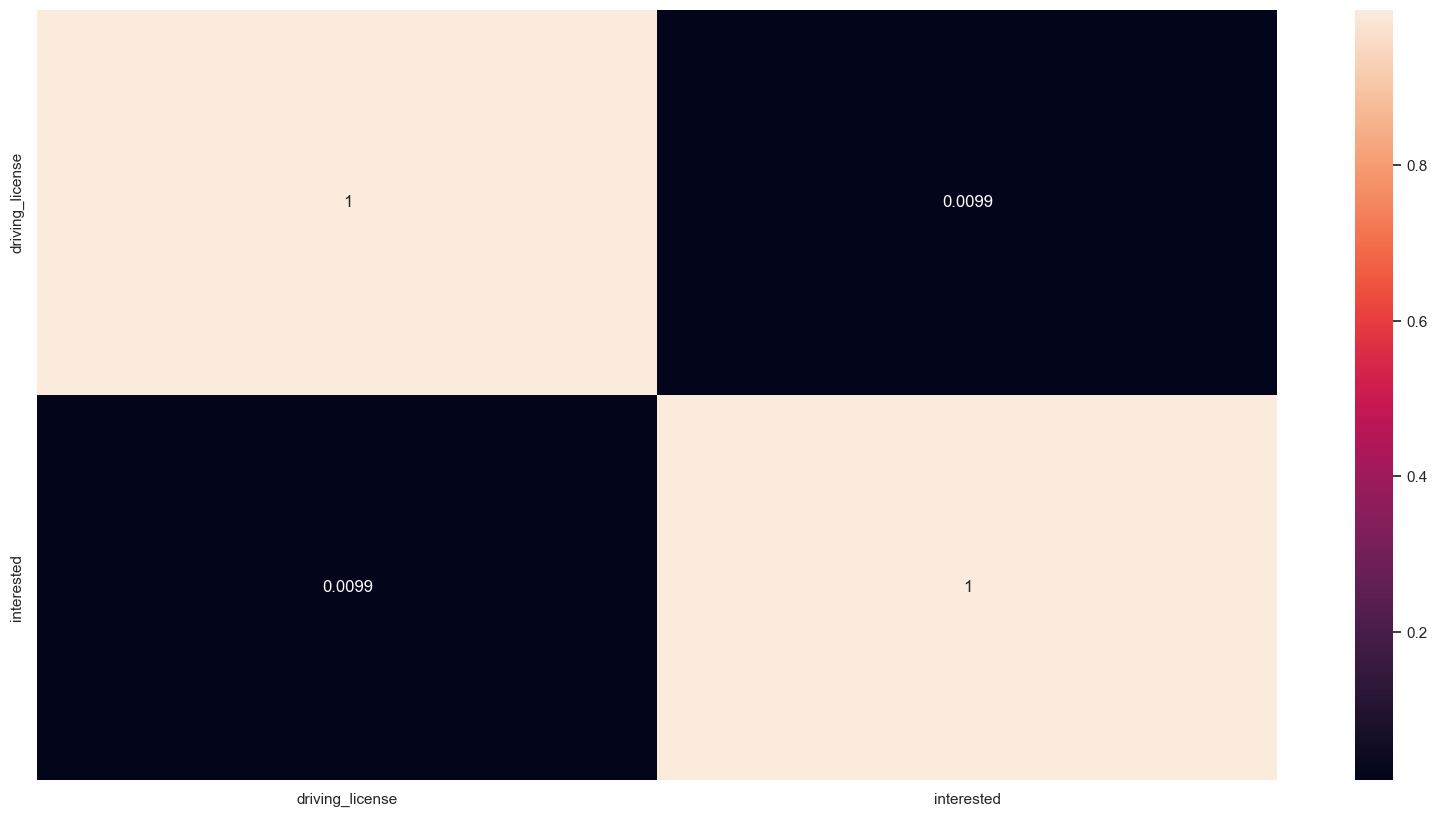

In [156]:
# Calculate cramer V
a1 = cramer_v( df4['driving_license'], df4['driving_license'] )
a2 = cramer_v( df4['driving_license'], df4['interested'] )

a3 = cramer_v( df4['interested'], df4['driving_license'] )
a4 = cramer_v( df4['interested'], df4['interested'] )


# Final dataset
d = pd.DataFrame( {'driving_license': [a1, a2],
                   'interested':      [a3, a4] } )
                   
d = d.set_index( d.columns )

# Mapa de calor
sns.heatmap( d, annot=True );

**Conclusão:**

- A proporção de clientes com carteira e interessados é maior que a sem carteira. E como a quantidade de clientes com carteira é maior que sem carteira, a quantidade total de interessados com carteira é maior do que sem carteira.

- Correlação via cálculo V-Cramer é fraca positiva.

### 4.2.5. H5. Clientes com canal de vendas utilizado sendo de 130 a 140 deveriam ter, em média, maior interesse na compra de seguro veicular. FALSO



Gera Insight ?

Pode ser relevante para o modelo?

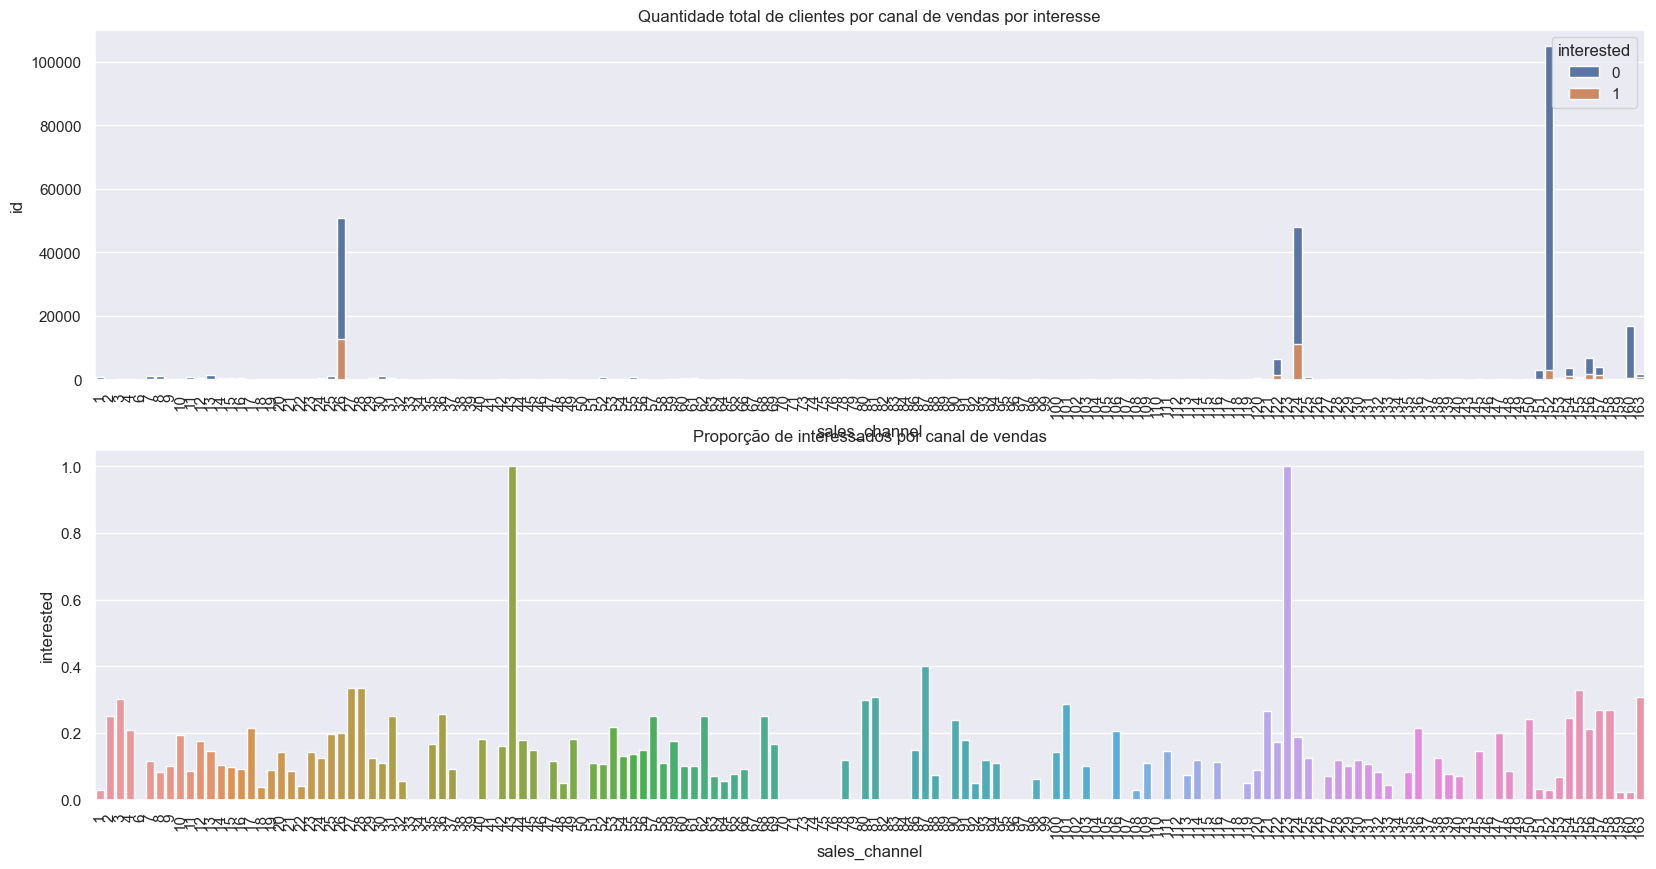

In [196]:
eda10 = df4[['sales_channel','interested','id']].groupby(['sales_channel','interested']).count().reset_index()
eda11 = df4[['sales_channel','interested']].groupby('sales_channel').mean().reset_index()


# Quantidade de clientes de cada canal - semelhante ao feito na análise univariada
plt.subplot(2,1,1)
g5 = sns.barplot(x = 'sales_channel', y = 'id', hue = 'interested', data = eda10, dodge = False);
g5.set_title("Quantidade total de clientes por canal de vendas por interesse");
plt.xticks(rotation = 90);


# Proporção de clientes interessados de cada canal
plt.subplot(2,1,2)
g6 = sns.barplot(x = 'sales_channel', y = 'interested', data = eda11);
g6.set_title("Proporção de interessados por canal de vendas");
plt.xticks(rotation = 90);

**Conclusão:**
    
- Analisando apenas o indicador proporção de clientes interessados por canal, os canais 43, 123 e 87 possuem maiores proporções de interessados. Porém, como esses canais não possuem uma quantidade elevada de clientes na base de dados, ao analisar efetivamente a quantidade de interessados por canal, canais com proporções menores de interesse por cliente por terem mais clientes acabam tendo um número maior de interessados, que é o caso do canal 26, 124 e 152.  

- Interessante notar que o canal 152 possui em quantidade de clientes, a quantidade somada do 26 e 124, porém como a proporção de interesse do canal 152 é tão baixa, ele possui menos interessados que os outros canais 26 e 124 mesmo tendo menos clientes advindos desse canal. 

### 4.2.6. H6. Clientes que pagam prêmio por seguro de saúde entre 2.630,00 e 20.000,00 reais deveriam ter maior interesse na compra de seguro veicular.

**Conclusão:**

Gera Insight ? Não gera tanta surpresa e não desfaz crença.


Pode ser relevante para o modelo? Pode

In [ ]:
# Estratégia:
# 1. Analisar com quantidade de clientes por prêmio que paga e o interesse 
#        - gráfico de barras
#        - gráfico de linhas
# 2. Analisar a proporção de interessados que paga diferentes prêmios anuais    
#        - gráfico de barras
#        - gráfico de linhas
#    
# 3. Analisar a proporção de interessados por faixa de prêmios anuais
#         - gráfico de barras

In [ ]:
# 1

eda12 = df4[['annual_premium', 'interested','id']].groupby(['annual_premium','interested']).count().reset_index()

sns.barplot(x = 'annual_premium', y = 'id', data = eda12 , hue = 'interested' , dodge = False );


eda12.pivot_table(index = 'annual_premium', columns = 'interested', values = 'id').plot()

In [ ]:
print('hello')

### 4.2.7. H7. Clientes com automóvel mais novo deveriam ter maior interesse na compra de seguro veicular.


**Conclusão:**

Gera Insight ? Não gera tanta surpresa e não desfaz crença.


Pode ser relevante para o modelo? Pode

### 4.2.8. H8. Clientes com automóvel já danificado deveriam ter menor interesse na compra de seguro veicular.


**Conclusão:**

Gera Insight ? Não gera tanta surpresa e não desfaz crença.


Pode ser relevante para o modelo? Pode

### 4.2.9. H9. Clientes com automóvel que já possui seguro deveriam ter menor interesse na compra de seguro veicular.


**Conclusão:**

Gera Insight ? Não gera tanta surpresa e não desfaz crença.


Pode ser relevante para o modelo? Pode

### 4.2.10. H10. Clientes que estão a mais tempo com a empresa recebendo seguro de saúde deveriam ter maior interesse na compra de seguro veicular.



**Conclusão:**

Gera Insight ? Gera surpresa e desfaz crença.


Pode ser relevante para o modelo? Não

### 4.2.13. Resumo

In [95]:
tab = [["Hipóteses","Conclusão","Relevância"],
       ["H1","Verdadeiro","Alta"],
       ["H2","Falso","Baixa"],
       ["H3","Verdadeiro","Alta"],
       ["H4","Verdadeiro","Baixa"],
       ["H5","---","---"],
       ["H6","Verdadeiro","Média"],
       ["H7","Falso","Média"],
       ["H8","Verdadeiro","Alta"],
       ["H9","Verdadeiro","Média"],
       ["H10","Falso","Baixa"],
       ["H11","Verdadeiro","Baixa"],
       ["H12","Falso","Baixa"]]






print( tabulate(tab, headers = 'firstrow') )

Hipóteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Verdadeiro   Alta
H2           Falso        Baixa
H3           Verdadeiro   Alta
H4           Verdadeiro   Baixa
H5           ---          ---
H6           Verdadeiro   Média
H7           Falso        Média
H8           Verdadeiro   Alta
H9           Verdadeiro   Média
H10          Falso        Baixa
H11          Verdadeiro   Baixa
H12          Falso        Baixa


## 4.3. Análise Multivariada

### 4.3.1. Numerical Attributes 

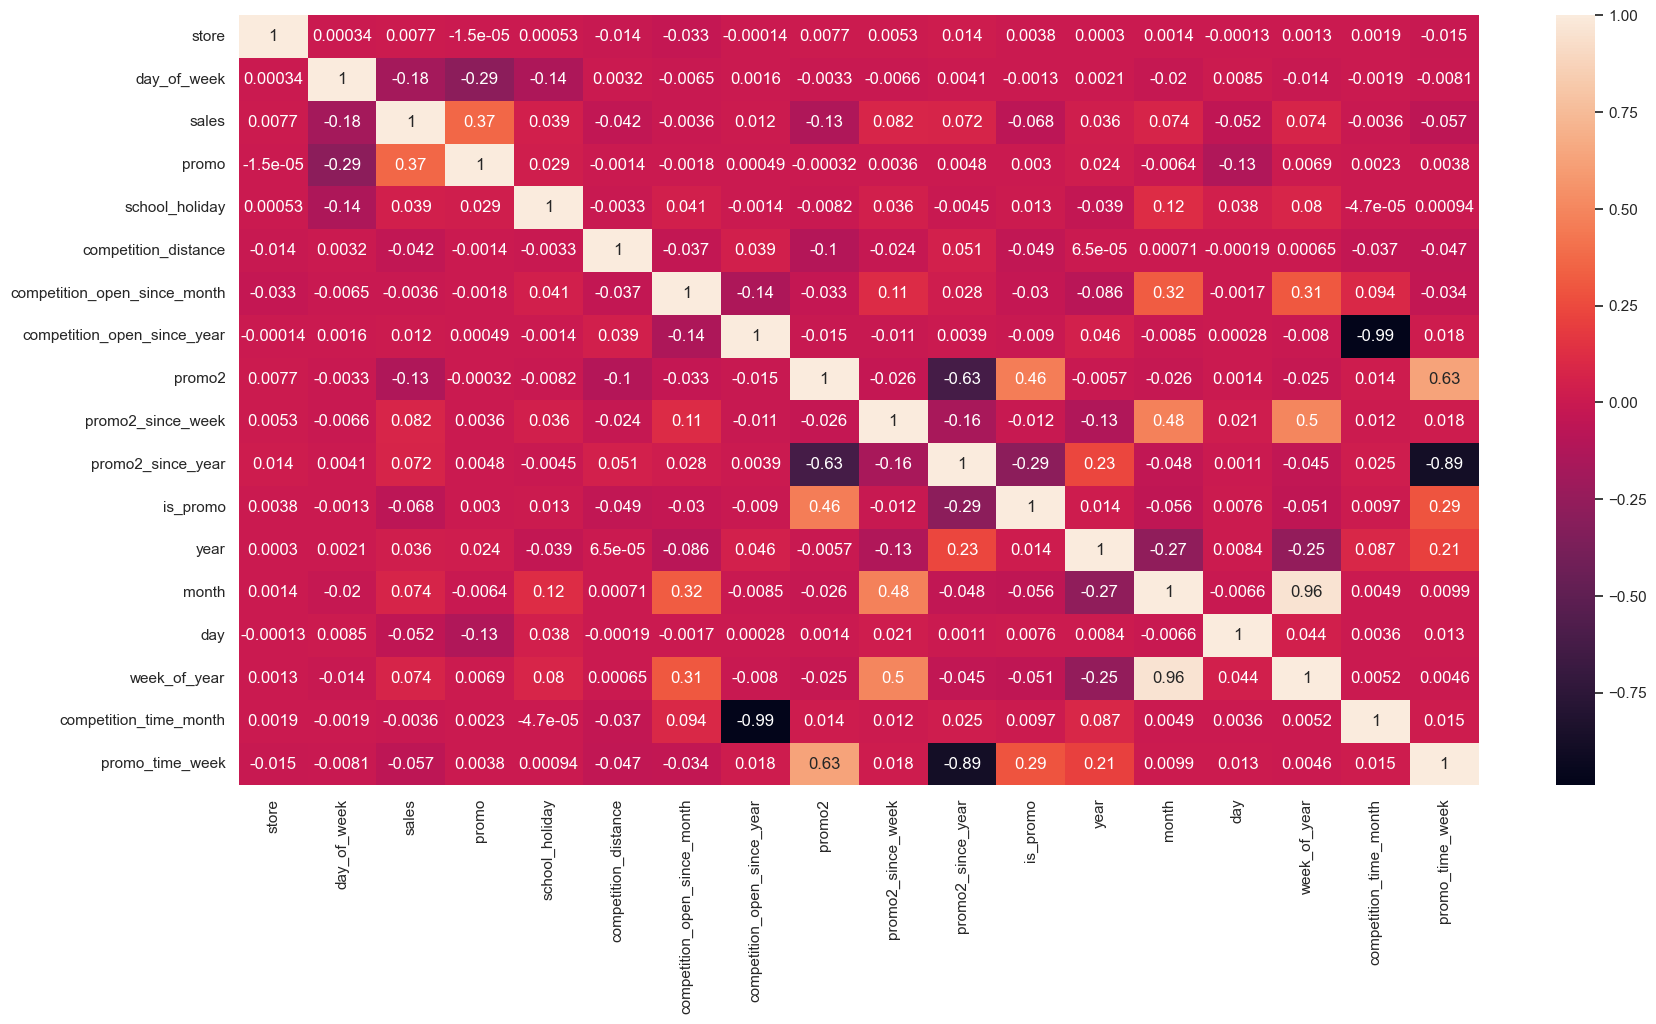

In [96]:
### Correlação entre todas as variáveis - Matriz de correlação multivariada

sns.heatmap( num_attributes_eda.corr(method = 'pearson'), annot = True);

### 4.3.2. Categorical Attributes 

In [97]:
cat_attributes_eda.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


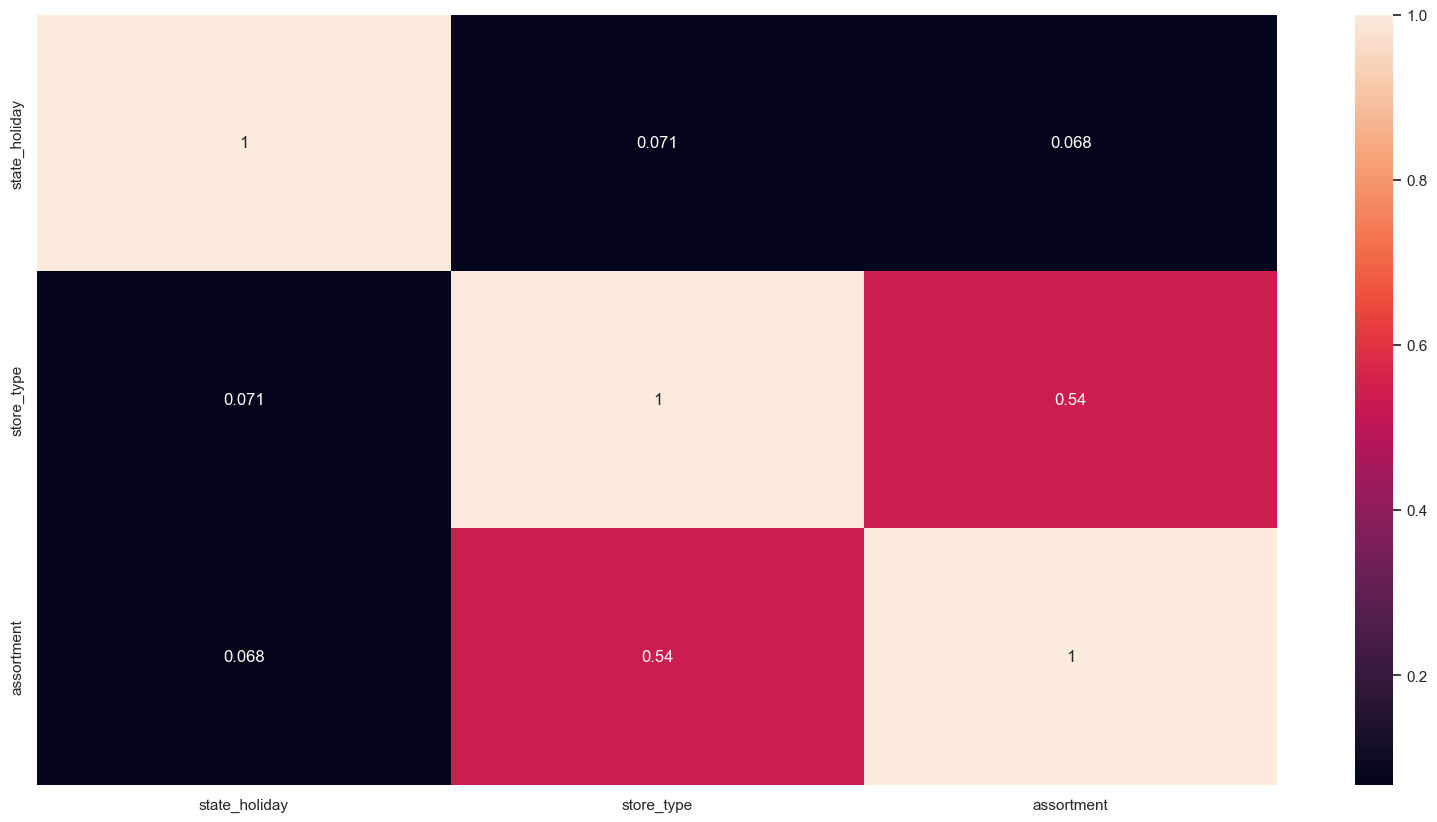

In [98]:
# Calculate cramer V
a1 = cramer_v( cat_attributes_eda['state_holiday'], cat_attributes_eda['state_holiday'] )
a2 = cramer_v( cat_attributes_eda['state_holiday'], cat_attributes_eda['store_type'] )
a3 = cramer_v( cat_attributes_eda['state_holiday'], cat_attributes_eda['assortment'] )

a4 = cramer_v( cat_attributes_eda['store_type'], cat_attributes_eda['state_holiday'] )
a5 = cramer_v( cat_attributes_eda['store_type'], cat_attributes_eda['store_type'] )
a6 = cramer_v( cat_attributes_eda['store_type'], cat_attributes_eda['assortment'] )

a7 = cramer_v( cat_attributes_eda['assortment'], cat_attributes_eda['state_holiday'] )
a8 = cramer_v( cat_attributes_eda['assortment'], cat_attributes_eda['store_type'] )
a9 = cramer_v( cat_attributes_eda['assortment'], cat_attributes_eda['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
                   'store_type':    [a4, a5, a6],
                   'assortment':    [a7, a8, a9] })

d = d.set_index( d.columns )

sns.heatmap( d, annot=True );

# 5.0. PREPARAÇÃO DOS DADOS ou MODELAGEM DOS DADOS

In [15]:
### Cópia do dataframe em início de sessão 
### OBJETIVO: Caso seja realizado alguma instrução errada sob os dados trabalhados, poder ter um ponto de backup.

df5 = df4.copy()

## 5.1. Split dataframe into training and test dataset  

**Modelo de separação em dados de treino e teste:** 

Como os dados estão colocados de forma temporal, e o fenômeno de previsão também leva em consideração saber a previsão dentro de um período temporal, irei dividir os dados de treino e teste de acordo com o período de vendas, e não selecionando dados aleatórios, pois dessa forma, pode inviesar o modelo já que ele terá amostras de dados de datas futuras no treino e datas passadas no teste. 

In [100]:
## Calculando a data limite que dividirá o dataset: últimas 6 semanas de registro de vendas - TESTE
                                                   #registros de vendas antes das últimas 6 semanas - TREINO

df5["date"].max() - datetime.timedelta(days = 6*7)

Timestamp('2015-06-19 00:00:00')

In [16]:
## Filtrando dataset para a divisão como definido em modelo

# training dataset
X_train = df5[df5['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df5[df5['date'] >= '2015-06-19']
y_test = X_test['sales']


# Verificando períodos dos registros de venda que ficaram para treino e teste
print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )


Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


In [17]:
## Para treinar modelos sem cross validation(One KFold) apenas com uma parte de teste selecionada

x_train = X_train.copy()
x_test = X_test.copy()

## 5.2. Normalização

Avaliar quais variáveis devem ser normalizadas, aquelas que possuem distribuição próxima da normal.

Optou-se por não normalizar nenhuma variável numérica

## 5.3. Rescaling


In [ ]:
## Dataframe apenas com features numéricas para enxergar os attr potenciais para fazer rescaling
a = x_train.select_dtypes(include = ['int64','float64'])

### 5.2.1. Análise de Outliers dados de treino

Avaliando a existência de outliers nos atributos dos dados de treino para decidir entre Min-Max e Robust

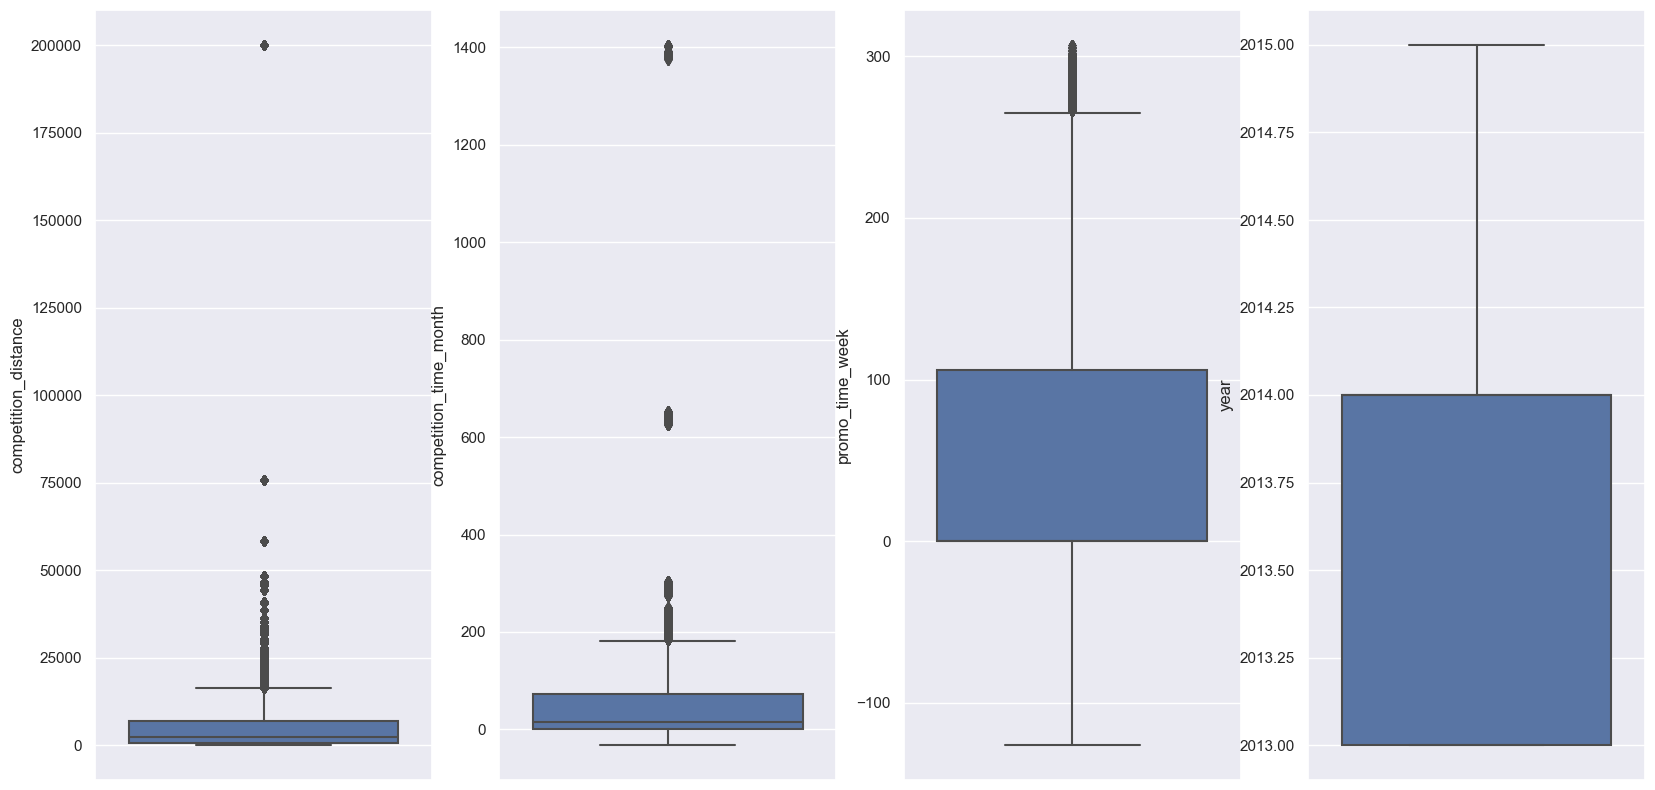

In [51]:
# competition_distance
plt.subplot(1,4, 1)
sns.boxplot(data = x_train , y = "competition_distance" );

# competition_time_month
plt.subplot(1,4,2)
sns.boxplot(data = x_train , y = "competition_time_month" );

# promo_time_week
plt.subplot(1,4,3)
sns.boxplot(data = x_train , y = "promo_time_week" );

# year 
plt.subplot(1,4,4)
sns.boxplot(data = x_train , y = "year" );

**Análise:** 

***competition_distance:*** É verificado a existência de inúmeros outliers, principalmente aqueles os quais colocamos em dados faltantes com um valor alto de distância por entender que não seria um competidor próximo. Decisão usar Robust Scaler.

***competition_time_month:*** É verificado a existência de inúmeros outliers. Decisão usar Robust Scaler.

***promo_time_week:*** É verificado poucos outliers, dessa forma, arriscaremos e será utilizado o MixMaxScaler.

***year:*** Não é verificado outliers. Decisão usar MinMaxScaler.

### 5.2.2. Aplicando o Rescaling

In [18]:
# Instanciando classe para aplicar técnica de Reescala
rs = RobustScaler() 
mms = MinMaxScaler()


# fit - calcula os parâmetros Q1 e Q2 do método de Reescala Robusto
# transform - Aplica a fórmula e de fato gera a escala nova do atributo


####### competition_distance

## Train
x_train["competition_distance"] = rs.fit_transform( x_train[["competition_distance"]].values )
# Salvando valores parâmetros calculados para dados de treino para posteriormente fazer a reescala nos dados de teste em produção
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl', 'wb'))

## Test
x_test["competition_distance"] = rs.transform( x_test[["competition_distance"]].values )


####### competition_time_month

## Train
x_train["competition_time_month"] = rs.fit_transform( x_train[["competition_time_month"]].values )
# Salvando valores parâmetros calculados para dados de treino para posteriormente fazer a reescala nos dados de teste
pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl', 'wb'))

## Test
x_test["competition_time_month"] = rs.transform( x_test[["competition_time_month"]].values )


####### promo_time_week


## Train
x_train["promo_time_week"] = mms.fit_transform( x_train[["promo_time_week"]].values )
# Salvando valores parâmetros calculados para dados de treino para posteriormente fazer a reescala nos dados de teste
pickle.dump(mms, open('parameter/promo_time_week_scaler.pkl', 'wb'))

## Test
x_test["promo_time_week"] = mms.transform( x_test[["promo_time_week"]].values )


####### year


## Train
x_train["year"] = mms.fit_transform( x_train[["year"]].values )
# Salvando valores parâmetros calculados para dados de treino para posteriormente fazer a reescala nos dados de teste
pickle.dump(mms, open('parameter/year_scaler.pkl', 'wb'))

## Test
x_test["year"] = mms.transform( x_test[["year"]].values )


### 5.2.3. Distribuição atributos treino após Rescaling

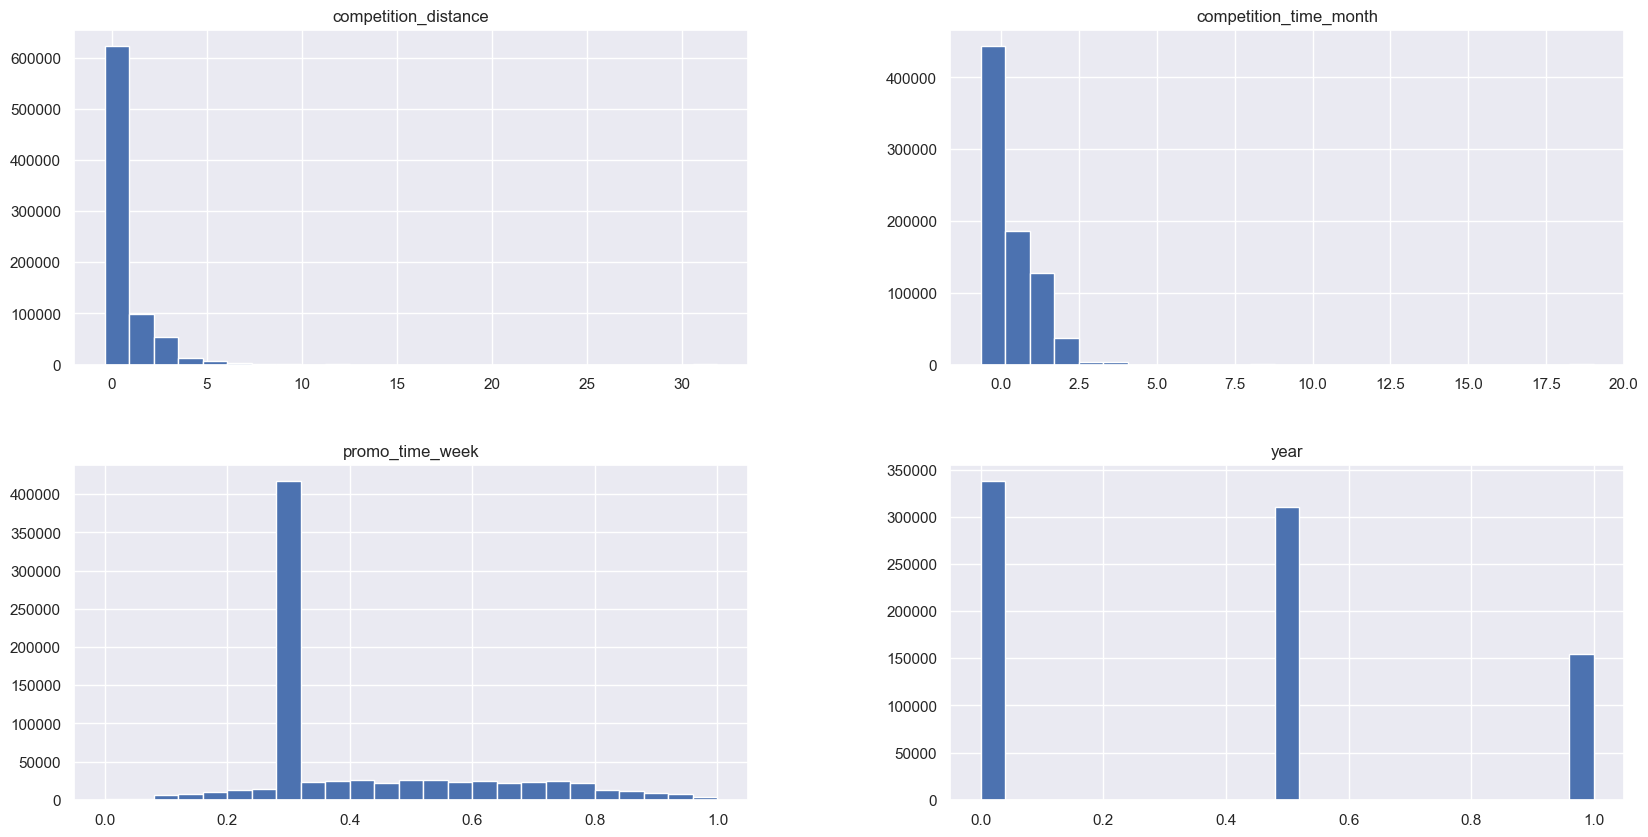

In [53]:
# Dataset de treino com as variáveis com rescaling aplicadas para analisar distribução nova
aux = x_train[["competition_distance","competition_time_month","promo_time_week","year"]]

aux.hist( bins = 25 );

## 5.4. Transformação 

### 5.3.1. Encoding

Variáveis categóricas -> Variáveis Numéricas

#### 5.3.1.1. Dataframe treino antes do Encoding

In [104]:
x_train.head(10)

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
47945,1,4,2015-06-18,4645,1,regular_day,0,c,basic,-0.17,9,2008,0,25,2015,0,1.00,6,18,25,2015-24,2008-09-01,0.90,2015-06-15,0.29
47946,2,4,2015-06-18,5154,1,regular_day,0,a,basic,-0.28,11,2007,1,13,2010,0,1.00,6,18,25,2015-24,2007-11-01,1.04,2010-03-22,0.92
47947,3,4,2015-06-18,7537,1,regular_day,0,a,basic,1.90,12,2006,1,14,2011,0,1.00,6,18,25,2015-24,2006-12-01,1.21,2011-03-28,0.80
47948,4,4,2015-06-18,8880,1,regular_day,0,c,extended,-0.28,9,2009,0,25,2015,0,1.00,6,18,25,2015-24,2009-09-01,0.74,2015-06-15,0.29
47949,5,4,2015-06-18,4924,1,regular_day,0,a,basic,4.45,4,2015,0,25,2015,0,1.00,6,18,25,2015-24,2015-04-01,-0.19,2015-06-15,0.29
47950,6,4,2015-06-18,4405,1,regular_day,0,a,basic,-0.33,12,2013,0,25,2015,0,1.00,6,18,25,2015-24,2013-12-01,0.03,2015-06-15,0.29
47951,7,4,2015-06-18,8955,1,regular_day,0,a,extended,3.50,4,2013,0,25,2015,0,1.00,6,18,25,2015-24,2013-04-01,0.14,2015-06-15,0.29
47952,8,4,2015-06-18,7302,1,regular_day,0,a,basic,0.84,10,2014,0,25,2015,0,1.00,6,18,25,2015-24,2014-10-01,-0.11,2015-06-15,0.29
47953,9,4,2015-06-18,8098,1,regular_day,0,a,extended,-0.05,8,2000,0,25,2015,0,1.00,6,18,25,2015-24,2000-08-01,2.26,2015-06-15,0.29
47954,10,4,2015-06-18,5829,1,regular_day,0,a,basic,0.13,9,2009,0,25,2015,0,1.00,6,18,25,2015-24,2009-09-01,0.74,2015-06-15,0.29


#### 5.3.1.2. Aplicando Encoding

In [19]:
####### state_holiday -> One Hot Encoding 

## Train
x_train = pd.get_dummies(x_train, prefix = ['state_holiday'], columns = ['state_holiday'])

## Test
x_test = pd.get_dummies(x_test, prefix = ['state_holiday'], columns = ['state_holiday'])

####### store_type

## Train
le = LabelEncoder()
x_train["store_type"] = le.fit_transform( x_train["store_type"] )
# Salvando valores parâmetros calculados para dados de treino para posteriormente fazer encoding nos dados de teste
pickle.dump(le, open('parameter/store_type_encoding.pkl', 'wb'))

## Test
x_test["store_type"] = le.transform( x_test["store_type"] )


####### assortment

# Troca de valores da coluna utilizando o método .map e o dicionário como referência
assortment_dict = {'basic': 1, 'extended': 2, 'extra': 3}

## Train
x_train["assortment"] = x_train["assortment"].map(assortment_dict)

## Test
x_test["assortment"] = x_test["assortment"].map(assortment_dict)

**Escolhas:** 

***state_holiday:*** Usar one hot encoding pois não possui muitos níveis esse atributo.

***store_type:*** Usar Label Encoding pois os níveis da variável não possuem relação entre si.

***assortment:*** Usar Ordinal Encoding pois os níveis da variável possuem uma certa relação de grandeza entre si.

#### 5.3.1.1. Dataframe treino depois do Encoding

In [106]:
x_train.head(10)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
47945,1,4,2015-06-18,4645,1,0,2,1,-0.17,9,2008,0,25,2015,0,1.00,6,18,25,2015-24,2008-09-01,0.90,2015-06-15,0.29,0,0,0,1
47946,2,4,2015-06-18,5154,1,0,0,1,-0.28,11,2007,1,13,2010,0,1.00,6,18,25,2015-24,2007-11-01,1.04,2010-03-22,0.92,0,0,0,1
47947,3,4,2015-06-18,7537,1,0,0,1,1.90,12,2006,1,14,2011,0,1.00,6,18,25,2015-24,2006-12-01,1.21,2011-03-28,0.80,0,0,0,1
47948,4,4,2015-06-18,8880,1,0,2,2,-0.28,9,2009,0,25,2015,0,1.00,6,18,25,2015-24,2009-09-01,0.74,2015-06-15,0.29,0,0,0,1
47949,5,4,2015-06-18,4924,1,0,0,1,4.45,4,2015,0,25,2015,0,1.00,6,18,25,2015-24,2015-04-01,-0.19,2015-06-15,0.29,0,0,0,1
47950,6,4,2015-06-18,4405,1,0,0,1,-0.33,12,2013,0,25,2015,0,1.00,6,18,25,2015-24,2013-12-01,0.03,2015-06-15,0.29,0,0,0,1
47951,7,4,2015-06-18,8955,1,0,0,2,3.50,4,2013,0,25,2015,0,1.00,6,18,25,2015-24,2013-04-01,0.14,2015-06-15,0.29,0,0,0,1
47952,8,4,2015-06-18,7302,1,0,0,1,0.84,10,2014,0,25,2015,0,1.00,6,18,25,2015-24,2014-10-01,-0.11,2015-06-15,0.29,0,0,0,1
47953,9,4,2015-06-18,8098,1,0,0,2,-0.05,8,2000,0,25,2015,0,1.00,6,18,25,2015-24,2000-08-01,2.26,2015-06-15,0.29,0,0,0,1
47954,10,4,2015-06-18,5829,1,0,0,1,0.13,9,2009,0,25,2015,0,1.00,6,18,25,2015-24,2009-09-01,0.74,2015-06-15,0.29,0,0,0,1


### 5.3.2. Response Variable Transformation

In [20]:
####### Aplicar a Transformação Logarítmica 

## Train
y_train = np.log1p( y_train )

## Test
y_test = np.log1p( y_test )

<AxesSubplot:xlabel='sales', ylabel='Count'>

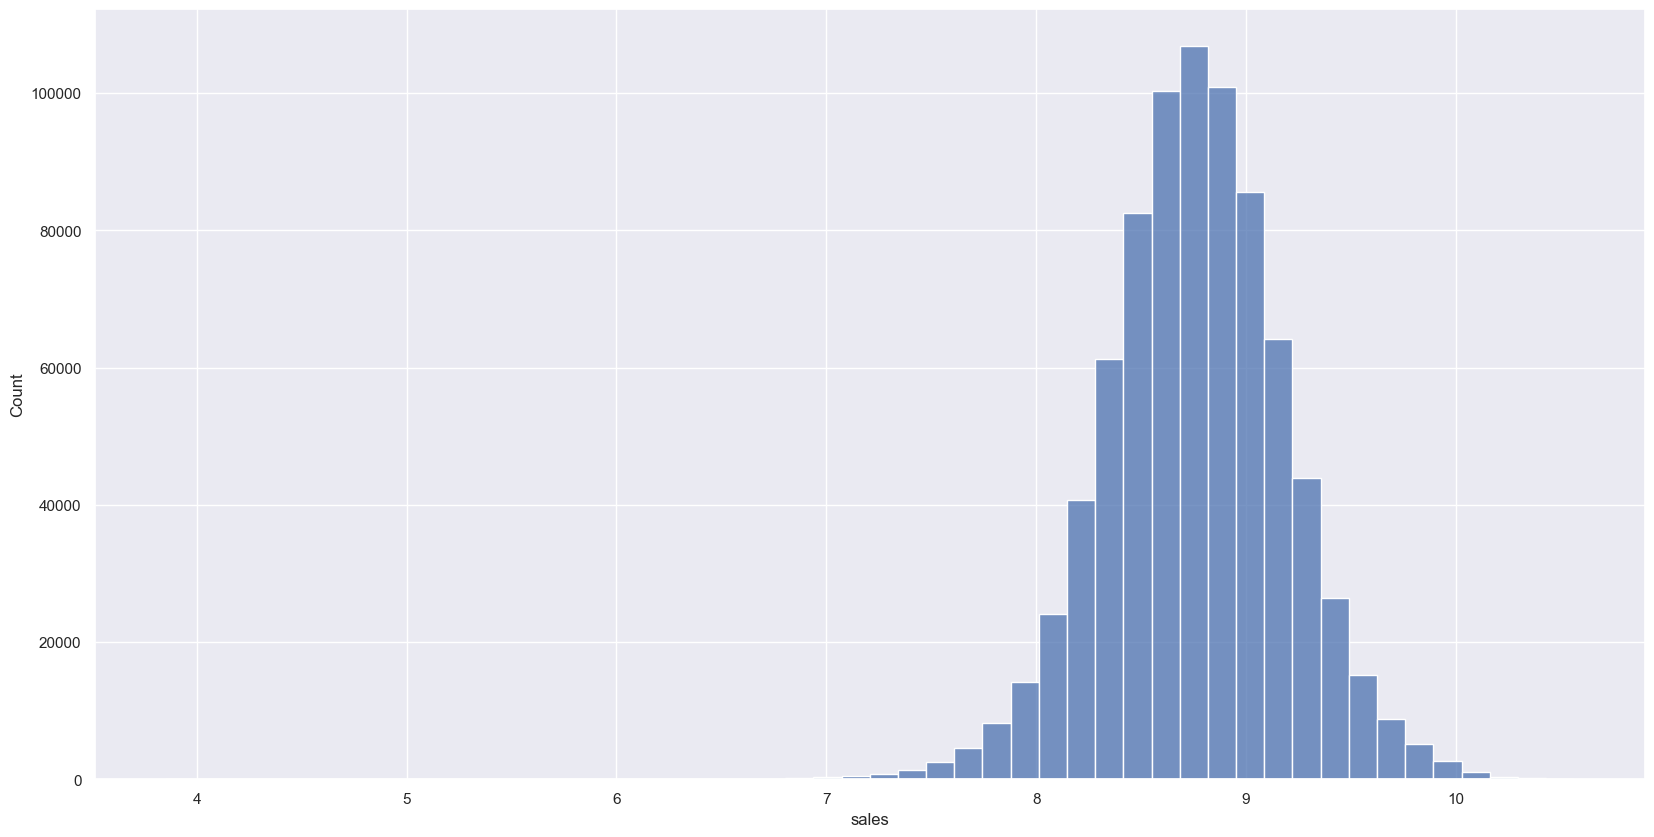

In [108]:
## Distribuição da variável resposta nos dados de treino após a aplicação da transformação logarítmica

sns.histplot (y_train, bins = 50)

### 5.3.3. Nature Transformation

#### 5.3.3.1. Dataframe treino antes da Transformação

In [109]:
x_train.head(10)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
47945,1,4,2015-06-18,4645,1,0,2,1,-0.17,9,2008,0,25,2015,0,1.00,6,18,25,2015-24,2008-09-01,0.90,2015-06-15,0.29,0,0,0,1
47946,2,4,2015-06-18,5154,1,0,0,1,-0.28,11,2007,1,13,2010,0,1.00,6,18,25,2015-24,2007-11-01,1.04,2010-03-22,0.92,0,0,0,1
47947,3,4,2015-06-18,7537,1,0,0,1,1.90,12,2006,1,14,2011,0,1.00,6,18,25,2015-24,2006-12-01,1.21,2011-03-28,0.80,0,0,0,1
47948,4,4,2015-06-18,8880,1,0,2,2,-0.28,9,2009,0,25,2015,0,1.00,6,18,25,2015-24,2009-09-01,0.74,2015-06-15,0.29,0,0,0,1
47949,5,4,2015-06-18,4924,1,0,0,1,4.45,4,2015,0,25,2015,0,1.00,6,18,25,2015-24,2015-04-01,-0.19,2015-06-15,0.29,0,0,0,1
47950,6,4,2015-06-18,4405,1,0,0,1,-0.33,12,2013,0,25,2015,0,1.00,6,18,25,2015-24,2013-12-01,0.03,2015-06-15,0.29,0,0,0,1
47951,7,4,2015-06-18,8955,1,0,0,2,3.50,4,2013,0,25,2015,0,1.00,6,18,25,2015-24,2013-04-01,0.14,2015-06-15,0.29,0,0,0,1
47952,8,4,2015-06-18,7302,1,0,0,1,0.84,10,2014,0,25,2015,0,1.00,6,18,25,2015-24,2014-10-01,-0.11,2015-06-15,0.29,0,0,0,1
47953,9,4,2015-06-18,8098,1,0,0,2,-0.05,8,2000,0,25,2015,0,1.00,6,18,25,2015-24,2000-08-01,2.26,2015-06-15,0.29,0,0,0,1
47954,10,4,2015-06-18,5829,1,0,0,1,0.13,9,2009,0,25,2015,0,1.00,6,18,25,2015-24,2009-09-01,0.74,2015-06-15,0.29,0,0,0,1


#### 5.3.3.2. Transformação

In [21]:
## FEATURES COM NATUREZA CÍCLICA:

####### day_of_week - ciclo de 7 

## Train
x_train["day_of_week_sin"] = x_train["day_of_week"].apply(lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
x_train["day_of_week_cos"] = x_train["day_of_week"].apply(lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

## Test
x_test["day_of_week_sin"] = x_test["day_of_week"].apply(lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
x_test["day_of_week_cos"] = x_test["day_of_week"].apply(lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

####### month - ciclo de 12

## Train
x_train["month_sin"] = x_train["month"].apply(lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
x_train["month_cos"] = x_train["month"].apply(lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

## Test
x_test["month_sin"] = x_test["month"].apply(lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
x_test["month_cos"] = x_test["month"].apply(lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )


####### day - ciclo de 31

## Train
x_train["day_sin"] = x_train["day"].apply(lambda x: np.sin( x * ( 2. * np.pi/31 ) ) )
x_train["day_cos"] = x_train["day"].apply(lambda x: np.cos( x * ( 2. * np.pi/31 ) ) )

## Test
x_test["day_sin"] = x_test["day"].apply(lambda x: np.sin( x * ( 2. * np.pi/31 ) ) )
x_test["day_cos"] = x_test["day"].apply(lambda x: np.cos( x * ( 2. * np.pi/31 ) ) )


####### week_of_year - ciclo de 52 

## Train
x_train["week_of_year_sin"] = x_train["week_of_year"].apply(lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
x_train["week_of_year_cos"] = x_train["week_of_year"].apply(lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

## Test
x_test["week_of_year_sin"] = x_test["week_of_year"].apply(lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
x_test["week_of_year_cos"] = x_test["week_of_year"].apply(lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )


**Escolha:**

Utilizou-se transformação trigonométrica para transformar atributos com informações cíclicas em números

#### 5.3.3.3. Dataframe treino depois da Transformação

In [111]:
x_train.head(10)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
47945,1,4,2015-06-18,4645,1,0,2,1,-0.17,9,2008,0,25,2015,0,1.00,6,18,25,2015-24,2008-09-01,0.90,2015-06-15,0.29,0,0,0,1,-0.43,-0.90,0.00,-1.00,-0.49,-0.87,0.12,-0.99
47946,2,4,2015-06-18,5154,1,0,0,1,-0.28,11,2007,1,13,2010,0,1.00,6,18,25,2015-24,2007-11-01,1.04,2010-03-22,0.92,0,0,0,1,-0.43,-0.90,0.00,-1.00,-0.49,-0.87,0.12,-0.99
47947,3,4,2015-06-18,7537,1,0,0,1,1.90,12,2006,1,14,2011,0,1.00,6,18,25,2015-24,2006-12-01,1.21,2011-03-28,0.80,0,0,0,1,-0.43,-0.90,0.00,-1.00,-0.49,-0.87,0.12,-0.99
47948,4,4,2015-06-18,8880,1,0,2,2,-0.28,9,2009,0,25,2015,0,1.00,6,18,25,2015-24,2009-09-01,0.74,2015-06-15,0.29,0,0,0,1,-0.43,-0.90,0.00,-1.00,-0.49,-0.87,0.12,-0.99
47949,5,4,2015-06-18,4924,1,0,0,1,4.45,4,2015,0,25,2015,0,1.00,6,18,25,2015-24,2015-04-01,-0.19,2015-06-15,0.29,0,0,0,1,-0.43,-0.90,0.00,-1.00,-0.49,-0.87,0.12,-0.99
47950,6,4,2015-06-18,4405,1,0,0,1,-0.33,12,2013,0,25,2015,0,1.00,6,18,25,2015-24,2013-12-01,0.03,2015-06-15,0.29,0,0,0,1,-0.43,-0.90,0.00,-1.00,-0.49,-0.87,0.12,-0.99
47951,7,4,2015-06-18,8955,1,0,0,2,3.50,4,2013,0,25,2015,0,1.00,6,18,25,2015-24,2013-04-01,0.14,2015-06-15,0.29,0,0,0,1,-0.43,-0.90,0.00,-1.00,-0.49,-0.87,0.12,-0.99
47952,8,4,2015-06-18,7302,1,0,0,1,0.84,10,2014,0,25,2015,0,1.00,6,18,25,2015-24,2014-10-01,-0.11,2015-06-15,0.29,0,0,0,1,-0.43,-0.90,0.00,-1.00,-0.49,-0.87,0.12,-0.99
47953,9,4,2015-06-18,8098,1,0,0,2,-0.05,8,2000,0,25,2015,0,1.00,6,18,25,2015-24,2000-08-01,2.26,2015-06-15,0.29,0,0,0,1,-0.43,-0.90,0.00,-1.00,-0.49,-0.87,0.12,-0.99
47954,10,4,2015-06-18,5829,1,0,0,1,0.13,9,2009,0,25,2015,0,1.00,6,18,25,2015-24,2009-09-01,0.74,2015-06-15,0.29,0,0,0,1,-0.43,-0.90,0.00,-1.00,-0.49,-0.87,0.12,-0.99


# 6.0. SELEÇÃO DE ATRIBUTOS 

In [22]:
## Retirar do dataset variáveis que deram origem a features criadas 
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since','competition_since', 'year_week' ]
x_train = x_train.drop( cols_drop, axis=1 )
x_test = x_test.drop( cols_drop, axis=1 )


In [ ]:
## Pensaria aqui em dropar outras colunas também, em próximo ciclo CRISP

## 6.2. Boruta as Feature Selector  

In [113]:
## training dataset final for Boruta
## Boruta aceita apenas Numpy, então por isso, .values
## ravel() coloca a variável resposta em vetor

X_train_n = x_train.drop( ['date', 'sales'], axis=1 ).values
y_train_n = y_train.values.ravel()

## define RandomForestRegressor
##  n_jobs=-1 usa os core da máquina e fazer processamento em paralelo para ir mais rápido
rf = RandomForestRegressor( n_jobs=-1 )


## define Boruta 
## verbose é pra enxergar a evolução do processo de análise de seleção de features
## random_state é para selecionar aleatoriamente partindo de um mesmo ponto sempre

boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(X_train_n, y_train_n )


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


## 6.3. Best Features from Boruta  

In [120]:
## vetor True or False com  colunas selecionadas segundo o Boruta 
cols_selected = boruta.support_.tolist()

## as colunas mais relevantes segundo boruta
cols_selected_boruta = x_train.drop( ['date', 'sales'], axis=1 ).iloc[:, cols_selected].columns

## Colunas não selecionadas pelo boruta
cols_not_selected_boruta = list( np.setdiff1d( x_train.drop( ['date', 'sales'], axis=1 ).columns, cols_selected_boruta ) )

In [121]:
cols_selected_boruta.tolist()

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

In [122]:
cols_not_selected_boruta


['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

In [ ]:
## Variáveis apontadas como mais relevantes na EDA e a checagem com Boruta:

## year nao
## assortment sim
## competition_time_month sim
## state_holiday nao
## month sim
## promo sim

## 6.4. Manual Feature Selection  

Seleção Final contemplando as colunas relevantes apontadas pelo Boruta e pela análise exploratória de dados e escolha manual.

In [23]:
cols_selected = ['store',
                 'promo',
                 'store_type',
                 'assortment',
                 'competition_distance',
                 'competition_open_since_month',
                 'competition_open_since_year',
                 'promo2',
                 'promo2_since_week',
                 'promo2_since_year',
                 'competition_time_month',
                 'promo_time_week',
                 'day_of_week_sin',
                 'day_of_week_cos',
                 'month_cos',
                 'month_sin',
                 'day_sin',
                 'day_cos',
                 'week_of_year_cos',
                 'week_of_year_sin']

In [24]:
cols_selected

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'week_of_year_sin']

# 7.0. MODELOS DE MACHINE LEARNING 

In [25]:
## Para treinar modelos sem cross validation apenas com uma parte de teste selecionada

## Selecionar apenas as colunas com maior importância sem as colunas data e sales
x_train_one_k = x_train[ cols_selected ]
x_test_one_k = x_test[ cols_selected ]

## 7.1. Average Model 

In [126]:
# model

aux1 = x_test_one_k.copy() ## Cópia do conjunto de dados de teste
aux1['sales'] = y_test.copy() ## Cópia da variável resposta de teste adicionando ao df aux1

# Cálculo da média de vendas por loja apenas com dados de teste
aux2 = aux1[['sales','store']].groupby("store").mean().reset_index().rename( columns = {"sales":"predictions"} ) 
aux1 = pd.merge(aux1, aux2, how = 'left', on = 'store') # Juntei a coluna predictions ao dataset de teste


# prediction 
yhat_baseline = aux1['predictions'] # valores preditos

# performance - função para calcular desempenho de modelos

# np.expm1() aplica-se exponencial nas variáveis respostas de vendas pois tinhamos transformado elas com log para treinar o modelo
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.80,0.21,1835.14


## 7.2. Linear Regression Model

### 7.2.1. Linear Regression Model - One KFold 

In [127]:
# model - classe de Regressão linear que irá se ajustar baseado nos parâmetros de dados de treino passados
lr = LinearRegression().fit( x_train_one_k, y_train ) 

# prediction
yhat_lr = lr.predict( x_test_one_k )


# performance 
# np.expm1() aplica-se exponencial nas variáveis respostas de vendas pois tinhamos transformado elas com log para treinar o modelo
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )

lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1861.69,0.29,2662.58


### 7.2.2. Linear Regression Model - Cross Validation 

In [133]:
model = LinearRegression()


lr_result_cv = cross_validation(X_train, 5, 'Linear Regression', model, cols_selected, verbose = True)
lr_result_cv


KFold Number 1

KFold Number 2

KFold Number 3

KFold Number 4

KFold Number 5


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2077.3 +/- 296.01,0.3 +/- 0.02,2944.9 +/- 468.99


## 7.3. Linear Regression Regularized Model  - Lasso 

### 7.3.1. Linear Regression Regularized Model - Lasso - One KFold 

In [128]:
# model - classe de Regressão linear Regularizada Lasso que irá se ajustar baseado nos parâmetros de dados de treino passados
# alpha parâmetro para atenuar os pesos da regressão para quando alguma variável obtiver peso muito alto, cada variável possuir igual importância
## Diminuindo alpha a tendência é melhorar o resultado, mas demora mais o processamento do modelo.

lrr = Lasso( alpha = 0.01 ).fit( x_train_one_k, y_train ) 

# prediction
yhat_lrr = lrr.predict( x_test_one_k )


# performance 
# np.expm1() aplica-se exponencial nas variáveis respostas de vendas pois tinhamos transformado elas com log para treinar o modelo
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )

lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.16,0.29,2741.92


**Reflexão:** Erro de regressão linear é maior que um erro de média, ou seja: 

1. Modelo de Média é melhor que o de Regressão Linear e RLR;
2. Dados possuem comportamento complexo não linear que faz com que modelos lineares não consigam aprender os comportamentos.

### 7.3.2. Linear Regression Regularized Model - Lasso - Cross Validation 

In [134]:
model = Lasso( alpha = 0.01 )


lrr_result_cv = cross_validation(X_train, 5, 'Linear Regression - Lasso', model, cols_selected, verbose = True)
lrr_result_cv


KFold Number 1

KFold Number 2

KFold Number 3

KFold Number 4

KFold Number 5


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression - Lasso,2117.39 +/- 342.62,0.29 +/- 0.01,3057.28 +/- 505.55


## 7.4. Random Forest Regressor 

### 7.4.1. Random Forest Regressor - One KFold 

In [129]:
# model - classe de RF que irá se ajustar baseado nos parâmetros de dados de treino passados
# n_estimators -> nº de árvores aleatórias que ele vai criar


rf = RandomForestRegressor( n_estimators = 100, n_jobs =-1 , random_state= 42 ).fit( x_train_one_k, y_train ) 

# prediction
yhat_rf = rf.predict( x_test_one_k )


# performance 
# np.expm1() aplica-se exponencial nas variáveis respostas de vendas pois tinhamos transformado elas com log para treinar o modelo
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )

rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,675.90,0.10,1004.51


### 7.4.2. Random Forest Regressor - Cross Validation 

In [136]:
model = RandomForestRegressor( n_estimators = 100, n_jobs =-1 , random_state= 42 )


rf_result_cv = cross_validation(X_train, 5, 'Random Forest Regressor', model, cols_selected, verbose = True)
rf_result_cv


KFold Number 1

KFold Number 2

KFold Number 3

KFold Number 4

KFold Number 5


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,865.05 +/- 254.9,0.12 +/- 0.03,1305.06 +/- 392.86


## 7.5. XGBoost Regressor

### 7.5.1. XGBoost Regressor - One KFold 

In [130]:
# model - instanciei objeto da classe de XGB Regressor que irá se ajustar baseado nos parâmetros de dados de treino passados

model_xgb = xgb.XGBRegressor( objective = 'reg:squarederror').fit( x_train_one_k, y_train ) 

### Parâmetros opcionais
#n_estimators = 100, # n_estimators -> nº de árvores aleatórias que ele vai criar
#eta = 0.01 , ## Passos de aprendizado
#max_depth = 10, ## Máx. profundidade que a árvore pode chegar
#subsample = 0.7, ## Porcentagem de amostragem para selecionar mais relevantes
#colsample_bytree = 0.9 


# prediction
yhat_xgb = model_xgb.predict( x_test_one_k )


# performance 
# np.expm1() aplica-se exponencial nas variáveis respostas de vendas pois tinhamos transformado elas com log para treinar o modelo
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )

xgb_result

C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,862.30,0.13,1239.40


### 7.5.2. XGBoost Regressor - Cross Validation

In [135]:
model = xgb.XGBRegressor( objective = 'reg:squarederror')

### Parâmetros opcionais
#n_estimators = 100, # n_estimators -> nº de árvores aleatórias que ele vai criar
#eta = 0.01 , ## Passos de aprendizado
#max_depth = 10, ## Máx. profundidade que a árvore pode chegar
#subsample = 0.7, ## Porcentagem de amostragem para selecionar mais relevantes
#colsample_bytree = 0.9



xgb_result_cv = cross_validation(X_train, 5, 'XGBoost Regressor', model, cols_selected, verbose = True)
xgb_result_cv


KFold Number 1


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 2


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 3


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 4


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 5


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1075.13 +/- 161.16,0.15 +/- 0.02,1550.83 +/- 227.38


## 7.6. Compare Model´s Performance

### 7.6.1. Single Performance

In [131]:
models_all = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result], axis = 0)
models_all.sort_values(by = 'RMSE', ascending = True)

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,675.90,0.10,1004.51
0,XGBoost Regressor,862.30,0.13,1239.40
0,Average Model,1354.80,0.21,1835.14
0,Linear Regression,1861.69,0.29,2662.58
0,Linear Regression - Lasso,1891.16,0.29,2741.92


**Conclusão:** o fenômeno que estamos modelando possui comportamento complexo, modelos mais simples como os lineares não funcionam bem para
esse tipo de fenômeno. Essa performance não é a real dos modelos, para obter maior consistência nos resultados comparativos deve-se usar a validação cruzada.

### 7.6.2. Real Performance - Cross Validation

In [137]:
models_all_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv], axis = 0)
models_all_cv.sort_values(by = 'RMSE CV', ascending = True)

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,865.05 +/- 254.9,0.12 +/- 0.03,1305.06 +/- 392.86
0,XGBoost Regressor,1075.13 +/- 161.16,0.15 +/- 0.02,1550.83 +/- 227.38
0,Linear Regression,2077.3 +/- 296.01,0.3 +/- 0.02,2944.9 +/- 468.99
0,Linear Regression - Lasso,2117.39 +/- 342.62,0.29 +/- 0.01,3057.28 +/- 505.55


**Tomada de Decisão:** O modelo escolhido para a próxima etapa de ajuste de parâmetros após a validação cruzada será o 
XGBoost, isso pois esse modelo possui apesar de ficar em segundo em termos de performance dos modelos na etapa de validação, se comparado ao Random Forest Regressor, possui menor tempo de processamento no treinamento, e a diferença de performance não é tão grande relacionado ao primeiro. 

In [ ]:
### Em outro momento, experimentar a Random Forest pode ser interessante também.

# 8.0. HYPERPARAMETER FINE TUNING 

## 8.1. Random Search

In [138]:
## Valores possíveis de teste para os parâmetros do modelo XGBoost
param = {'n_estimators': [1500, 1700, 2500, 3000, 3500],
         'eta': [0.01, 0.03],
         'max_depth': [3, 5, 9],
         'subsample': [0.1, 0.5, 0.7],
         'colsample_bytree': [0.3, 0.7, 0.9],
         'min_child_weight': [3, 8, 15]}


# Quantidade iterações (experimentos com valores distintos para testar desempenho)
MAX_EVAL = 10

In [139]:
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    
    ## Escolher um valor aleatório por iteração para cada parâmetro e armazenar em novo dicionário hp
    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
    
    ## Display do experimento com valores escolhidos
    
    print(f"\nIteração Nº: {i + 1}")
    
    print( hp )
    
    
    ## Modelo
    model = xgb.XGBRegressor( objective = 'reg:squarederror',
                              n_estimators = hp['n_estimators'], # n_estimators -> nº de árvores aleatórias que ele vai criar
                              eta = hp['eta'] , ## Passos de aprendizado
                              max_depth = hp['max_depth'], ## Máx. profundidade que a árvore pode chegar
                              subsample = hp['subsample'], ## Porcentagem de amostragem para selecionar mais relevantes
                              colsample_bytree = hp['colsample_bytree'],
                              min_child_weight = hp['min_child_weight'])


    # Performance
    result = cross_validation(X_train, 5, 'XGBoost Regressor', model, cols_selected, verbose = True)
    final_result = pd.concat([ final_result , result ])

    
    
## DataFrame com resultados de desempenho modelos com valores de parâmetros alterados
final_result


Iteração Nº: 1
{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 8}

KFold Number 1


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 2


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 3


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 4


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 5


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



Iteração Nº: 2
{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 3}

KFold Number 1


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 2


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 3


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 4


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 5


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



Iteração Nº: 3
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 8}

KFold Number 1


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 2


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 3


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 4


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 5


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



Iteração Nº: 4
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 8}

KFold Number 1


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 2


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 3


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 4


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 5


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



Iteração Nº: 5
{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 15}

KFold Number 1


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 2


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 3


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 4


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 5


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



Iteração Nº: 6
{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 3}

KFold Number 1


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 2


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 3


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 4


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 5


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



Iteração Nº: 7
{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 15}

KFold Number 1


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 2


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 3


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 4


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 5


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



Iteração Nº: 8
{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 3}

KFold Number 1


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 2


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 3


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 4


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 5


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



Iteração Nº: 9
{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 8}

KFold Number 1


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 2


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 3


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 4


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 5


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



Iteração Nº: 10
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 8}

KFold Number 1


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 2


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 3


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 4


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 5


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1075.21 +/- 131.34,0.15 +/- 0.01,1547.41 +/- 188.05
0,XGBoost Regressor,1236.19 +/- 147.32,0.17 +/- 0.01,1792.62 +/- 203.19
0,XGBoost Regressor,1732.76 +/- 195.65,0.24 +/- 0.01,2487.53 +/- 266.85
0,XGBoost Regressor,975.9 +/- 155.6,0.13 +/- 0.01,1413.21 +/- 229.34
0,XGBoost Regressor,1224.2 +/- 147.11,0.17 +/- 0.01,1772.43 +/- 198.63
0,XGBoost Regressor,1312.37 +/- 149.47,0.18 +/- 0.01,1901.42 +/- 202.16
0,XGBoost Regressor,1310.59 +/- 149.69,0.18 +/- 0.01,1899.22 +/- 202.5
0,XGBoost Regressor,1589.84 +/- 175.23,0.22 +/- 0.01,2301.34 +/- 234.98
0,XGBoost Regressor,897.19 +/- 135.76,0.12 +/- 0.01,1290.91 +/- 201.91
0,XGBoost Regressor,1267.42 +/- 151.07,0.17 +/- 0.01,1838.71 +/- 205.53


## 8.2. Final Model

In [26]:
## Valores selecionados para cada parâmetro do modelo de acordo com o método Random Search

# Parametros do modelo meu 
#param_tuned = {'n_estimators': 1700,
#               'eta': 0.03,
#               'max_depth': 9,
#               'subsample': 0.1,
#               'colsample_bytree': 0.3,
#               'min_child_weight': 8}   

# Parametros para modelo ficar menor

param_tuned = { 'n_estimators': 3000,
                'eta': 0.03,
                'max_depth': 5,
                'subsample': 0.7,
                'colsample_bytree': 0.7,
                'min_child_weight': 3 }

In [27]:
## Desempenho do Modelo Final sob os dados de teste 

model_xgb = xgb.XGBRegressor( objective = 'reg:squarederror',
                          n_estimators = param_tuned['n_estimators'], # n_estimators -> nº de árvores aleatórias que ele vai criar
                          eta = param_tuned['eta'] , ## Passos de aprendizado
                          max_depth = param_tuned['max_depth'], ## Máx. profundidade que a árvore pode chegar
                          subsample = param_tuned['subsample'], ## Porcentagem de amostragem para selecionar mais relevantes
                          colsample_bytree = param_tuned['colsample_bytree'],
                          min_child_weight = param_tuned['min_child_weight']).fit( x_train_one_k, y_train ) 


## Predição
yhat_xgb = model_xgb.predict( x_test_one_k )


# Performance
# np.expm1() aplica-se exponencial nas variáveis respostas de vendas pois tinhamos transformado elas com log para treinar o modelo
xgb_final_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )

xgb_final_result 

C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,767.25,0.12,1098.15


In [28]:
## Armazenar modelo treinado após o ajuste de parâmetros
pickle.dump(model_xgb, open('C:/Users/alanc/Documents/repos/ds_em_producao/prediction_sales/webapp/model/model_xgb.pkl', 'wb'))

In [49]:
## MPE (erro percentual médio)

mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb ) )
mpe

-0.021941247195466806

**Análise:** O MPE negativo significa que o modelo em média está superestimando o valor real da predição, ou seja, se o valor real é X
o modelo possui tendência a predizer um valor > X.

### 8.2.1. Final Model Result Analysis

Avaliar se o erro encontrado é baixo ou alto em comparação com os valores a serem preditos

In [50]:
np.expm1( y_test ).min()

569.0000000000002

In [51]:
np.expm1( y_test ).max()

41550.99999999998

In [52]:
np.expm1( y_test ).max() - np.expm1( y_test ).min()

40981.99999999998

In [54]:
## Percentual de Erro médio sobre a média da variável resposta
767.25 / np.expm1( y_test ).mean()

0.10968294041114163

**Reflexão:** 767.25 de erro médio absoluto é baixo em relação ao range das vendas reais, em comparação com a média dos valores 
reais de vendas, o erro representa 10/12%.

# 9.0. TRADUÇÃO E INTERPRETAÇÃO DO ERRO 

In [43]:
## Columns to add
feat_to_add = ['date']

#Adicionando colunas ('date') para analisar

# Final Features 
cols_selected.extend( feat_to_add )

## Dados de teste com variáveis selecionadas para o modelo
df9 = x_test[ cols_selected ]

# rescale - voltando a variável resposta para a escala original 
# Valor real da variável resposta
df9['sales'] = np.expm1( y_test )

# Valor predito da variável resposta pelo modelo final
df9['predictions'] = np.expm1( yhat_xgb )

C:\Users\alanc\AppData\Local\Temp\ipykernel_12064\1840773705.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1( y_test )
C:\Users\alanc\AppData\Local\Temp\ipykernel_12064\1840773705.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions'] = np.expm1( yhat_xgb )


## 9.1. Business Performance

In [44]:
## SOMA DE VENDAS REAIS E PREDIÇÕES POR LOJA

## soma das predições de vendas feitas pelo modelo para as últimas 6 semanas por loja
sum_of_pred = df9[['store','predictions']].groupby("store").sum().reset_index().rename( columns = {'predictions': "sum_predictions"} )

## Calculando MAE e MAPE por loja 
df9_mae = df9[['store','sales','predictions']].groupby("store").apply(lambda x: mean_absolute_error( x['sales'] , x['predictions'] )).reset_index().rename( columns = {0: "MAE"} )
df9_mape = df9[['store','sales','predictions']].groupby("store").apply(lambda x: mean_absolute_percentage_error( x['sales'] , x['predictions'] )).reset_index().rename( columns = {0: "MAPE"} )

## MERGE

## Unindo calculos MAE e MAPE para cada loja
df9_metrics = df9_mae.merge( df9_mape, how = "inner", on = "store" )
## Unindo calculos métricas com soma das previsões de venda por loja
df9_p_store = sum_of_pred.merge( df9_metrics, how = "inner", on = "store" )

## CENÁRIOS

# Pior cenário
df9_p_store["worst_scenario"] = df9_p_store["sum_predictions"] - df9_p_store["MAE"]
# Melhor cenário
df9_p_store["best_scenario"] = df9_p_store["sum_predictions"] + df9_p_store["MAE"]

## Definir ordens colunas 
df9_p_store = df9_p_store[['store','sum_predictions','worst_scenario','best_scenario','MAE','MAPE']] 

In [45]:
### Lojas em que é mais difícil prever as vendas -> MAPE maior

df9_p_store.sort_values(by = 'MAPE', ascending = False).head(10)

,store,sum_predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,107134.09,103762.76,110505.43,3371.33,0.59
908,909,220876.03,212959.34,228792.72,7916.69,0.52
901,902,203681.45,202174.06,205188.84,1507.39,0.38
169,170,202704.45,201332.76,204076.14,1371.69,0.34
875,876,197866.92,193869.55,201864.30,3997.38,0.33
955,956,140186.50,139438.04,140934.96,748.46,0.30
482,483,183817.00,182976.21,184657.79,840.79,0.29
500,501,224909.88,223700.58,226119.17,1209.29,0.29
769,770,217296.67,216138.34,218455.01,1158.34,0.28
969,970,124496.83,123853.78,125139.88,643.05,0.28


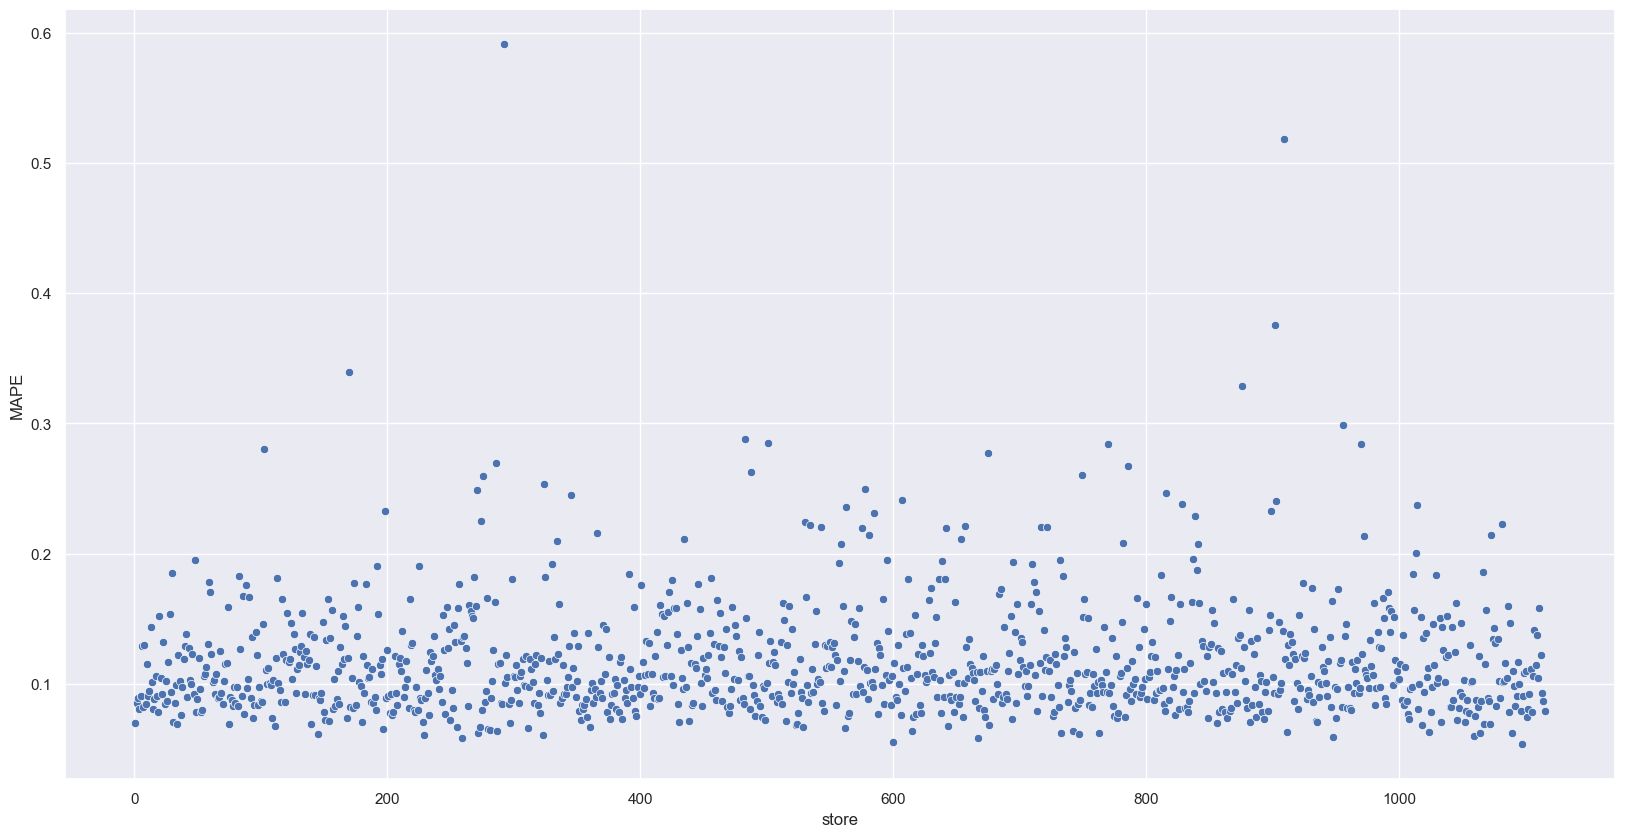

In [46]:
## Gráfico de dispersão para analisar lojas mais difíceis de realizar predição

sns.scatterplot(data = df9_p_store, x = 'store', y = 'MAPE');

**Análises:** 

- Maioria das lojas possui erro médio abaixo de 20% de erro do modelo sob a média de vendas real diária ao longo de 6 semanas.

- Existem de 40 a 50 lojas com erro médio abaixo de 40% e acima de 20% de erro do modelo sob a média de vendas real diária ao longo de 6 semanas.

- Existem 2 lojas com erro médio acima de 50% de erro do modelo sob a média de vendas real diária ao longo de 6 semanas.


## 9.2. Total Performance

In [47]:
## Somatório predições de vendas, melhor cenário e pior cenário para todas as lojas nas próximas 6 semanas

df9_total_pred = df9_p_store[['sum_predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum( x ), axis = 0).reset_index().rename(columns = {'index':'Conditions', 0: 'Sales' })
#df9_p_store[['sum_predictions','worst_scenario','best_scenario']].sum().reset_index().rename(columns = {'index':'Conditions', 0: 'Sales' })
## Ajuste valores ficarem mais visíveis
df9_total_pred['Sales'] = df9_total_pred['Sales'].map( 'R${:,.2f}'.format ) 
df9_total_pred

,Conditions,Sales
0,sum_predictions,"R$287,317,504.00"
1,worst_scenario,"R$286,458,540.85"
2,best_scenario,"R$288,176,494.26"


## 9.3. Machine Learning Performance

C:\Users\alanc\AppData\Local\Temp\ipykernel_12064\2296653092.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales'] - df9['predictions']
C:\Users\alanc\AppData\Local\Temp\ipykernel_12064\2296653092.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['predictions'] / df9['sales']


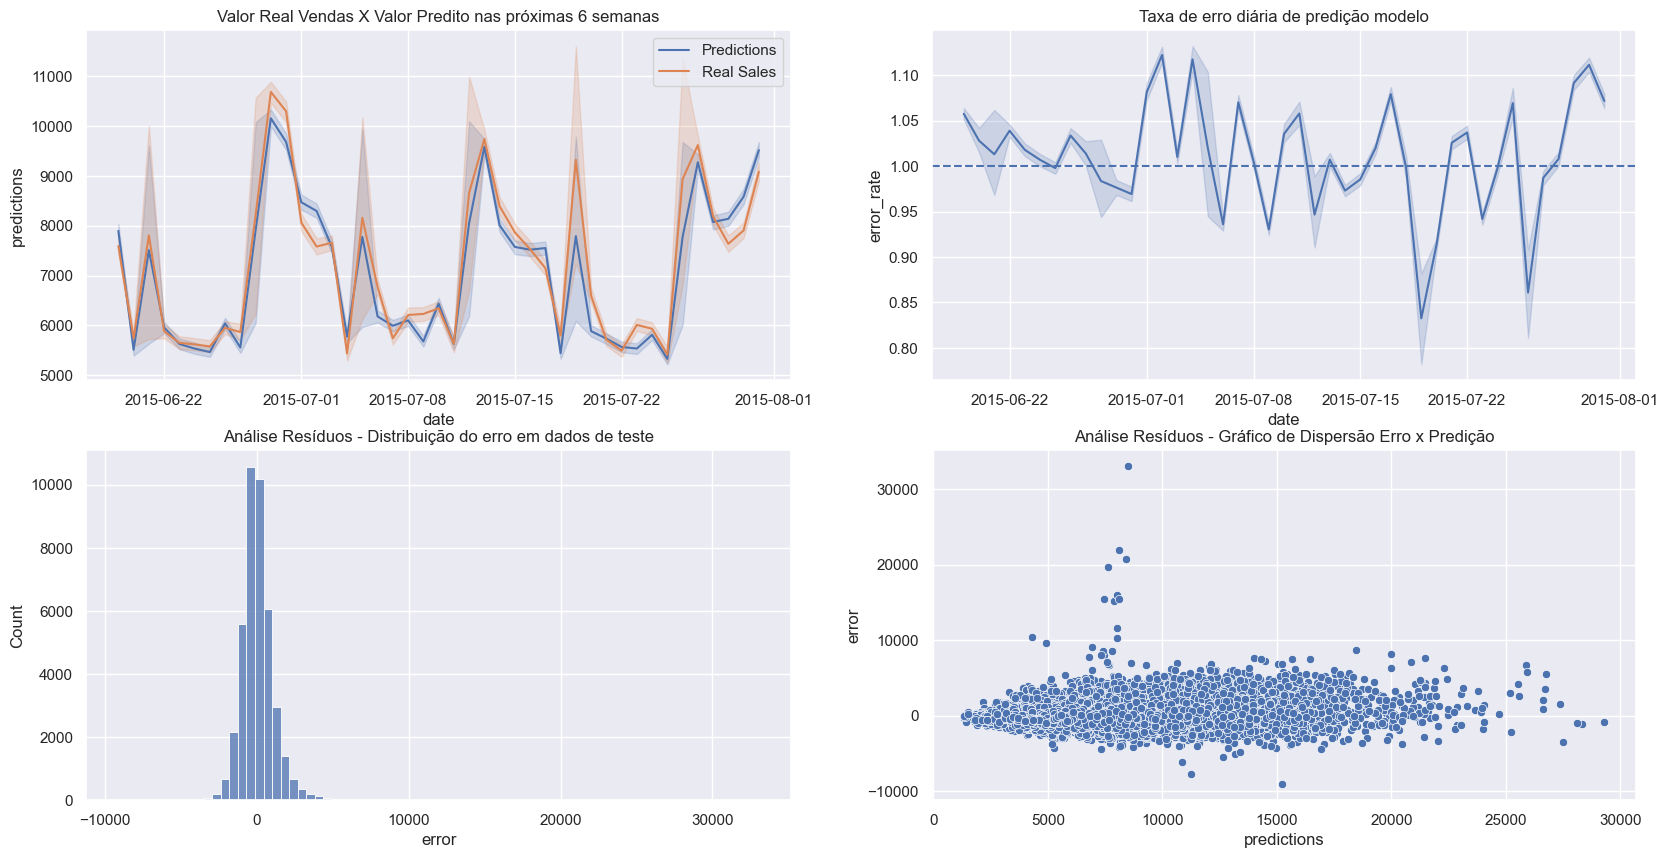

In [48]:
### VENDAS REAIS E PREDITAS DIÁRIAS AO LONGO DAS 6 SEMANAS DE ANÁLISE(dados de teste)

## Erro diário de predição de vendas para cada loja da rede ao longo das próximas 6 semanas
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']


## DASHBOARD 

## Valor predito x Valor real
plt.subplot( 2,2,1 )
sns.lineplot(x = 'date', y = 'predictions', data = df9, label = 'Predictions')
sns.lineplot(x = 'date', y = 'sales', data = df9, label = 'Real Sales').set_title("Valor Real Vendas X Valor Predito nas próximas 6 semanas");

## Taxa de erro modelo (df9['predictions'] / df9['sales'])
plt.subplot( 2,2,2 )
sns.lineplot(x = 'date', y = 'error_rate', data = df9).set_title("Taxa de erro diária de predição modelo");
plt.axhline(1, linestyle = '--');

## Distribuição do erro  - Análise de Resíduos
plt.subplot( 2,2,3 )
sns.histplot(df9['error'], bins = 75).set_title("Análise Resíduos - Distribuição do erro em dados de teste");

## Gráfico de dispersão  - Análise de Resíduos
plt.subplot( 2,2,4 )
sns.scatterplot(x = 'predictions', y = 'error', data = df9).set_title("Análise Resíduos - Gráfico de Dispersão Erro x Predição");


**Conclusões:** 

- Pelos gráficos se confirma o que a métrica MPE indicou, que o modelo em média superestima os valores preditos em relação ao valor real da variável resposta. 

- A distribuição normal do erro nos dados de teste indica que o modelo performou bem

- Os maiores erros ou dificuldades de predição do modelo ocorrem quando o valor real de vendas está entre 5000 e 10000.

# 10.0. DEPLOY MODEL TO PRODUCTION 

## 10.1. Rossmann Class 

In [176]:
import pickle 
import inflection 
import pandas as pd
import numpy as np 
import math 
import datetime

## DATA CLEANING + FEATURE ENGINEERING + DATA FILTERING + DATA PREPARATION + FEATURE SELECTION

class Rossmann( object ):
    def __init__( self ):
        self.home_path = 'C:/Users/alanc/Documents/repos/ds_em_producao/prediction_sales/'
        self.competition_distance_scaler   = pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load(open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_encoding           = pickle.load(open(self.home_path + 'parameter/store_type_encoding.pkl', 'rb'))


    def data_cleaning(self, df1):
       
        ## 1.1. Rename Columns ---------------------------------------------------------------------

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
                   'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                   'CompetitionDistance', 'CompetitionOpenSinceMonth',
                   'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                   'Promo2SinceYear', 'PromoInterval']

        ## Utiliza função lambda para encapsular a função que transforma para snake_case os atributos
        snakecase = lambda x: inflection.underscore( x )

        ## Map - Mapeia cada valor dentro da estrutura de dado passada e aplica a função snakecase
        cols_new = list( map( snakecase, cols_old ) )

        ## rename 
        df1.columns = cols_new

        ## 1.3. Data Types ---------------------------------------------------------------------

        ## Arrumar para a coluna date ficar com o tipo de dado correto
        df1['date'] = pd.to_datetime( df1['date'] )


        ## 1.5. Fillout NA ---------------------------------------------------------------------

        #competition_distance    

        # Assumptions: o valor NA ocorre quando a loja em questão não possui competidor próximo ou esse é tão longe que não é 
        # considerado competidor próximo

        # Action: substituir os NA´s por um valor maior que o valor máximo existente para outras lojas

        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x)

        #competition_open_since_month   

        # Assumptions: se a loja não possui competidor próximo, até faz sentido essa coluna ser 0 ou NA, porque não existe data de 
        # abertura se não existe loja, mas a questão é que existe mais faltante nessa coluna que na coluna de distância de competidor
        # próximo. 

        # Action: substituir os NA´s pelo valor do mês da data de venda do histórico de vendas da loja. (sem muita lógica)

        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) 
                                                        else x['competition_open_since_month'], axis = 1)

        #competition_open_since_year     

        # Assumptions: se a loja não possui competidor próximo, até faz sentido essa coluna ser 0 ou NA, porque não existe data de 
        # abertura se não existe loja, mas a questão é que existe mais faltante nessa coluna que na coluna de distância de competidor
        # próximo. 

        # Action: substituir os NA´s pelo valor do ano da data de venda do histórico de vendas da loja. (sem muita lógica)


        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) 
                                                        else x['competition_open_since_year'], axis = 1)

        #promo2_since_week               

        # Assumptions: os NA´s ocorrem em lojas que não participam da promo2, pois não existe semana de início da promo2 se a loja
        # decidiu não participar. 

        # Action: substituir os NA´s pelo valor da semana da data de venda do histórico de vendas da loja. (sem muita lógica)

        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) 
                                                        else x['promo2_since_week'], axis = 1)

        #promo2_since_year               

        # Assumptions: os NA´s ocorrem em lojas que não participam da promo2, pois não existe ano de início da promo2 se a loja
        # decidiu não participar. 

        # Action: substituir os NA´s pelo valor do ano da data de venda do histórico de vendas da loja. (sem muita lógica)

        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) 
                                                        else x['promo2_since_year'], axis = 1)

        #promo_interval

        # Assumptions: épocas de promoção 2 são conjuntos de meses que caracterizam o início de promoções 2. O NA nessa coluna 
        # caracteriza que a loja referida não realizou promoções em nenhum mês do ano da referente data. 

        # Action: substituir os NA´s por 0 pois significa que não tem época de promoção naquele ano. 
        # Criar coluna extra ('is_promo') para indicar se mês de venda da loja vigente é o mês de promo2 consecutiva. 

        month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}

        df1['promo_interval'].fillna(0, inplace = True)

        #month_map é a abreviação do mês de mensuração de venda
        df1['month_map'] = df1['date'].dt.month.map( month_map )

        # atributo que diz se o mês de venda é o mês em que se realiza promoção periodicamente
        df1['is_promo'] = df1[['month_map','promo_interval']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if 
                                                                    x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis = 1)


        ## 1.6. Change Types ---------------------------------------------------------------------


        ### Mudar nº de mês, ano e semana de float64 para int64

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int64' )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int64' )

        df1['promo2_since_week'] = df1['promo2_since_week'].astype( 'int64' )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( 'int64' )

        return df1
    
    
    def feature_engineering(self, df2):
        
        ## FEATURE ENGINEERING + DATA FILTERING
        
        ## 2.4. Feature Engineering

        ### 2.4.1. Da variável 'date'

        # year - extrair apenas o ano de vendas daquela loja

        df2['year'] = df2['date'].dt.year

        # month - extrair apenas o mês de vendas daquela loja

        df2['month'] = df2['date'].dt.month

        # day - extrair apenas o dia de vendas daquela loja

        df2['day'] = df2['date'].dt.day

        # week of year - extrair apenas a semana de vendas do ano daquela loja

        df2['week_of_year'] = df2['date'].dt.isocalendar().week
        # (year-week) - Formatar a data para em string aparecer o ano e a semana do ano das vendas daquela loja

        df2['year_week'] = df2['date'].dt.strftime("%Y-%W")


        ### 2.4.2. Das variáveis 'competition_open_since_month' e 'competition_open_since_year'

        # competition since  
        df2['competition_since'] = df2[['competition_open_since_year','competition_open_since_month']].apply(lambda x: datetime.datetime(year = x['competition_open_since_year'] , month = x['competition_open_since_month'] , day = 1 ), axis = 1)

        # competition time month - Calculo de período entre datas
        df2['competition_time_month'] =( (df2['date'] - df2['competition_since']) / 30 ).apply( lambda x: x.days ).astype( 'int64' )

        ### 2.4.3. Das variáveis ''promo2_since_week'' e 'promo2_since_year'

        # promo since 
        df2['promo_since'] =  df2['promo2_since_year'].astype( str ) + "-" + df2['promo2_since_week'].astype( str )

        # datetime
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7) )


        # promo time week - - Calculo de período entre datas
        df2['promo_time_week'] =( (df2['date'] - df2['promo_since']) / 7 ).apply(lambda x: x.days ).astype( 'int64' )

        ### 2.4.4. Da variável 'assortment'
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        ### 2.4.5. Da variável 'state_holiday'       
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        # 3.0. FILTRAGEM DE VARIÁVEIS

        ## 3.1. Filtragem das Linhas

        df2 = df2[ df2['open'] != 0  ]

        ## 3.2. Seleção das Colunas

        ## COLUNAS EXCLUÍDAS:
        cols_drop = ['open','promo_interval','month_map']
        df2 = df2.drop( cols_drop, axis = 1 )
                
        return df2 
    
    def data_preparation(self, df5):
        
        
        ## 5.2. Rescaling

        # competition_distance
        df5["competition_distance"] = self.competition_distance_scaler.transform( df5[["competition_distance"]].values )

        # competition_time_month
        df5["competition_time_month"] = self.competition_time_month_scaler.transform( df5[["competition_time_month"]].values )

        # promo_time_week
        df5["promo_time_week"] = self.promo_time_week_scaler.transform( df5[["promo_time_week"]].values )
        
        # year
        df5["year"] = self.year_scaler.transform( df5[["year"]].values )
        
        ## 5.3. Transformação 

        ### 5.3.1. Encoding

        # state_holiday -> One Hot Encoding 
        df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])

        # store_type - Label Encoder
        df5["store_type"] = self.store_type_encoding.transform( df5["store_type"] )
              
        # assortment
        assortment_dict = {'basic': 1, 'extended': 2, 'extra': 3}
        # Troca de valores da coluna utilizando o método .map e o dicionário como referência
        df5["assortment"] = df5["assortment"].map(assortment_dict)


        ### 5.3.3. Nature Transformation

        ## FEATURES COM NATUREZA CÍCLICA:

        # day_of_week - ciclo de 7 
        df5["day_of_week_sin"] = df5["day_of_week"].apply(lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5["day_of_week_cos"] = df5["day_of_week"].apply(lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )


        # month - ciclo de 12
        df5["month_sin"] = df5["month"].apply(lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5["month_cos"] = df5["month"].apply(lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )


        # day - ciclo de 31
        df5["day_sin"] = df5["day"].apply(lambda x: np.sin( x * ( 2. * np.pi/31 ) ) )
        df5["day_cos"] = df5["day"].apply(lambda x: np.cos( x * ( 2. * np.pi/31 ) ) )


        # week_of_year - ciclo de 52 
        df5["week_of_year_sin"] = df5["week_of_year"].apply(lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5["week_of_year_cos"] = df5["week_of_year"].apply(lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

        # Feature Selection with Boruta and EDA
        cols_selected = ['store', 'promo', 'store_type','assortment', 'competition_distance', 'competition_open_since_month',
        'competition_open_since_year', 'promo2', 'promo2_since_week','promo2_since_year', 'competition_time_month',
        'promo_time_week','day_of_week_sin','day_of_week_cos','month_cos','month_sin','day_sin','day_cos','week_of_year_cos',
        'week_of_year_sin']
        
        
        return df5[cols_selected]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data 
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient = 'records', date_format = 'iso' )

## 10.2. API Handler 

In [ ]:
import pandas as pd

## Importando classe Rossmann do arquivo Rossmann.py da pasta rossmann
#from nome_pasta.nome_arquivo import class_in_arquivo
from rossman.Rossmann import Rossmann

## Biblioteca para construir interfaces(app) Web em Python para construir API´s
from flask import Flask, request, Response

# loading model 
model = pickle.load(open('C:/Users/alanc/Documents/repos/ds_em_producao/prediction_sales/model/model_xgb_rossmann.pkl', 'rb'))

# instaciando objeto da classe Flask que será a API
app = Flask( __name__ )

# criando endpoint com método POST (envia algum dado para poder receber)
## método GET (pede algum dado para poder receber)
@app.route('/rossmann/predict', methods = ['POST'])

def rossmann_predict():
    test_json = request.get_json() ## Classe request com método get_json() para puxar o dado enviado para a API

    if test_json: # Para checar se há dado 
        if isinstance(test_json, dict): #unique example/observations/sample in dict
            test_raw = pd.DataFrame(test_json, index = [0])
            
        else: #multiple example/observations/sample in dict (dict aninhado)
            test_raw = pd.DataFrame(test_json, columns = test_json[0].keys() )
            
        ## Intanciando objeto da classe Rossmann 
        pipeline = Rossmann()
        
        # data cleaning - começo a usar os métodos da classe Rossmann criada
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering 
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation 
        df3 = pipeline.data_preparation( df2 )
            
        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)

        return df_response ## Dado resposta para a entidade que solitou algo via dado 
       
        
    else:
        
        return Response( '{}', status = 200, mimetype = 'application/json')
        
if __name__ == '__main__':
    app.run( '192.168.0.6' ) ## dizer para endpoint rodar no localhost (rodando na máquina)
# 192.168.0.6 -> endereço IPv4 pc local  

## 10.3. API Tester 

In [5]:
# loading test dataset
df10 = pd.read_csv('data/test.csv')

In [ ]:
## Dados de teste possuem atributos de store e data entre as datas de 01/08/2015 à 17/09/2015 

In [56]:
## merge test dataset + store 
df11 = df10.merge(df_store_raw, how = "left", on = "Store")

## choose store for prediction
df11 = df11[ df11['Store'].isin([24,12,22]) ] 

# Manipulation 

## remove closed days
df11 = df11[ df11['Open'] != 0 ]
## select just samples without NA 
df11 = df11[ df11['Open'].notnull() ]
## exclude column "Id"
df11 = df11.drop('Id', axis = 1)

In [57]:
# convert Dataframe to json for send comunication between the systems
data = json.dumps( df11.to_dict( orient = 'records' ) )

## data é uma lista de dicionários(json) onde cada dicionário representa uma linha do dataframe

In [63]:
# API Call

# url local - endereço em que os dados serão enviados (IP + PORTA + endpoint) 
#url = 'http://192.168.0.6:5000/rossmann/predict'
# url em servidor na nuvem 
url = 'https://rossmann-predict-sales-project.onrender.com/rossmann/predict'
# Formato dos dados que serão enviados
header = {'Content-type': 'application/json'}
# dado a ser enviado
data = data



r = requests.post(url = url, data = data, headers = header)
print( f'Status Code { r.status_code }' )

Status Code 200


In [64]:
## Predição diária de vendas durante 6 semanas para as lojas selecionadas
d1 = pd.DataFrame( r.json(), columns = r.json()[0].keys() )

In [65]:
## Soma da Predição diária de vendas para as 6 semanas das lojas selecionadas 
d2 = d1[['store','prediction']].groupby('store').sum().reset_index()

### dysplay response with sum of sales

for i in range( len(d2) ):
    print('\nA loja nº {} irá vender US$ {:,.2f} dólares nas próximas 6 semanas.'.format(
    d2.loc[i, 'store'],
    d2.loc[i, 'prediction'] ) )


A loja nº 12 irá vender US$ 309,000.11 dólares nas próximas 6 semanas.

A loja nº 22 irá vender US$ 185,927.49 dólares nas próximas 6 semanas.

A loja nº 24 irá vender US$ 382,319.80 dólares nas próximas 6 semanas.


In [61]:
d2

,store,prediction
0,12,309000.11
1,22,185927.49
2,24,382319.80
